In [1]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb as pdb
import pickle
# Tools
from IPython.display import clear_output
import copy
import sys
import pandas as pd
# Specialized packages
from casadi import *
from casadi.tools import *
import control
import time as time
import os.path
from scipy.linalg import solve_discrete_are, inv, eig, block_diag 
from sklearn import linear_model
from sklearn.utils import assert_all_finite
import scipy.signal as signal

# For Plotting
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter
from cycler import cycler
import time as time
# Custom packages
import do_mpc



# Customizing Matplotlib:
mpl.rcParams['font.size'] = 15
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.unicode_minus'] = 'true'
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelpad'] = 6
mpl.rcParams['pdf.fonttype'] = 42


# Create Model

In [2]:
dt=1 #Time discretization = 1 hour
n1=2 #Rooms in direction 1
n2=2 #Rooms in direction 2

In [3]:
A=np.array([[0.8511,0.0541,0.0707],
           [0.1293,0.8635,0.0055],
           [0.0989,0.0003,0.7541]])
B=np.array([[0.0035,0.0003,0.0002]]).T
E_j=1e-3*np.array([[22.217,1.7912,42.212],
             [1.5376,0.6944,2.9214],
             [103.18,0.1032,196.04]])
F_j=0.1


In [4]:
#Set up do-mpc model
def make_model(n1,n2):
    nr=n1*n2
    nx=n1*n2*3 #3 Temperatures per room
    nu=2*nr #Heating Rate and Cooling Rate
    nd=2+nr #Ext temperaure, solar radiation, internal gains
    idx=np.arange(0,n1*n2).reshape(n1,n2)
    model_type = 'discrete'
    model = do_mpc.model.Model(model_type)

    # Introduce new states, inputs and other variables to the model:
    T_r = model.set_variable(var_type='_x', var_name='T_r', shape=(nr,1))
    T_w_int = model.set_variable(var_type='_x', var_name='T_w_int', shape=(nr,1))
    T_w_ext = model.set_variable(var_type='_x', var_name='T_w_ext', shape=(nr,1))

    u_heat = model.set_variable(var_type='_u', var_name='u_heat',shape=(nr,1))
    u_cool=  model.set_variable(var_type='_u', var_name='u_cool',shape=(nr,1))

    T_ext=model.set_variable('_tvp', 'T_ext')
    s_r=model.set_variable('_tvp', 's_r')
    in_g=model.set_variable('_tvp', 'in_g',shape=(nr,1))

    # Set right-hand-side of ODE for all introduced states (_x).
    # Names are inherited from the state definition.
    rhs_T_r=[]
    rhs_T_w_int=[]
    rhs_T_w_ext=[]
    for i in range(n1):
        for j in range(n2):
            idx_r=idx[i,j]
            x=vertcat(T_r[idx_r],T_w_int[idx_r],T_w_ext[idx_r])
            d=vertcat(T_ext,s_r,in_g[idx_r])
            rhs=A@x+B@u_heat[idx_r]-B@u_cool[idx_r]+E_j@d
            if i==0:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i-1,j]]-T_r[idx_r])
            if i>=n1-1:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i+1,j]]-T_r[idx_r])
            if j==0:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i,j-1]]-T_r[idx_r])
            if j>=n2-1:
                rhs[0]+=0
            else:
                rhs[0]+=F_j*(T_r[idx[i,j+1]]-T_r[idx_r])

            rhs_T_r.append(rhs[0])
            rhs_T_w_int.append(rhs[1])
            rhs_T_w_ext.append(rhs[2])


    model.set_rhs('T_r',vertcat(*rhs_T_r))
    model.set_rhs('T_w_int',vertcat(*rhs_T_w_int))
    model.set_rhs('T_w_ext',vertcat(*rhs_T_w_ext))

    # Setup model:
    model.setup()
    return nr,nx,nu,nd,model


In [5]:
#Set up do-mpc model
def make_nonlin_model(n1,n2):
    nr=n1*n2
    nx=n1*n2*3 #3 Temperatures per room
    nu=2*nr #Heating Rate and Cooling Rate
    nd=2+nr #Ext temperaure, solar radiation, internal gains
    idx=np.arange(0,n1*n2).reshape(n1,n2)
    model_type = 'discrete'
    model = do_mpc.model.Model(model_type)

    # Introduce new states, inputs and other variables to the model:
    T_r = model.set_variable(var_type='_x', var_name='T_r', shape=(nr,1))
    T_w_int = model.set_variable(var_type='_x', var_name='T_w_int', shape=(nr,1))
    T_w_ext = model.set_variable(var_type='_x', var_name='T_w_ext', shape=(nr,1))

    u_heat = model.set_variable(var_type='_u', var_name='u_heat',shape=(nr,1))
    u_cool=  model.set_variable(var_type='_u', var_name='u_cool',shape=(nr,1))

    T_ext=model.set_variable('_tvp', 'T_ext')
    s_r=model.set_variable('_tvp', 's_r')
    in_g=model.set_variable('_tvp', 'in_g',shape=(nr,1))

    # Set right-hand-side of ODE for all introduced states (_x).
    # Names are inherited from the state definition.
    rhs_T_r=[]
    rhs_T_w_int=[]
    rhs_T_w_ext=[]
    for i in range(n1):
        for j in range(n2):
            idx_r=idx[i,j]
            x=vertcat(T_r[idx_r],T_w_int[idx_r],T_w_ext[idx_r])
            d=vertcat(T_ext,s_r,in_g[idx_r])
            rhs=A@x+B@u_heat[idx_r]-B@u_cool[idx_r]+E_j@d
            if i==0:
                rhs[0]+=0
            else:
                rhs[0]+=F_j/20*(T_r[idx[i-1,j]]-T_r[idx_r])**3
            if i>=n1-1:
                rhs[0]+=0
            else:
                rhs[0]+=F_j/20*(T_r[idx[i+1,j]]-T_r[idx_r])**3
            if j==0:
                rhs[0]+=0
            else:
                rhs[0]+=F_j/20*(T_r[idx[i,j-1]]-T_r[idx_r])**3
            if j>=n2-1:
                rhs[0]+=0
            else:
                rhs[0]+=F_j/20*(T_r[idx[i,j+1]]-T_r[idx_r])**3

            rhs_T_r.append(rhs[0])
            rhs_T_w_int.append(rhs[1])
            rhs_T_w_ext.append(rhs[2])


    model.set_rhs('T_r',vertcat(*rhs_T_r))
    model.set_rhs('T_w_int',vertcat(*rhs_T_w_int))
    model.set_rhs('T_w_ext',vertcat(*rhs_T_w_ext))

    # Setup model:
    model.setup()
    return nr,nx,nu,nd,model


In [6]:
nr,nx,nu,nd,model=make_model(n1,n2)
#nr,nx,nu,nd,model=make_nonlin_model(n1,n2)

In [7]:
# state constraints
lb_x = -inf*np.ones((nx,1))
lb_x[0]=21
lb_x[1]=16
lb_x[2]=18
lb_x[3]=23
ub_x = np.ones((nx,1))*inf
ub_x[0]=23
ub_x[1]=18
ub_x[2]=20
ub_x[3]=25
# input constraints
lb_u = 0*np.ones((nu,1))
ub_u = 1000*np.ones((nu,1))

# Creating the Simulator and uncertainties

In [8]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = dt)


To simulate the predictions of the uncertain parameters, following template needs to be specified

In [9]:
p_template = simulator.get_tvp_template()

In [10]:
int_gains_max=6
int_gains_min=2
T_env_var=1
sr_unc=0.25
in_g_unc=0.3

Load the measurements of the Bochum weather station. Data starting in January 2008.

In [11]:
with open('exttemp_and_solrad_2008.pkl', 'rb') as f:
    data = pickle.load(f)

In [12]:
data.keys()

dict_keys(['date', 'T', 'sr'])

p_fun_0 describes the "known" uncertainties, i.e. the forecast. The internal gains are assumed to be 6 during workhours, else 2.

In [13]:
def p_fun_0(t_now):
    p_template['T_ext'] = data['T'][t_now//dt]
    p_template['s_r'] = data['sr'][t_now//dt]
    if 9<=t_now%24<=17:
        p_template['in_g'] = int_gains_max
    else:
        p_template['in_g']=int_gains_min
    return p_template

p_fun_max describes the maximum realization of the uncertainties. The internal gains only vary during workhours.

In [14]:
def p_fun_max(t_now):
    p_template=p_fun_0(t_now//dt)
    p_template['T_ext'] += T_env_var
    p_template['s_r'] *= 1+sr_unc
    if 9<=t_now%24<=17:
        p_template['in_g']*=1+in_g_unc
    return p_template

p_fun_min describes the minimum realization of the uncertainties.

In [15]:
def p_fun_min(t_now):
    p_template=p_fun_0(t_now//dt)
    p_template['T_ext'] -=T_env_var
    p_template['s_r'] *= 1-sr_unc
    if 9<=t_now%24<=17:
        p_template['in_g']*=1-in_g_unc
    return p_template

p_fun_var describes a uniformly distributed randomly time varying realization of the uncertain parameters.

In [16]:
def p_fun_var(t):
    np.random.seed(t//dt)
    p_template=p_fun_0(t//dt)
    for keys in p_template.keys():
        if keys!='default':
            if keys=='in_g':
                if 9<=t%24<=17:
                    for l in range(p_template[keys].shape[0]):
                        p_template[keys,l]*=(1+in_g_unc*np.random.uniform(-1,1))
            elif keys=='T_ext':
                p_template[keys]+=T_env_var*np.random.uniform(-1,1)
            elif keys=='s_r':
                p_template[keys]*=(1+sr_unc*np.random.uniform(-1,1))
                p_template[keys]=np.max([0,p_template[keys]])
    return p_template

Test the simulator

In [17]:
simulator.set_tvp_fun(p_fun_0)
simulator.setup()

In [18]:
simulator.reset_history()
# Initial Conditions
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
simulator.x0=x_0
u0=np.zeros((nu,1))
u0[0:nu//2]=250
for i in range(100):
    x0=simulator.make_step(u0)

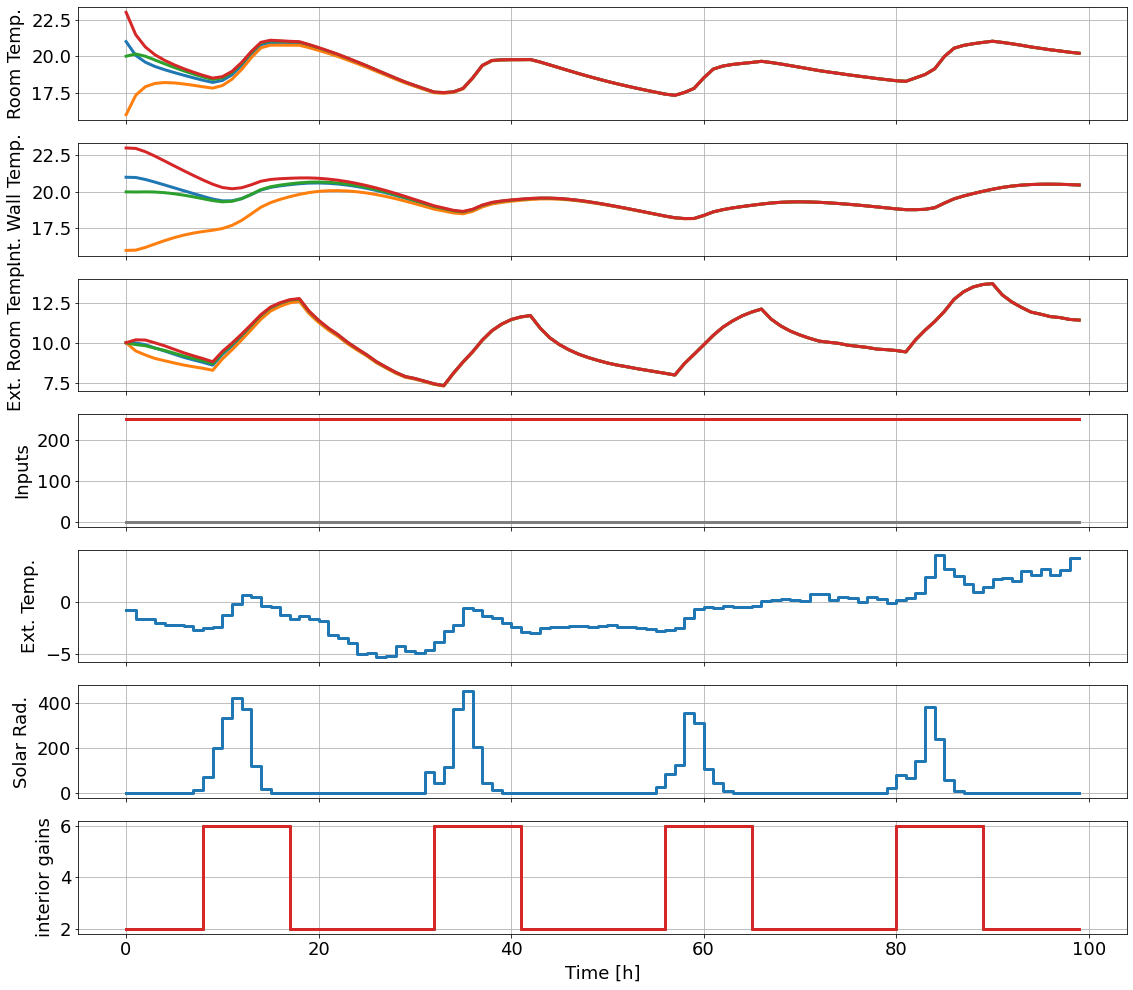

In [19]:
fig, ax=plt.subplots(7,1, sharex=True,figsize=(16,14))
ax[0].plot(simulator.data['_time'],simulator.data['_x','T_r'])
ax[1].plot(simulator.data['_time'],simulator.data['_x','T_w_int'])
ax[2].plot(simulator.data['_time'],simulator.data['_x','T_w_ext'])
ax[3].plot(simulator.data['_time'],simulator.data['_u'])
ax[4].step(simulator.data['_time'],simulator.data['_tvp','T_ext'])
ax[5].step(simulator.data['_time'],simulator.data['_tvp','s_r'])
ax[6].step(simulator.data['_time'],simulator.data['_tvp','in_g'])
ax[0].set_ylabel('Room Temp.')
ax[1].set_ylabel('Int. Wall Temp.')
ax[2].set_ylabel('Ext. Room Temp.')
ax[3].set_ylabel('Inputs')
ax[4].set_ylabel('Ext. Temp.')
ax[5].set_ylabel('Solar Rad.')
ax[6].set_ylabel('interior gains')
ax[6].set_xlabel('Time [h]')
fig.tight_layout()

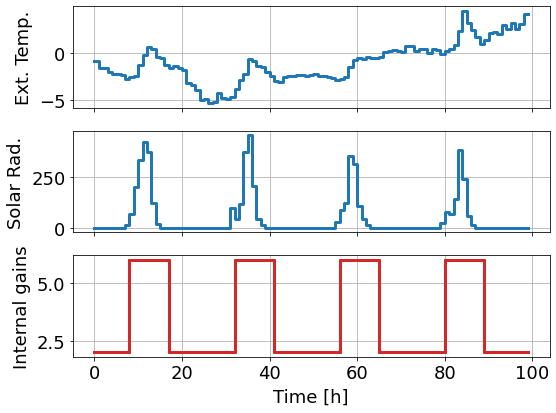

In [20]:
fig, ax=plt.subplots(3,1, sharex=True,figsize=(8,6))
ax[0].step(simulator.data['_time'],simulator.data['_tvp','T_ext'])
ax[1].step(simulator.data['_time'],simulator.data['_tvp','s_r'])
ax[2].step(simulator.data['_time'],simulator.data['_tvp','in_g'])
ax[0].set_ylabel('Ext. Temp.')
ax[1].set_ylabel('Solar Rad.')
ax[2].set_ylabel('Internal gains')
ax[2].set_xlabel('Time [h]')
fig.tight_layout()

# General Parameters for all MPC approaches

In [21]:
N = 12

In [22]:
x=SX.sym('x',nx,1)
u=SX.sym('x',nu,1)
p=SX.sym('p',nd,1)
system=Function('system',[model.x,model.u,model.tvp],[model._rhs])

In [23]:
u_b=SX.sym('u_b',nu) # Was implemented, if the change of inputs should be penalized as well
# stage cost
#stage_cost = 1/10*(u-u_b).T@R@(u-u_b)+(u-0).T@R@(u-0)
stage_cost = sum1(u)
stage_cost_fcn = Function('stage_cost',[x,u,u_b],[stage_cost])

# terminal cost
terminal_cost = 0
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

## Nominal MPC

In [24]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1]),
    entry('u', shape=nu, repeat=[N])
])
opt_p=struct_symSX([
    entry('p',shape=nd, repeat=[N])
])

In [25]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [26]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [27]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [28]:
x_init = SX.sym('x_init', nx)
u_in=SX.sym('u_in', nu)
x0 = opt_x['x', 0]

g.append(x0-x_init)
lb_g.append(np.zeros((nx,1)))
ub_g.append(np.zeros((nx,1)))
# 01

for i in range(N):
    # objective
    if i>0:
        J += stage_cost_fcn(opt_x['x',i], opt_x['u',i], opt_x['u',i-1])
    else:
        J += stage_cost_fcn(opt_x['x',i], opt_x['u',i], u_in)
    # System equations
    x_next = system(opt_x['x',i], opt_x['u',i],opt_p['p',i])
    
    g.append(x_next - opt_x['x', i+1])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    # 04


# Terminal cost
J += terminal_cost_fcn(opt_x['x', N])
# 05

# Concatenate all constraints
g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,u_in,vertcat(opt_p))}
mpc_solver = nlpsol('solver','ipopt',prob)

In [29]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []
u0=np.zeros((nu,1))
# Set number of iterations
N_sim = 50

Vary the tvp_function for the different uncertainty realizations:

 - p_fun_var gives timevarying uniformly random values between the bounds, which are defined as:
 - p_fun_max gives the upper bound at time (t)
 - p_fun_min gives the lower bound at time (t)

In [30]:
simulator.set_tvp_fun(p_fun_max)
simulator.reset_history()
simulator.x0=x_0

In [31]:
opt_p_k=opt_p(0)
clc_MPC=np.zeros((N_sim,1))
cv_MPC=np.zeros((N_sim,1))
tic=time.time()
for i in range(N_sim):
    print(i)
    # Get weather forecast
    for k in range(N):
        opt_p_k['p',k]=vertsplit(p_fun_0(k*dt+i*dt))
    # solve optimization problem
    # Warmstart the optimizer by passing the previous solution as an initial guess
    if i>0:
        mpc_res = mpc_solver(p=vertcat(x_0,u_k,vertcat(opt_p_k)), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    else:
        mpc_res = mpc_solver(p=vertcat(x_0,u0,vertcat(opt_p_k)), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)

    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]
    # Calculate Closed Loop Cost
    if i>0:
        clc_MPC[i]=clc_MPC[i-1]+stage_cost_fcn(x_0,u_k,res_u_mpc[-1])
    else:
        clc_MPC[i]=stage_cost_fcn(x_0,u_k,u0)
    # simulate the system
    x_next = simulator.make_step(u_k)
    # Calculate Constraint Violations
    cv_MPC[i]=np.sum([np.max([lb_x[l]-x_0[l],0]) for l in range(nx)])+np.sum([np.max([x_0[l]-ub_x[l],0]) for l in range(nx)])

    # Update the initial state
    x_0 = x_next

    # Store the results
    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
    # 05
toc_MPC=time.time()-tic
# Make an array from the list of arrays:
res_x_mpc = np.concatenate(res_x_mpc,axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)

0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      252
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      148
                     variables with only upper bounds:        0
Total number of eq

C:\Users\smmzhein\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      252
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      148
                     variables with only upper bounds:        0
Total number of equality constraints.................:      156
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

  39r1.2875838e+004 4.58e-001 2.58e-002  -5.8 6.33e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r1.2875670e+004 4.58e-001 1.48e-011  -5.8 1.96e-002    -  1.00e+000 1.00e+000f  1
  41r1.2873758e+004 4.58e-001 2.98e-003  -8.7 8.78e-002    -  1.00e+000 1.00e+000f  1
  42r1.2873756e+004 4.58e-001 8.25e-001  -8.7 1.73e-003    -  1.00e+000 6.25e-002h  5
  43r1.2873462e+004 4.58e-001 4.12e-001  -8.7 2.44e-002    -  1.00e+000 5.00e-001h  2
  44r1.2873461e+004 4.58e-001 4.11e-001  -8.7 1.83e-002    -  1.00e+000 1.95e-003h 10
  45r1.2873461e+004 4.58e-001 4.11e-001  -8.7 2.00e-002    -  1.00e+000 3.64e-012h 39
  46r1.2873461e+004 4.58e-001 4.11e-001  -8.7 2.06e-002    -  1.00e+000 1.82e-012h 40
  47r1.2873211e+004 4.58e-001 2.06e-001  -8.7 2.08e-002    -  1.00e+000 5.00e-001h  2
  48r1.2873179e+004 4.58e-001 1.80e-001  -8.7 1.05e-002    -  1.00e+000 1.25e-001h  4
  49r1.2873179e+004 4.58e-001 1.80e-001  -8.7 9.24e-003    

  34r1.4753394e+004 1.62e-001 9.44e-011  -5.0 3.90e-001    -  1.00e+000 1.00e+000f  1
  35r1.4740321e+004 1.62e-001 1.24e-003  -7.5 1.18e+000    -  9.99e-001 9.95e-001f  1
  36r1.4739462e+004 1.62e-001 4.55e-013  -7.5 6.75e-002    -  1.00e+000 1.00e+000f  1
  37r1.4736345e+004 1.62e-001 6.02e-005  -9.0 4.68e-001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  1.4736089330581994e+004   1.4736089330581994e+004
Dual infeasibility......:  1.0000008630371977e+000   1.0000008630371977e+000
Constraint violation....:  1.6212262890640616e-001   1.6212262890640616e-001
Complementarity.........:  1.8312157331164719e-008   1.8312157331164719e-008
Overall NLP error.......:  1.0000008630371977e+000   1.0000008630371977e+000


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations          

   6 1.4462973e+004 3.17e-001 7.24e+001  -1.0 1.11e+002    -  7.90e-001 2.86e-001f  1
   7 1.4298872e+004 1.39e-002 3.03e+000  -1.0 7.95e+001    -  9.08e-001 9.56e-001f  1
   8 1.4297015e+004 1.08e-002 3.31e+001  -1.0 3.49e+000    -  1.00e+000 2.22e-001f  1
   9 1.4293979e+004 6.00e-003 3.28e+002  -1.0 2.06e+000    -  1.04e-001 4.47e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4291832e+004 1.07e-014 1.01e-013  -1.0 1.87e+000    -  1.00e+000 1.00e+000f  1
  11 1.4284109e+004 1.07e-014 6.96e-014  -1.7 9.68e-001    -  1.00e+000 1.00e+000f  1
  12 1.4282488e+004 1.07e-014 8.30e-014  -2.5 2.04e-001    -  1.00e+000 1.00e+000f  1
  13 1.4282232e+004 1.07e-014 6.83e-014  -3.8 3.20e-002    -  1.00e+000 1.00e+000f  1
  14 1.4282218e+004 1.07e-014 5.15e-014  -5.7 1.78e-003    -  1.00e+000 1.00e+000f  1
  15 1.4282218e+004 1.07e-014 7.21e-014  -8.6 2.21e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 15

                            

  11r1.1866931e+004 2.64e-001 9.99e+002  -0.6 6.98e+002    -  6.69e-004 2.10e-004f  1
  12r1.1883601e+004 2.64e-001 9.98e+002  -0.6 6.26e+002    -  3.85e-004 1.96e-003f  1
  13r1.1897771e+004 2.64e-001 9.95e+002  -0.6 6.15e+002    -  3.29e-003 1.73e-003f  1
  14r1.1940139e+004 2.64e-001 9.96e+002  -0.6 6.23e+002    -  4.29e-004 5.23e-003f  1
  15r1.1985655e+004 2.64e-001 9.96e+002  -0.6 6.54e+002    -  1.71e-003 5.12e-003f  1
  16r1.2024411e+004 2.64e-001 9.79e+002  -0.6 6.05e+002    -  2.08e-002 5.71e-003f  1
  17r1.2076474e+004 2.64e-001 9.69e+002  -0.6 5.00e+002    -  2.82e-002 1.08e-002f  1
  18r1.2121555e+004 2.64e-001 9.50e+002  -0.6 4.34e+002    -  6.95e-002 1.92e-002f  1
  19r1.2164339e+004 2.64e-001 9.13e+002  -0.6 4.22e+002    -  5.66e-002 3.84e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r1.2169581e+004 2.64e-001 9.06e+002  -0.6 9.62e+001    -  5.79e-002 7.74e-003f  1
  21r1.2190019e+004 2.64e-001 8.39e+002  -0.6 3.48e+001    

   2 1.4124792e+004 7.89e-001 1.14e+002  -1.0 6.88e+001    -  2.44e-001 3.86e-002f  1
   3 1.4121552e+004 7.55e-001 1.10e+002  -1.0 8.60e+001    -  1.57e-002 4.35e-002f  1
   4 1.4121521e+004 7.55e-001 3.57e+004  -1.0 1.08e+002    -  4.50e-001 4.54e-004h  1
   5r1.4121521e+004 7.55e-001 1.00e+003  -0.1 0.00e+000    -  0.00e+000 2.84e-007R  5
   6r1.4209079e+004 5.61e-001 1.00e+003  -0.1 3.92e+003    -  3.46e-003 1.64e-003f  1
   7 1.4209071e+004 5.61e-001 2.65e+004  -1.0 9.67e+001    -  1.95e-001 1.13e-005h  1
   8r1.4209071e+004 5.61e-001 9.99e+002  -0.3 0.00e+000    -  0.00e+000 5.63e-008R  2
   9r1.4239668e+004 3.63e-001 9.99e+002  -0.3 9.53e+002    -  4.52e-003 2.39e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r1.4239668e+004 3.63e-001 9.99e+002  -0.4 0.00e+000    -  0.00e+000 4.63e-007R  5
  11r1.4247605e+004 4.14e-001 9.97e+002  -0.4 5.41e+002    -  1.59e-003 1.82e-003f  1
  12r1.4270985e+004 4.65e-001 9.93e+002  -0.4 6.12e+002    

In [32]:
mpc_data=copy.copy(simulator.data)

Text(0.5, 0, 'time [h]')

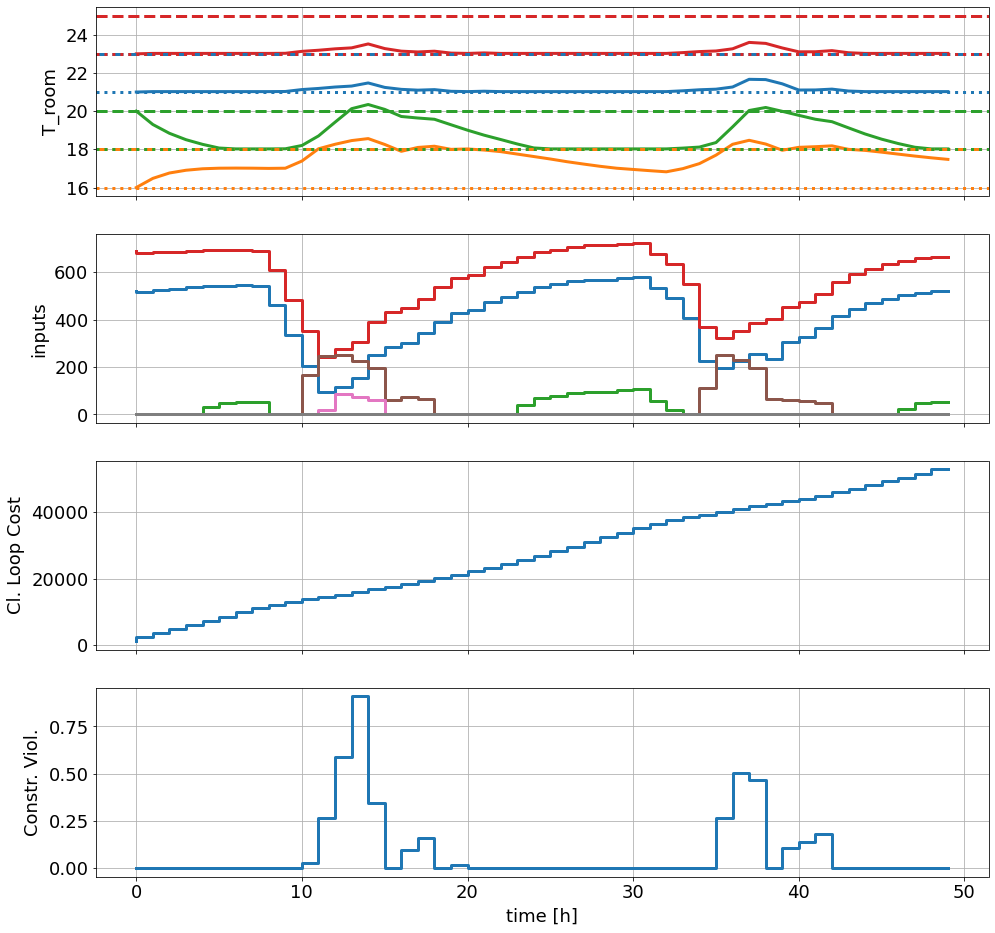

In [33]:
fig, ax = plt.subplots(4,1, sharex=True,figsize=(16,16))

# plot the states
ax[0].plot(mpc_data['_time'],mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
#ax[1].plot(mpc_data['_time'],mpc_data['_x','T_w_int'])
#ax[2].plot(mpc_data['_time'],mpc_data['_x','T_w_ext'])
ax[1].step(mpc_data['_time'],mpc_data['_u'])
#ax[4].step(mpc_data['_time'],mpc_data['_tvp','T_ext'])
#ax[5].step(mpc_data['_time'],mpc_data['_tvp','s_r'])
#ax[6].step(mpc_data['_time'],mpc_data['_tvp','in_g'])
ax[2].step(mpc_data['_time'],clc_MPC)
ax[3].step(mpc_data['_time'],cv_MPC)
# Set labels
ax[0].set_ylabel('T_room')
ax[1].set_ylabel('inputs')
#ax[1].set_ylabel('T_w_int')
#ax[2].set_ylabel('T_w_ext')
#ax[4].set_ylabel('T_ext')
#ax[5].set_ylabel('s_r')
#ax[6].set_ylabel('int. gains')
ax[2].set_ylabel('Cl. Loop Cost')
ax[3].set_ylabel('Constr. Viol.')
ax[-1].set_xlabel('time [h]')

Additional Plot for more information

Text(0.5, 0, 'time [h]')

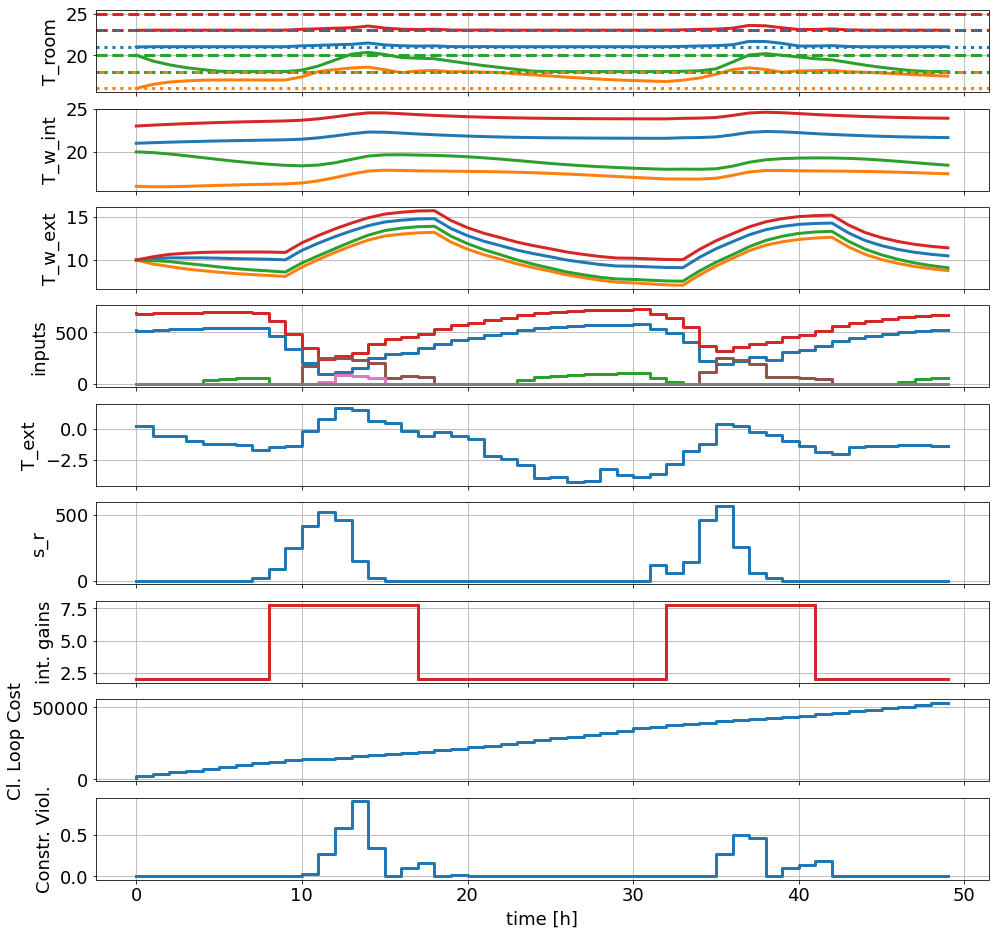

In [34]:
fig, ax = plt.subplots(9,1, sharex=True,figsize=(16,16))

# plot the states
ax[0].plot(mpc_data['_time'],mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(mpc_data['_time'],mpc_data['_x','T_w_int'])
ax[2].plot(mpc_data['_time'],mpc_data['_x','T_w_ext'])
ax[3].step(mpc_data['_time'],mpc_data['_u'])
ax[4].step(mpc_data['_time'],mpc_data['_tvp','T_ext'])
ax[5].step(mpc_data['_time'],mpc_data['_tvp','s_r'])
ax[6].step(mpc_data['_time'],mpc_data['_tvp','in_g'])
ax[7].step(mpc_data['_time'],clc_MPC)
ax[8].step(mpc_data['_time'],cv_MPC)
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[7].set_ylabel('Cl. Loop Cost')
ax[8].set_ylabel('Constr. Viol.')
ax[-1].set_xlabel('time [h]')

# Open-Loop Approach

Pretty much the same structure as nominal MPC, except for now two trajectories

$
\min_{x_{\left[0:N\right]}^+,x_{\left[0:N\right]}^-,u_{\left[0:N-1\right]}} \sum_{k=0}^{N-1} (\ell(x_k^+,u_k)+\ell(x_k^-,u_k))+V_f(x_{N}^+)+V_f(x_{N}^-) \\
\begin{align}
	\text{s.t.}:\quad&x_0^+=x_0, \label{eq:Open_Loop:subeq:IS+}\\
	&x_0^-=x_0, \label{eq:Open_Loop:subeq:IS-}\\
	&x_{k+1}^{+}=f(x_k^{+},u_k,p^{+}),\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:model+}\\
	&x_{k+1}^{-}=f(x_k^{-},u_k,p^{-}),\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:model-} \\
	&x_k^+,x_k^-\in X ,\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:state_constr}\\
	&u_k\in U,\ \forall k\in\{0,...,N-1\},\label{eq:Open_Loop:subeq:input_constr}\\
	&x_N^+,x_N^-\in X_f. \label{eq:Open_Loop:subeq:terminal_set}
\end{align}
$

In [35]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1,2]),
    entry('u', shape=nu, repeat=[N])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[N]),
    entry('p_max',shape=nd, repeat=[N])
])

In [36]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [37]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [38]:
J = 0 #Cost function
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [39]:
x_init = SX.sym('x_init', nx)
u_be=SX.sym('u_be',nu)
x0 = opt_x['x', 0, 0]
g.append(opt_x['x', 0, 0]-opt_x['x', 0,1])
g.append(x0-x_init)
lb_g.append(np.zeros((2*nx,1)))
ub_g.append(np.zeros((2*nx,1)))


for i in range(N):

    # objective
    if i>0:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i],opt_x['u',i-1])
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i],opt_x['u',i-1])
    else:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i],u_be)
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i],u_be)


    # equality constraints (system equation)
    x_next_plus = system(opt_x['x',i,0], opt_x['u',i],opt_p['p_max',i])
    x_next_minus = system(opt_x['x',i,1], opt_x['u',i],opt_p['p_min',i])
    g.append(x_next_plus - opt_x['x', i+1,0])
    g.append(x_next_minus - opt_x['x', i+1,1])
    lb_g.append(np.zeros((2*nx,1)))
    ub_g.append(np.zeros((2*nx,1)))




J += terminal_cost_fcn(opt_x['x', N,0])
J += terminal_cost_fcn(opt_x['x', N,1])

g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,u_be,opt_p)}
mpc_mon_solver = nlpsol('solver','ipopt',prob)

In [40]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

Vary the tvp_function for the different uncertainty realizations:

 - p_fun_var gives timevarying uniformly random values between the bounds, which are defined as:
 - p_fun_max gives the upper bound at time (t)
 - p_fun_min gives the lower bound at time (t)

In [41]:
simulator.set_tvp_fun(p_fun_max)
simulator.reset_history()
simulator.x0=x_0

In [42]:
opt_p_k=opt_p(0)
for i in range(N_sim):
    print(i)


    
    # Initialize Prediction of external influences
    for k in range(N):
        opt_p_k['p_min',k]=vertcat(p_fun_min(k*dt+i*dt))
        opt_p_k['p_max',k]=vertcat(p_fun_max(k*dt+i*dt))

    # Warmstart the optimizer by passing the previous solution as an initial guess!
    if i>0:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,u_k,opt_p_k), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    else:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,0*np.ones((nu,1)),opt_p_k), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)




    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]


    # simulate the system
    x_next = simulator.make_step(u_k)
    # 03
    
    # 04 - Your code here!
    # Update the initial state
    x_0 = x_next
    #p_0=simulator.data['_tvp'][-1,:]

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1956
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

   9 3.0516319e+004 5.26e-001 1.46e+009  -1.0 1.42e+002    -  2.63e-002 4.80e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0410856e+004 4.06e-001 1.36e+009  -1.0 7.41e+001    -  6.84e-002 2.33e-001f  1
  11 3.0309625e+004 2.80e-001 1.12e+008  -1.0 5.69e+001    -  9.22e-001 3.17e-001f  1
  12r3.0309625e+004 2.80e-001 1.00e+003  -0.6 0.00e+000    -  0.00e+000 1.41e-007R  2
  13r3.0301555e+004 1.34e-001 1.00e+003  -0.6 1.30e+003    -  5.70e-003 1.33e-003f  1
  14r3.0301555e+004 1.34e-001 9.99e+002  -0.9 0.00e+000    -  0.00e+000 3.53e-007R  3
  15r3.0298818e+004 1.58e-001 9.97e+002  -0.9 5.47e+002    -  2.91e-003 2.23e-003f  1
  16r3.0317201e+004 2.25e-001 9.92e+002  -0.9 2.25e+002    -  3.12e-003 4.63e-003f  1
  17r3.0360831e+004 3.59e-001 9.83e+002  -0.9 2.19e+002    -  1.35e-002 8.85e-003f  1
  18r3.0462668e+004 4.51e-001 9.65e+002  -0.9 1.87e+002    -  2.73e-002 1.85e-002f  1
  19r3.0571294e+004 4.78e-001 9.33e+002  -0.9 1.05e+002    

  14 3.1534942e+004 4.75e-001 1.78e+001  -1.0 3.03e+002    -  4.16e-003 3.03e-003f  1
  15 3.1516644e+004 4.73e-001 8.50e+001  -1.0 4.23e+002    -  7.16e-002 3.68e-003f  1
  16 3.1500813e+004 4.69e-001 2.58e+002  -1.0 2.88e+002    -  1.34e-001 8.02e-003f  1
  17 3.1500236e+004 4.69e-001 2.54e+004  -1.0 2.96e+002    -  6.91e-002 3.17e-004h  1
  18 3.1500199e+004 4.69e-001 8.58e+007  -1.0 3.13e+002    -  5.94e-002 1.74e-005h  1
  19r3.1500199e+004 4.69e-001 9.99e+002  -0.3 0.00e+000    -  0.00e+000 1.18e-007R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r3.1498886e+004 4.68e-001 9.99e+002  -0.3 3.06e+003    -  4.96e-003 7.45e-005f  1
  21r3.1410488e+004 4.56e-001 9.95e+002  -0.3 1.71e+003    -  5.21e-003 4.04e-003f  1
  22r3.1356132e+004 5.45e-001 9.92e+002  -0.3 1.73e+003    -  7.81e-004 3.02e-003f  1
  23r3.1288807e+004 6.51e-001 9.88e+002  -0.3 1.64e+003    -  2.27e-002 4.21e-003f  1
  24r3.1022824e+004 8.24e-001 9.70e+002  -0.3 1.54e+003    

  57r3.1518968e+004 3.65e-001 3.23e-001  -2.7 1.07e+001    -  8.97e-001 8.92e-001f  1
  58r3.1521057e+004 3.65e-001 7.30e+001  -2.7 1.54e+001    -  9.64e-001 1.12e-001f  1
  59r3.1480644e+004 3.69e-001 2.67e+000  -2.7 2.63e+000    -  1.00e+000 9.69e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r3.1466120e+004 3.69e-001 1.80e-008  -2.7 1.08e+000    -  1.00e+000 1.00e+000f  1
  61r3.1442004e+004 3.71e-001 2.38e-002  -6.2 1.89e+000    -  8.94e-001 8.80e-001f  1
  62r3.1440428e+004 3.72e-001 3.81e-001  -6.2 1.22e-001    -  9.99e-001 9.43e-001f  1
  63r3.1435194e+004 3.74e-001 7.05e-012  -6.2 8.00e-001    -  1.00e+000 1.00e+000f  1
  64r3.1433122e+004 3.75e-001 4.50e-004  -9.0 4.35e-001    -  8.95e-001 9.85e-001f  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:  3.1433082526128375e+004   3.1433082526128375e+004
Dual infeasibility......:  2.0000113350107283e+000  

   8r3.0558811e+004 6.33e-001 1.00e+003   0.1 2.61e+003    -  2.09e-003 1.06e-003f  1
   9r3.0558811e+004 6.33e-001 9.99e+002  -0.2 0.00e+000    -  0.00e+000 2.92e-007R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r3.0556510e+004 6.14e-001 9.99e+002  -0.2 1.31e+003    -  6.31e-004 3.99e-004f  1
  11r3.0555130e+004 5.84e-001 9.98e+002  -0.2 1.26e+003    -  2.72e-004 5.22e-004f  1
  12r3.0553507e+004 5.57e-001 9.98e+002  -0.2 1.21e+003    -  1.82e-004 1.23e-003f  1
  13 3.0547804e+004 5.56e-001 2.78e+000  -1.0 3.09e+002    -  3.60e-003 1.04e-003f  1
  14 3.0545428e+004 5.56e-001 1.78e+003  -1.0 3.27e+002    -  2.48e-001 5.39e-004f  1
  15r3.0545428e+004 5.56e-001 9.99e+002  -0.3 0.00e+000    -  0.00e+000 3.02e-007R  6
  16r3.0516720e+004 4.95e-001 9.95e+002  -0.3 1.64e+003    -  4.34e-003 4.60e-003f  1
  17 3.0516664e+004 4.95e-001 3.51e+002  -1.0 3.20e+002    -  4.34e-003 1.39e-005h  1
  18r3.0516664e+004 4.95e-001 9.99e+002  -0.3 0.00e+000    

  42r3.0720839e+004 4.54e-001 4.99e+001  -0.3 3.29e+001    -  3.45e-001 1.00e+000f  1
  43r3.0827887e+004 4.48e-001 1.96e+001  -0.3 2.51e+001    -  6.28e-001 1.00e+000f  1
  44r3.0760181e+004 4.49e-001 4.83e+000  -1.0 1.10e+001    -  8.78e-001 1.00e+000f  1
  45r3.0821855e+004 4.01e-001 1.11e+001  -1.7 6.83e+001    -  2.71e-001 1.63e-001f  1
  46 3.0821334e+004 4.01e-001 1.04e+003  -1.0 1.75e+002    -  1.29e-001 1.47e-004h  1
  47r3.0821334e+004 4.01e-001 9.99e+002  -0.4 0.00e+000    -  0.00e+000 2.53e-007R  6
  48r3.1083343e+004 2.97e-001 1.40e+002  -0.4 5.04e+001    -  7.27e-001 1.00e+000f  1
  49r3.1293840e+004 2.74e-001 2.40e+001  -0.4 7.16e+001    -  8.35e-001 6.86e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.1292923e+004 2.73e-001 3.48e+004  -1.0 2.02e+002    -  3.77e-002 4.21e-004h  1
  51 3.1292681e+004 2.73e-001 3.52e+006  -1.0 2.03e+002    -  4.24e-002 2.29e-004h  1
  52 3.1292492e+004 2.73e-001 1.23e+010  -1.0 1.94e+002    

  14r3.1165167e+004 7.71e-001 9.99e+002  -0.1 0.00e+000    -  0.00e+000 1.40e-007R  2
  15r3.1163267e+004 7.14e-001 1.00e+003  -0.1 1.47e+003    -  2.47e-003 1.28e-003f  1
  16r3.1155294e+004 5.54e-001 9.96e+002  -0.1 1.08e+003    -  4.84e-004 1.98e-003f  1
  17r3.1155294e+004 5.54e-001 9.99e+002  -0.3 0.00e+000    -  0.00e+000 4.53e-007R  5
  18r3.1153482e+004 5.74e-001 9.98e+002  -0.3 1.14e+003    -  4.54e-004 6.52e-004f  1
  19r3.1150351e+004 6.09e-001 9.98e+002  -0.3 1.11e+003    -  4.92e-004 1.38e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r3.1147538e+004 6.51e-001 9.97e+002  -0.3 1.02e+003    -  4.70e-004 1.98e-003f  1
  21r3.1148801e+004 6.95e-001 9.96e+002  -0.3 9.56e+002    -  1.03e-003 2.26e-003f  1
  22r3.1170674e+004 7.47e-001 9.95e+002  -0.3 1.09e+003    -  1.13e-003 2.93e-003f  1
  23r3.1220046e+004 8.16e-001 9.95e+002  -0.3 1.49e+003    -  1.68e-003 4.47e-003f  1
  24r3.1227592e+004 8.44e-001 9.89e+002  -0.3 6.86e+002    

  62r3.2204912e+004 1.54e-001 7.90e+000  -0.8 8.49e+000    -  8.96e-001 1.00e+000f  1
  63r3.2170370e+004 1.54e-001 2.00e+000  -1.5 3.65e+000    -  9.89e-001 9.67e-001f  1
  64r3.2179948e+004 1.54e-001 2.01e+001  -1.5 9.16e+000    -  1.00e+000 3.39e-001f  1
  65r3.2196575e+004 1.54e-001 3.10e-007  -1.5 2.16e+000    -  1.00e+000 1.00e+000f  1
  66r3.2165692e+004 1.54e-001 3.46e+000  -3.4 3.81e+000    -  8.49e-001 9.64e-001f  1
  67r3.2166039e+004 1.54e-001 3.13e+001  -3.4 3.91e-001    -  1.00e+000 4.88e-001f  1
  68r3.2165312e+004 1.54e-001 4.04e-009  -3.4 1.71e+000    -  1.00e+000 1.00e+000f  1
  69r3.2160125e+004 1.55e-001 5.12e-002  -7.6 1.64e+000    -  8.68e-001 9.88e-001f  1
In iteration 69, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r3.2160152e+004 1.55e-001 4.30e-001  -7.6 2.56e-002    -  9.97e-001 9.41e-001f  1
  71r3.2161823e+004 1.55e-001 4.55e-013  -7.6 8.18e-001    -  1.00e+000 1.00e+000f  

Constraint violation....:  4.6458836777674151e-011   4.6458836777674151e-011
Complementarity.........:  2.5620188485668842e-009   2.5620188485668842e-009
Overall NLP error.......:  4.6458836777674151e-011   1.1920928955078125e-007


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w/o function evaluations)   =      0.025
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        16
       nlp_g  |   1.00ms ( 62.50us)   1.00ms ( 62.50us)        16
  

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1956
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.2478686e+004 1.21e+000 2.00e+000  -1.0 0.00e+000    -  0.00e+00

 102 3.3202027e+004 2.77e-001 1.81e+013  -1.0 8.09e+001    -  9.66e-001 4.82e-005h  6
 103 3.3199269e+004 2.76e-001 1.74e+014  -1.0 1.12e+002    -  3.67e-001 2.37e-003H  1
 104 3.2869448e+004 2.16e-002 1.21e+014  -1.0 4.64e+001    -  3.05e-001 9.93e-001f  1
 105 3.2867863e+004 2.15e-002 3.38e+014  -1.0 1.49e+002    -  7.83e-001 2.51e-003f  1
 106 3.2809872e+004 4.21e-002 3.35e+014  -1.0 1.61e+001    -  1.07e-002 1.00e+000f  1
 107 3.2503541e+004 1.56e-001 3.35e+014  -1.0 1.49e+005    -  1.08e-004 5.73e-004f  1
 108 3.2498829e+004 1.58e-001 3.35e+014  -1.0 2.10e+007    -  1.20e-006 6.27e-008f  1
 109 3.2313517e+004 2.27e-001 3.35e+014  -1.0 2.23e+007    -  4.20e-007 2.33e-006f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 3.2310886e+004 2.28e-001 3.35e+014  -1.0 2.40e+007    -  6.87e-007 3.08e-008f  1
 111 3.2246991e+004 2.52e-001 3.35e+014  -1.0 2.43e+007    -  2.12e-007 7.42e-007f  1
 112 3.2246352e+004 2.52e-001 3.35e+014  -1.0 2.46e+007    

  19r3.2917153e+004 8.27e-001 9.73e+002  -0.2 6.10e+002    -  2.81e-002 8.90e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r3.2896042e+004 8.43e-001 9.64e+002  -0.2 6.19e+002    -  2.18e-001 9.70e-003f  1
  21r3.2744762e+004 8.53e-001 9.03e+002  -0.2 6.40e+002    -  3.54e-001 6.25e-002f  1
  22r3.2706363e+004 8.54e-001 8.95e+002  -0.2 3.45e+002    -  1.52e-001 1.40e-002f  1
  23r3.2381958e+004 8.57e-001 7.92e+002  -0.2 2.92e+002    -  1.31e-001 1.15e-001f  1
  24r3.2377260e+004 8.59e-001 7.73e+002  -0.2 2.05e+002    -  2.04e-001 3.59e-002f  1
  25r3.2179311e+004 8.73e-001 5.92e+002  -0.2 1.54e+002    -  4.61e-002 2.31e-001f  1
  26r3.2144742e+004 8.78e-001 5.32e+002  -0.2 1.16e+002    -  3.17e-001 1.01e-001f  1
  27r3.2127763e+004 8.85e-001 4.14e+002  -0.2 1.48e+002    -  3.26e-001 2.22e-001f  1
  28r3.2152750e+004 8.90e-001 4.27e+002  -0.2 7.27e+001    -  8.68e-001 2.06e-001f  1
  29r3.2177031e+004 9.04e-001 1.30e+002  -0.2 1.49e+001    

  64r3.3118352e+004 3.16e-001 5.40e-010  -4.3 1.40e+000    -  1.00e+000 1.00e+000f  1
  65r3.3107191e+004 3.17e-001 1.81e-003  -6.4 9.47e-001    -  9.31e-001 9.18e-001f  1
  66r3.3106508e+004 3.17e-001 4.32e-012  -6.4 1.25e-001    -  1.00e+000 1.00e+000f  1
  67r3.3104097e+004 3.17e-001 1.61e-004  -9.0 5.16e-001    -  9.71e-001 9.69e-001f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:  3.3103958756465814e+004   3.3103958756465814e+004
Dual infeasibility......:  2.0000081108032211e+000   2.0000081108032211e+000
Constraint violation....:  3.1731921882779446e-001   3.1731921882779446e-001
Complementarity.........:  2.3913648414190818e-008   2.3913648414190818e-008
Overall NLP error.......:  1.1708635559685685e+000   2.0000081108032211e+000


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations          

   8r3.2185900e+004 6.92e-001 1.00e+003   0.1 3.44e+003    -  9.84e-004 1.58e-003f  1
   9r3.2185900e+004 6.92e-001 9.99e+002  -0.2 0.00e+000    -  0.00e+000 4.32e-007R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r3.2162845e+004 6.90e-001 9.97e+002  -0.2 1.02e+003    -  5.50e-004 1.54e-003f  1
  11r3.2155367e+004 6.81e-001 9.97e+002  -0.2 1.03e+003    -  6.18e-004 6.63e-004f  1
  12r3.2139504e+004 6.58e-001 9.96e+002  -0.2 9.08e+002    -  1.13e-004 1.56e-003f  1
  13r3.2128044e+004 6.43e-001 9.95e+002  -0.2 8.76e+002    -  6.24e-004 1.30e-003f  1
  14r3.2125495e+004 6.29e-001 9.95e+002  -0.2 8.87e+002    -  8.61e-004 1.81e-003f  1
  15r3.2148250e+004 6.09e-001 9.96e+002  -0.2 8.16e+002    -  5.83e-004 3.96e-003f  1
  16 3.2130005e+004 6.07e-001 2.15e+001  -1.0 4.56e+002    -  2.42e-003 2.33e-003f  1
  17 3.2118784e+004 6.07e-001 3.83e+001  -1.0 5.26e+002    -  3.00e-003 1.28e-003f  1
  18 3.2117697e+004 6.07e-001 1.57e+003  -1.0 5.40e+002    

  43r3.1967305e+004 5.17e-001 9.15e+002  -0.3 4.89e+001    -  7.54e-001 8.47e-002f  1
  44r3.2048804e+004 4.90e-001 6.92e+002  -0.3 7.05e+001    -  7.64e-001 2.43e-001f  1
  45r3.2225510e+004 4.08e-001 1.18e+000  -0.3 1.19e+001    -  9.87e-001 1.00e+000f  1
  46 3.2217630e+004 4.08e-001 1.28e+001  -1.0 2.86e+002    -  1.02e-002 8.42e-004f  1
  47 3.2215938e+004 4.08e-001 1.40e+003  -1.0 2.42e+002    -  4.12e-002 2.79e-004h  1
  48r3.2215938e+004 4.08e-001 9.99e+002  -0.4 0.00e+000    -  0.00e+000 4.83e-007R  5
  49r3.2222128e+004 4.04e-001 9.64e+002  -0.4 1.16e+001    -  6.87e-001 3.55e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r3.2317876e+004 3.51e-001 4.34e+002  -0.4 2.28e+001    -  6.30e-001 5.50e-001f  1
  51 3.2313923e+004 3.51e-001 1.96e+001  -1.0 2.74e+002    -  7.71e-003 4.37e-004f  1
  52 3.2313472e+004 3.51e-001 1.06e+004  -1.0 2.68e+002    -  4.24e-002 6.90e-005h  1
  53r3.2313472e+004 3.51e-001 9.99e+002  -0.5 0.00e+000    

  62 3.1957256e+004 2.51e-001 7.60e+001  -1.0 2.16e+002    -  1.27e-002 2.04e-004h  1
  63 3.1957201e+004 2.51e-001 3.40e+005  -1.0 1.99e+002    -  6.81e-002 1.42e-005h  1
  64r3.1957201e+004 2.51e-001 9.99e+002  -0.6 0.00e+000    -  0.00e+000 1.30e-007R  2
  65r3.1969119e+004 2.36e-001 8.40e+002  -0.6 1.78e+001    -  7.48e-001 1.59e-001f  1
  66r3.2000858e+004 2.10e-001 5.97e+002  -0.6 5.01e+001    -  6.75e-001 2.89e-001f  1
  67 3.1999218e+004 2.10e-001 2.80e+001  -1.0 2.24e+002    -  5.95e-003 2.51e-004f  1
  68 3.1999101e+004 2.10e-001 7.38e+004  -1.0 2.06e+002    -  6.61e-002 2.37e-005h  1
  69r3.1999101e+004 2.10e-001 9.99e+002  -0.7 0.00e+000    -  0.00e+000 2.51e-007R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r3.2011350e+004 2.08e-001 6.00e+002  -0.7 2.32e+001    -  7.48e-001 3.99e-001f  1
  71r3.2023095e+004 2.11e-001 5.85e+002  -0.7 3.12e+001    -  8.29e-001 7.71e-002f  1
  72r3.2152118e+004 1.97e-001 2.47e+002  -0.7 4.62e+001    

 109r3.1233738e+004 1.44e-001 1.11e-001  -6.4 2.09e+000    -  8.03e-001 9.94e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r3.1233846e+004 1.44e-001 1.60e+000  -6.4 3.09e-002    -  9.98e-001 8.78e-001f  1
 111r3.1230700e+004 1.44e-001 4.09e-012  -6.4 9.74e-001    -  1.00e+000 1.00e+000f  1
 112r3.1227072e+004 1.44e-001 7.51e-004  -9.0 6.18e-001    -  9.36e-001 9.91e-001f  1

Number of Iterations....: 112

                                   (scaled)                 (unscaled)
Objective...............:  3.1227034507474807e+004   3.1227034507474807e+004
Dual infeasibility......:  2.0000000339471509e+000   2.0000000339471509e+000
Constraint violation....:  1.4420418236431587e-001   1.4420418236431587e-001
Complementarity.........:  3.3742580520866769e-008   3.3742580520866769e-008
Overall NLP error.......:  9.7379134083589880e-001   2.0000000339471509e+000


Number of objective function evaluations             = 204
Number of objective gradie

  13 2.9151323e+004 1.07e-014 1.71e-013  -8.6 1.03e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.9151323106432148e+004   2.9151323106432148e+004
Dual infeasibility......:  1.7053025658242404e-013   1.7053025658242404e-013
Constraint violation....:  1.0658141036401503e-014   1.0658141036401503e-014
Complementarity.........:  2.5087192536925381e-009   2.5087192536925381e-009
Overall NLP error.......:  2.5087192536925381e-009   2.5087192536925381e-009


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 13
Total CPU secs in IPO

   3 3.1480966e+004 1.10e+000 3.66e+002  -1.0 2.73e+002    -  2.21e-001 3.01e-002f  1
   4 3.1450528e+004 8.41e-001 2.57e+002  -1.0 2.70e+002    -  1.13e-001 2.32e-001f  1
   5 3.1430530e+004 6.08e-001 2.11e+002  -1.0 2.08e+002    -  4.33e-001 2.78e-001f  1
   6 3.1430380e+004 6.05e-001 2.63e+002  -1.0 1.50e+002    -  6.09e-001 3.84e-003h  1
   7 3.1450339e+004 2.92e-001 8.74e+002  -1.0 1.02e+002    -  1.18e-003 5.18e-001h  1
   8 3.1472230e+004 1.54e-002 4.62e+001  -1.0 4.94e+001    -  9.42e-001 9.47e-001h  1
   9 3.1474040e+004 1.07e-014 1.53e-013  -1.0 2.61e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1464891e+004 1.07e-014 5.25e-002  -2.5 6.99e-001    -  1.00e+000 9.76e-001f  1
  11 3.1464689e+004 1.07e-014 1.45e-013  -2.5 1.54e-002    -  1.00e+000 1.00e+000f  1
  12 3.1464432e+004 7.11e-015 1.76e-013  -3.8 1.76e-002    -  1.00e+000 1.00e+000f  1
  13 3.1464417e+004 1.07e-014 1.93e-013  -5.7 9.48e-004    

As said in the paper, this approach does not lead to feasible solutions.

Text(0.5, 0, 'time [h]')

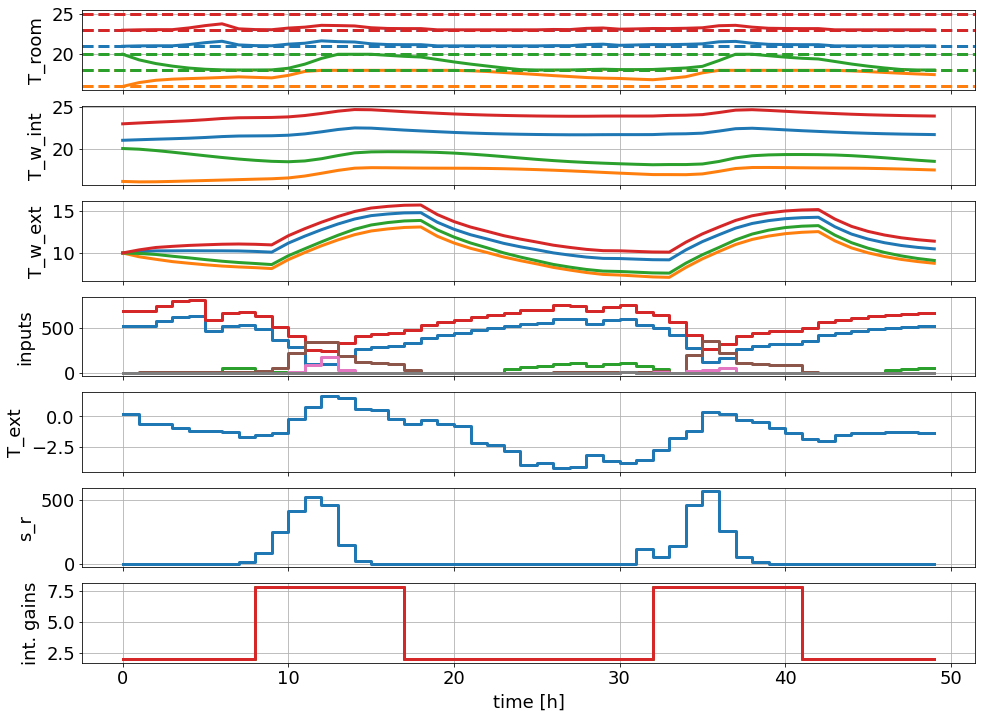

In [43]:
fig, ax = plt.subplots(7,1, sharex=True,figsize=(16,12))

# plot the states
ax[0].plot(simulator.data['_time'],simulator.data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle='--')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle='--')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(simulator.data['_time'],simulator.data['_x','T_w_int'])
ax[2].plot(simulator.data['_time'],simulator.data['_x','T_w_ext'])
ax[3].step(simulator.data['_time'],simulator.data['_u'])
ax[4].step(simulator.data['_time'],simulator.data['_tvp','T_ext'])
ax[5].step(simulator.data['_time'],simulator.data['_tvp','s_r'])
ax[6].step(simulator.data['_time'],simulator.data['_tvp','in_g'])
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[-1].set_xlabel('time [h]')

# Closed Loop approach

$
\min_{x_{\left[0:N\right]}^{s+},x_{\left[0:N\right]}^{s-},u_{\left[0:N-1\right]}^s,\forall s\in S} \quad \sum_{s=1}^{N_s}  \sum_{k=0}^{N-1} (\ell(x_k^{s+},u_k^s)+\ell(x_k^{s-},u_k^s))+V_f(x_{N}^{s+})+V_f(x_{N}^{s-})\\
\begin{align}
	\text{s.t}:\ &x_0^{s\pm}=x_0,\ \forall s \in S,\\
	&h(x_k^{\left[1:N_s\right]\pm})\preceq 0,\ \forall k\in\{1,...,N-1\}, \label{eq:Closed_Loop:subeq:dividing_RS}\\
	&x_k^{s\pm}\in X,\ \forall k\in\{1,...,N-1\},\ \forall s \in S,\\
	&x_N^{s\pm}\in X_f,\ \forall s \in S, \label{eq:Closed_Loop:subeq:terminal_Constr}\\
	&\begin{split}
	&x_{k+1}^{N_s+}\succeq f(x_k^{s\pm},u_k^s,p^{\pm})\succeq x_{k+1}^{1-},\\
	&\qquad \forall k\in\{0,...,N-1\},\ \forall s \in S,\label{eq:Closed_Loop:subeq:Bounding}
	\end{split}\\
	&u_0^0=u_0^s,\ \forall s \in S. \label{eq:Closed_Loop:subeq:In. Input Constr}
\end{align}
$

In [44]:
N=12

In [45]:
cuts=np.zeros((nx,1))
cuts[0:4]=1
#cuts[-4:]=1
ns=1 #Number of Subregions
for i in range(nx):
    ns*=(cuts[i]+1)
ns=int(ns[0])
print(ns)

16


In [46]:
opt_x_ro = struct_symSX([
    entry('x_min', shape=nx, repeat=[N+1,ns]),
    entry('x_max', shape=nx, repeat=[N+1,ns]),
    entry('delta',shape=(nx),repeat=[N,int(np.max(cuts))]), #This is an ancillary variable, 
    #making the optmization problem easier to formulate 
    #(corresponds to the offsets in each dimension of all subhyperrectangles)
    entry('u', shape=nu, repeat=[N,ns])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[N]),
    entry('p_max',shape=nd, repeat=[N])
])

In [47]:
lb_opt_x_ro = opt_x_ro(0)
ub_opt_x_ro = opt_x_ro(np.inf)

In [48]:
lb_opt_x_ro['x_min'] = lb_x
lb_opt_x_ro['x_max'] = lb_x
ub_opt_x_ro['x_min'] = ub_x
ub_opt_x_ro['x_max'] = ub_x


lb_opt_x_ro['delta',:] = np.zeros((nx,1))
ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u

In [49]:
J=0
g=[]
lb_g=[]
ub_g=[]
x_init_min=SX.sym('x_init_min',nx)
x_init_max=SX.sym('x_init_max',nx)
u_in = SX.sym('u_in', nu)
g.append(x_init_min-opt_x_ro['x_min',0,0])
g.append(x_init_max-opt_x_ro['x_max',0,-1])
lb_g.append(np.zeros((2*nx,1)))
ub_g.append(np.zeros((2*nx,1)))

for n in range(N):
    
    # This part here is basically describing the implicit offsets in h(x) for the lower left corner (delta) and the 
    # upper right corner (atled)
    atled=SX.sym('atled',nx,int(np.max(cuts)))
    for m in range(nx):
        for h in range(int(np.max(cuts))):
            if cuts[m]<=h:
                g.append(opt_x_ro['delta',n,h][m])            
                lb_g.append(0)
                ub_g.append(0)
            elif cuts[m]-1>h:
                g.append(opt_x_ro['delta',n,h+1][m]-opt_x_ro['delta',n,h][m])
                lb_g.append(0)
                ub_g.append(inf)
            if cuts[m]<=h:
                atled[m,h]=0
            else:
                atled[m,h]=opt_x_ro['x_max',n,-1][m]-opt_x_ro['x_min',n,0][m]-opt_x_ro['delta',n,h][m]
            if cuts[m]>h:   
                g.append(opt_x_ro['x_max',n,-1][m]-opt_x_ro['x_min',n,0][m]-opt_x_ro['delta',n,h][m])
                lb_g.append(0)
                ub_g.append(inf)


    # Still h(x). This part adds the offsets onto each subset
    for s in range(ns):
        count=np.zeros((nx,1)) # Some way of counting through all the sets in each dimension
        remainder=ns
        rest=s
        for l in range(nx):
            if cuts[l]>0:
                remainder/=(cuts[l]+1)
                count[l]=rest//remainder
                rest-=remainder*count[l]
        for k in range(nx):
            if count[k]==0 and count[k]==cuts[k]:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k])
                lb_g.append(0)
                ub_g.append(0)
            elif count[k]==0 and count[k]!=cuts[k]:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k]-atled[k,int(count[k])])
                lb_g.append(0)
                ub_g.append(0)
            elif count[k]==cuts[k] and count[k]!=0:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k]-opt_x_ro['delta',n,int(count[k]-1)][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k])
                lb_g.append(0)
                ub_g.append(0)
            else:
                g.append(opt_x_ro['x_min',n,s][k]-opt_x_ro['x_min',n,0][k]-opt_x_ro['delta',n,int(count[k]-1)][k])
                lb_g.append(0)
                ub_g.append(0)
                g.append(opt_x_ro['x_max',n,-1][k]-opt_x_ro['x_max',n,s][k]-atled[k,int(count[k])])
                lb_g.append(0)
                ub_g.append(0)


    for s in range(ns):
        # Propagate the corners of each subset
        x_next_plus = system(opt_x_ro['x_max',n,s], opt_x_ro['u',n,s],opt_p['p_max',n])
        x_next_minus = system(opt_x_ro['x_min',n,s], opt_x_ro['u',n,s],opt_p['p_min',n])
        # Constrain them to lie in the hyperrectangle spanned by opt_x_ro['x_max',n+1,-1] and opt_x_ro['x_min',n+1,0]
        g.append(opt_x_ro['x_max',n+1,-1]-x_next_plus)
        g.append(-opt_x_ro['x_min',n+1,0]+x_next_minus)
        lb_g.append(np.zeros((2*nx,1)))
        ub_g.append(inf*np.ones((2*nx,1)))
    

    
    g.append(opt_x_ro['x_max',n,-1]-opt_x_ro['x_min',n,0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(inf*np.ones((nx,1)))


    # Cost function
    for s in range(ns):
        if n>0:
            J += stage_cost_fcn(opt_x_ro['x_min',n,s], opt_x_ro['u',n,s],opt_x_ro['u',n-1,s])
            J += stage_cost_fcn(opt_x_ro['x_max',n,s], opt_x_ro['u',n,s],opt_x_ro['u',n-1,s])
        else:
            J += stage_cost_fcn(opt_x_ro['x_min',n,s], opt_x_ro['u',n,s],u_in)
            J += stage_cost_fcn(opt_x_ro['x_max',n,s], opt_x_ro['u',n,s],u_in)
for s in range(ns):
    J += terminal_cost_fcn(opt_x_ro['x_max', -1,s])
    J += terminal_cost_fcn(opt_x_ro['x_min', -1,s])
    g.append(opt_x_ro['u',0,s]-opt_x_ro['u', 0,0])
    lb_g.append(np.zeros((nu,1)))
    ub_g.append(np.zeros((nu,1)))


g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x_ro),'g':g, 'p':vertcat(x_init_max,x_init_min,u_in,opt_p)}
solver_mx_cut_bon_mpc = nlpsol('solver','ipopt',prob,{'ipopt':{'max_iter':3000}})

In [50]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

Vary the tvp_function for the different uncertainty realizations:

 - p_fun_var gives timevarying uniformly random values between the bounds, which are defined as:
 - p_fun_max gives the upper bound at time (t)
 - p_fun_min gives the lower bound at time (t)

In [51]:
simulator.set_tvp_fun(p_fun_var)
simulator.reset_history()
simulator.x0=x_0

C:\Users\smmzhein\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [52]:
tic=time.time()
opt_p_k=opt_p(0)
clc_HCB=np.zeros((N_sim,1))
cv_HCB=np.zeros((N_sim,1))
solution=[]
for i in range(N_sim):
    print(i)
    # 01 - Your code here!
    # solve optimization problem
    

    for k in range(N):
        opt_p_k['p_min',k]=vertcat(p_fun_min(k*dt+i*dt))
        opt_p_k['p_max',k]=vertcat(p_fun_max(k*dt+i*dt))

    # optionally: Warmstart the optimizer by passing the previous solution as an initial guess!
    if i>0:
        mpc_res = solver_mx_cut_bon_mpc(p=vertcat(x_0,x_0,u_k,opt_p_k), x0=opt_x_k, lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro)
    else:
        mpc_res = solver_mx_cut_bon_mpc(p=vertcat(x_0,x_0,0*np.ones((nu,1)),opt_p_k),lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro)
    # 01


    # 02 - Your code here!
    # Extract the control input
    opt_x_k = opt_x_ro(mpc_res['x'])
    u_k = opt_x_k['u',0,0]
    # 02
    solution.append(opt_x_k)
    if i>0:
        clc_HCB[i]=clc_HCB[i-1]+stage_cost_fcn(x_0,u_k,res_u_mpc[-1])
    else:
        clc_HCB[i]=stage_cost_fcn(x_0,u_k,u0)
    # calculate Constraint Violation
    cv_HCB[i]=np.sum([np.max([lb_x[l]-x_0[l],0]) for l in range(nx)])+np.sum([np.max([x_0[l]-ub_x[l],0]) for l in range(nx)])

    # 03 - Your code here!
    # simulate the system
    x_next = simulator.make_step(u_k)
    # 03
    
    # 04 - Your code here!
    # Update the initial state
    x_0 = x_next
    #p_0=simulator.data['_tvp'][-1,:]
    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
    
toc_HCB=time.time()-tic    

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10152
Number of nonzeros in inequality constraint Jacobian.:    31152
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     6672
                     variables with only lower bounds:      144
                variables with lower and upper bounds:     3200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4856
Total number of inequality constraints...............:     4800
        inequality constraints with only lower bounds:     4800
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

  79 1.0633077e+004 1.86e+001 2.76e+003  -1.0 6.69e+002 -18.8 7.47e-003 4.52e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.0833708e+004 1.85e+001 2.77e+003  -1.0 6.66e+002 -19.3 5.78e-003 1.02e-003h  1
  81 1.1175754e+004 1.85e+001 2.78e+003  -1.0 6.65e+002 -19.8 6.76e-003 1.74e-003h  1
  82 1.1960876e+004 1.84e+001 2.78e+003  -1.0 6.62e+002 -19.1 7.12e-003 4.01e-003h  1
  83 1.2280703e+004 1.84e+001 2.78e+003  -1.0 6.60e+002 -19.6 2.33e-003 1.57e-003h  1
  84 1.2919787e+004 1.84e+001 2.78e+003  -1.0 6.57e+002 -19.1 6.67e-003 3.15e-003h  1
  85 1.3996529e+004 1.83e+001 2.77e+003  -1.0 6.51e+002 -19.6 6.41e-003 5.14e-003h  1
  86 1.4389434e+004 1.82e+001 2.77e+003  -1.0 6.42e+002 -19.1 6.66e-003 1.82e-003h  1
  87 1.5112651e+004 1.82e+001 2.76e+003  -1.0 6.50e+002 -19.6 6.62e-003 3.28e-003h  1
  88 1.5168639e+004 1.82e+001 2.77e+003  -1.0 6.40e+002 -19.1 6.94e-003 2.56e-004h  1
  89 1.6222979e+004 1.81e+001 2.76e+003  -1.0 6.47e+002 -19

 168 1.9198174e+005 7.80e+000 2.29e+003  -1.0 3.11e+002 -19.1 2.45e-002 1.08e-003h  1
 169 1.9988015e+005 7.36e+000 2.11e+003  -1.0 3.10e+002 -19.6 1.16e-002 5.61e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 2.0015459e+005 7.35e+000 2.11e+003  -1.0 2.93e+002 -19.1 1.20e-002 2.06e-003h  1
 171 2.0151562e+005 7.27e+000 2.08e+003  -1.0 2.93e+002 -19.6 5.23e-003 1.02e-002h  1
 172 2.0234092e+005 7.23e+000 2.08e+003  -1.0 2.90e+002 -19.1 3.46e-002 6.25e-003h  1
 173 2.0723751e+005 6.96e+000 1.99e+003  -1.0 2.87e+002 -19.6 2.62e-003 3.72e-002h  1
 174 2.1266120e+005 6.66e+000 1.90e+003  -1.0 2.77e+002 -19.1 2.19e-002 4.28e-002h  1
 175 2.1290068e+005 6.65e+000 1.90e+003  -1.0 2.69e+002 -19.6 2.35e-002 1.98e-003h  1
 176 2.1550266e+005 6.51e+000 1.86e+003  -1.0 2.68e+002 -19.1 2.07e-002 2.15e-002h  1
 177 2.1670167e+005 6.44e+000 1.84e+003  -1.0 2.62e+002 -19.6 1.84e-002 1.01e-002h  1
 178 2.1860144e+005 6.34e+000 1.81e+003  -1.0 2.59e+002 -19

 257 3.4259283e+005 7.04e-007 2.83e-008  -2.5 3.69e+003 -19.6 1.00e+000 1.00e+000f  1
 258 3.4258375e+005 1.72e-007 1.38e+000  -5.7 4.07e-001 -19.1 9.13e-001 9.16e-001f  1
 259 3.4258294e+005 2.22e-007 1.66e+001  -5.7 1.88e-001 -19.6 1.00e+000 9.74e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 3.4258292e+005 2.28e-007 3.18e-011  -5.7 2.51e+001 -19.1 1.00e+000 1.00e+000f  1
 261 3.4258292e+005 2.28e-007 1.27e+003  -8.6 2.91e-004  -9.3 2.65e-001 2.84e-002h  1
 262 3.4258292e+005 2.28e-007 2.92e+003  -8.6 2.83e-004  -8.8 7.90e-001 2.53e-001f  1
 263 3.4258292e+005 2.25e-007 1.67e+003  -8.6 2.11e-004  -9.3 2.98e-001 4.27e-001f  1
 264 3.4258292e+005 2.20e-007 6.42e+002  -8.6 1.21e-004  -5.3 3.02e-001 6.15e-001f  1
 265 3.4258291e+005 2.17e-007 8.80e+002  -8.6 4.68e-005  -5.7 3.12e-001 5.19e-001f  1
 266 3.4258291e+005 2.14e-007 2.21e+003  -8.6 2.27e-005  -5.3 1.32e-001 7.83e-001f  1
 267 3.4258291e+005 2.13e-007 1.38e+003  -8.6 5.15e-006  -4

 345r3.4258291e+005 1.42e-007 1.00e+003  -6.9 1.90e-003    -  1.31e-003 2.10e-003f  1
 346r3.4258291e+005 1.43e-007 9.97e+002  -6.9 7.30e-004    -  3.07e-003 3.00e-003f  1
 347r3.4258291e+005 1.45e-007 9.88e+002  -6.9 2.32e-004    -  1.72e-002 6.36e-003f  1
 348r3.4258291e+005 1.47e-007 9.67e+002  -6.9 7.95e-005    -  7.69e-002 2.09e-002f  1
 349r3.4258291e+005 1.47e-007 9.32e+002  -6.9 4.32e-005    -  1.08e-001 3.62e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r3.4258291e+005 1.46e-007 8.34e+002  -6.9 4.53e-005    -  1.63e-001 1.05e-001f  1
 351r3.4258291e+005 1.41e-007 5.82e+002  -6.9 4.67e-005    -  2.06e-001 3.32e-001f  1
 352r3.4258291e+005 1.40e-007 5.45e+002  -6.9 4.03e-005    -  6.73e-002 1.93e-001h  1
 353r3.4258291e+005 1.40e-007 5.34e+002  -6.9 3.67e-005    -  5.63e-003 2.40e-002h  1
 354r3.4258291e+005 1.40e-007 5.26e+002  -6.9 3.64e-005    -  3.69e-001 2.43e-002h  1
 355r3.4258291e+005 1.20e-007 5.19e+002  -6.9 5.05e-005    

  19 3.2722223e+005 8.39e-001 2.00e+003  -1.0 1.90e+002  -8.8 5.00e-002 1.92e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.2739600e+005 8.24e-001 2.10e+003  -1.0 2.27e+002  -9.3 2.50e-002 1.73e-002h  1
  21 3.2762678e+005 8.07e-001 2.13e+003  -1.0 2.34e+002  -9.7 2.54e-002 2.10e-002h  1
  22 3.2774020e+005 8.00e-001 2.36e+003  -1.0 2.30e+002 -10.2 2.00e-002 8.47e-003h  1
  23 3.2865483e+005 7.43e-001 1.08e+003  -1.0 2.42e+002 -10.7 2.24e-003 7.22e-002h  1
  24 3.2873840e+005 7.38e-001 1.40e+003  -1.0 2.00e+002 -11.2 3.16e-002 6.39e-003h  1
  25 3.2923539e+005 7.09e-001 1.34e+003  -1.0 2.01e+002 -11.6 3.90e-002 3.92e-002h  1
  26 3.2949399e+005 6.95e-001 1.91e+003  -1.0 1.83e+002 -12.1 7.64e-002 1.90e-002h  1
  27 3.3011156e+005 6.64e-001 2.24e+003  -1.0 1.85e+002 -12.6 9.52e-002 4.53e-002h  1
  28 3.3036037e+005 6.52e-001 2.41e+003  -1.0 1.84e+002 -13.1 5.34e-002 1.84e-002h  1
  29 3.3050552e+005 6.45e-001 2.46e+003  -1.0 1.59e+002 -13

 107 3.4898580e+005 1.00e-008 1.59e+002  -9.0 3.77e-008  -5.1 9.98e-001 1.25e-001h  4
 108 3.4898580e+005 1.00e-008 1.47e+002  -9.0 5.76e-008  -4.7 4.64e-001 1.25e-001h  4
 109 3.4898580e+005 1.00e-008 1.82e+002  -9.0 4.41e-008  -5.1 1.00e+000 1.22e-004h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 3.4898580e+005 1.00e-008 3.92e+001  -9.0 5.37e-008  -4.7 7.85e-001 7.85e-001s 22
 111 3.4898580e+005 1.00e-008 3.61e+001  -9.0 7.61e-008  -5.2 7.72e-002 7.72e-002s 22
 112 3.4898580e+005 1.00e-008 1.54e+002  -9.0 2.91e-007  -4.8 8.06e-001 0.00e+000S 22
 113 3.4898580e+005 1.00e-008 2.78e+000  -9.0 9.62e-008  -5.2 9.02e-001 1.00e+000h  1
 114 3.4898580e+005 1.00e-008 1.15e+002  -9.0 9.69e-008  -4.8 1.00e+000 3.67e-001h  1
 115 3.4898580e+005 1.00e-008 6.48e-012  -9.0 1.15e-007  -5.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:  3.4898580003889

  53 3.5023377e+005 1.67e-001 1.31e+003  -1.0 2.44e+001 -19.1 3.41e-002 6.23e-002h  1
  54 3.5053835e+005 1.58e-001 1.29e+003  -1.0 2.70e+001 -19.6 1.75e-001 5.36e-002h  1
  55 3.5067434e+005 1.54e-001 1.26e+003  -1.0 1.94e+002 -19.1 1.07e-002 2.52e-002h  1
  56 3.5083552e+005 1.49e-001 1.22e+003  -1.0 1.58e+002 -19.6 1.86e-002 3.03e-002h  1
  57 3.5234675e+005 1.06e-001 7.57e+002  -1.0 3.89e+001 -19.1 8.47e-003 2.90e-001h  1
  58 3.5321070e+005 8.10e-002 6.85e+002  -1.0 4.00e+001 -19.6 6.34e-002 2.34e-001h  1
  59 3.5376767e+005 6.50e-002 5.36e+002  -1.0 3.85e+001 -19.1 5.08e-001 1.96e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5469241e+005 3.85e-002 2.87e+002  -1.0 4.40e+001 -19.6 2.58e-001 4.05e-001h  1
  61 3.5486734e+005 3.36e-002 7.36e+002  -1.0 1.55e+001 -19.1 7.63e-001 1.27e-001h  1
  62 3.5513877e+005 2.59e-002 6.08e+002  -1.0 1.95e+001 -19.6 2.80e-001 2.26e-001h  1
  63 3.5540021e+005 1.85e-002 9.40e+002  -1.0 6.41e+000 -19

   9 3.4149451e+005 1.02e+000 1.70e+002  -1.0 7.05e+002  -4.0 1.78e-002 3.27e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4071018e+005 1.01e+000 1.67e+002  -1.0 7.18e+002  -4.5 4.87e-003 5.62e-003f  1
  11 3.3988120e+005 1.01e+000 1.80e+002  -1.0 7.16e+002  -5.0 9.99e-003 6.16e-003f  1
  12 3.3697540e+005 9.83e-001 1.46e+002  -1.0 7.00e+002  -5.4 1.55e-002 2.34e-002f  1
  13 3.3633741e+005 9.76e-001 2.29e+002  -1.0 5.85e+002  -5.9 2.69e-002 6.82e-003f  1
  14 3.3578632e+005 9.68e-001 2.64e+002  -1.0 5.83e+002  -6.4 1.63e-002 8.07e-003f  1
  15 3.3476880e+005 9.50e-001 1.83e+002  -1.0 5.80e+002  -6.9 2.15e-003 1.89e-002f  1
  16 3.3430572e+005 9.40e-001 2.20e+002  -1.0 5.68e+002  -7.4 1.98e-002 1.13e-002f  1
  17 3.3364375e+005 9.21e-001 2.80e+002  -1.0 5.61e+002  -7.8 3.43e-002 2.04e-002f  1
  18 3.3339123e+005 9.10e-001 4.01e+002  -1.0 5.44e+002  -8.3 3.91e-002 1.21e-002f  1
  19 3.3279186e+005 8.76e-001 5.66e+002  -1.0 5.30e+002  -8

  98 3.5817307e+005 1.00e-008 1.40e+002  -8.6 4.43e-008  -4.9 1.00e+000 7.81e-003f  8
  99 3.5817307e+005 1.00e-008 3.02e-001  -8.6 1.23e-008  -4.5 9.78e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.5817307e+005 1.00e-008 3.30e+001  -8.6 5.36e-009  -5.0 7.67e-001 1.00e+000h  1
 101 3.5817307e+005 1.00e-008 6.82e+001  -8.6 6.60e-007  -5.5 1.00e+000 5.18e-001h  1
 102 3.5817307e+005 1.00e-008 1.40e+002  -8.6 1.25e-007  -5.0 1.00e+000 7.81e-003f  8
 103 3.5817307e+005 1.97e-008 2.69e+001  -8.6 1.18e-007  -5.5 8.11e-001 1.00e+000H  1
 104 3.5817307e+005 1.00e-008 1.73e+001  -8.6 6.79e-008  -5.1 8.97e-001 1.00e+000h  1
 105 3.5817307e+005 1.48e-008 6.01e+001  -8.6 1.08e-008  -5.6 8.00e-001 1.00e+000H  1
 106 3.5817307e+005 1.00e-008 6.26e-012  -8.6 9.99e-008  -5.1 1.00e+000 1.00e+000h  1
 107 3.5817307e+005 1.00e-008 4.80e+001  -9.0 1.04e-007  -4.7 7.06e-001 9.70e-001h  1
 108 3.5817307e+005 1.00e-008 3.96e+001  -9.0 2.98e-007  -5

  38 3.3570655e+005 5.51e-001 1.86e+003  -1.0 1.56e+002 -17.8 1.64e-002 7.67e-002h  1
  39 3.3603813e+005 5.42e-001 1.88e+003  -1.0 1.45e+002 -18.3 2.47e-002 1.74e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.3629675e+005 5.35e-001 2.41e+003  -1.0 1.38e+002 -18.8 1.08e-001 1.33e-002h  1
  41 3.3707479e+005 5.14e-001 2.34e+003  -1.0 1.35e+002 -19.3 4.20e-002 3.85e-002h  1
  42 3.3780666e+005 4.95e-001 2.16e+003  -1.0 1.35e+002 -19.8 1.78e-002 3.65e-002h  1
  43 3.3925068e+005 4.58e-001 1.75e+003  -1.0 1.36e+002 -19.1 2.38e-002 7.52e-002h  1
  44 3.4053043e+005 4.25e-001 1.45e+003  -1.0 1.33e+002 -19.6 3.73e-002 7.27e-002h  1
  45 3.4055934e+005 4.24e-001 1.64e+003  -1.0 1.16e+002 -19.1 4.23e-002 1.72e-003h  1
  46 3.4111034e+005 4.10e-001 1.46e+003  -1.0 9.96e+001 -19.6 4.31e-003 3.19e-002h  1
  47 3.4139560e+005 4.04e-001 1.89e+003  -1.0 8.54e+001 -19.1 1.23e-001 1.67e-002h  1
  48 3.4267617e+005 3.73e-001 1.59e+003  -1.0 8.56e+001 -19

   7 3.4465217e+005 1.03e+000 8.22e+001  -1.0 5.61e+002  -3.1 2.04e-002 2.04e-002f  1
   8 3.4281343e+005 1.02e+000 1.18e+002  -1.0 6.53e+002  -3.5 1.89e-002 9.39e-003f  1
   9 3.4226030e+005 1.02e+000 1.19e+002  -1.0 6.91e+002  -4.0 3.40e-003 3.05e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4105798e+005 1.01e+000 1.38e+002  -1.0 7.02e+002  -4.5 1.20e-002 6.79e-003f  1
  11 3.3930167e+005 1.00e+000 1.02e+002  -1.0 7.00e+002  -5.0 1.29e-003 1.07e-002f  1
  12 3.3894143e+005 1.00e+000 1.55e+002  -1.0 6.86e+002  -5.4 1.51e-002 2.40e-003f  1
  13 3.3649033e+005 9.82e-001 1.42e+002  -1.0 6.63e+002  -5.9 1.59e-002 1.77e-002f  1
  14 3.3536503e+005 9.72e-001 1.73e+002  -1.0 5.66e+002  -6.4 1.47e-002 1.03e-002f  1
  15 3.3471276e+005 9.65e-001 1.40e+002  -1.0 5.60e+002  -6.9 3.97e-003 7.70e-003f  1
  16 3.3387182e+005 9.54e-001 1.47e+002  -1.0 5.54e+002  -7.4 1.28e-002 1.16e-002f  1
  17 3.3318327e+005 9.42e-001 1.35e+002  -1.0 5.45e+002  -7

  95 3.5857503e+005 9.99e-009 5.14e+001  -8.6 1.76e-003  -3.7 1.00e+000 8.23e-001f  1
  96 3.5857503e+005 1.00e-008 2.42e+001  -8.6 3.18e-004  -4.2 1.00e+000 9.17e-001f  1
  97 3.5857503e+005 1.00e-008 3.83e+001  -8.6 3.59e-005  -4.6 8.57e-001 1.00e+000f  1
  98 3.5857503e+005 1.00e-008 1.70e+002  -8.6 2.89e-006  -5.1 4.85e-001 1.00e+000h  1
  99 3.5857503e+005 1.00e-008 2.92e+002  -8.6 8.32e-007  -4.7 3.68e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.5857503e+005 1.00e-008 4.81e+002  -8.6 1.34e-006  -5.2 1.74e-001 1.00e+000h  1
 101 3.5857503e+005 1.00e-008 6.49e+002  -8.6 1.52e-006  -4.7 1.59e-001 1.00e+000h  1
 102 3.5857503e+005 1.00e-008 5.21e+002  -8.6 2.09e-006  -5.2 1.35e-001 3.05e-005h 16
 103 3.5857503e+005 1.00e-008 6.67e+002  -8.6 2.08e-006  -4.8 1.80e-001 1.00e+000h  1
 104 3.5857503e+005 1.00e-008 6.02e+002  -8.6 8.57e-006  -5.3 6.95e-002 6.57e-003h  4
 105 3.5857503e+005 1.00e-008 4.05e+002  -8.6 3.14e-006  -5

  35 3.3103498e+005 6.72e-001 2.70e+003  -1.0 2.19e+002 -16.4 2.48e-002 5.90e-003h  1
  36 3.3202306e+005 6.35e-001 2.20e+003  -1.0 1.61e+002 -16.9 5.27e-004 5.58e-002h  1
  37 3.3251031e+005 6.16e-001 2.21e+003  -1.0 2.16e+002 -17.4 4.21e-002 2.94e-002h  1
  38 3.3268735e+005 6.10e-001 2.53e+003  -1.0 3.07e+002 -17.8 6.90e-002 1.03e-002h  1
  39 3.3319786e+005 5.92e-001 2.48e+003  -1.0 3.07e+002 -18.3 3.29e-002 2.85e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.3383292e+005 5.71e-001 2.40e+003  -1.0 1.52e+002 -18.8 3.59e-002 3.54e-002h  1
  41 3.3444284e+005 5.52e-001 2.33e+003  -1.0 1.50e+002 -19.3 3.66e-002 3.39e-002h  1
  42 3.3448088e+005 5.51e-001 2.44e+003  -1.0 1.33e+002 -19.8 2.67e-002 1.98e-003h  1
  43 3.3462334e+005 5.47e-001 2.42e+003  -1.0 1.95e+002 -19.1 5.65e-003 7.04e-003h  1
  44 3.3496157e+005 5.37e-001 2.30e+003  -1.0 1.29e+002 -19.6 6.37e-004 1.77e-002h  1
  45 3.3510729e+005 5.33e-001 2.30e+003  -1.0 1.23e+002 -19

   3 3.5417755e+005 1.11e+000 1.73e+001  -1.0 2.93e+001  -1.1 2.75e-002 1.91e-002f  1
   4 3.5356356e+005 1.10e+000 1.95e+001  -1.0 8.78e+001  -1.6 1.28e-002 8.77e-003f  1
   5 3.5110534e+005 1.08e+000 3.78e+001  -1.0 2.07e+002  -2.1 2.84e-002 1.73e-002f  1
   6 3.4830291e+005 1.07e+000 8.09e+001  -1.0 3.63e+002  -2.6 2.77e-002 1.33e-002f  1
   7 3.4326179e+005 1.05e+000 1.12e+002  -1.0 5.18e+002  -3.1 2.96e-002 2.08e-002f  1
   8 3.4111621e+005 1.04e+000 1.35e+002  -1.0 6.19e+002  -3.5 1.50e-002 9.38e-003f  1
   9 3.4002821e+005 1.03e+000 1.71e+002  -1.0 6.57e+002  -4.0 1.31e-002 5.06e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3816954e+005 1.02e+000 2.32e+002  -1.0 6.70e+002  -4.5 2.22e-002 9.22e-003f  1
  11 3.3643744e+005 1.01e+000 2.23e+002  -1.0 6.71e+002  -5.0 8.49e-003 9.87e-003f  1
  12 3.3546349e+005 1.01e+000 2.77e+002  -1.0 6.57e+002  -5.4 1.64e-002 6.19e-003f  1
  13 3.3238958e+005 9.86e-001 1.71e+002  -1.0 6.23e+002  -5

  91 3.5272575e+005 1.00e-008 7.72e+002  -8.6 1.74e-006  -4.8 2.08e-001 1.00e+000h  1
  92 3.5272575e+005 1.00e-008 9.06e+002  -8.6 1.45e-006  -5.3 1.46e-001 1.00e+000h  1
  93 3.5272575e+005 1.07e-008 9.23e+002  -8.6 1.03e-006  -4.8 2.28e-001 1.00e+000h  1
  94 3.5272575e+005 1.00e-008 1.17e+003  -8.6 3.70e-007  -4.4 2.24e-001 1.00e+000H  1
  95 3.5272575e+005 1.00e-008 1.33e+003  -8.6 3.28e-006  -4.9 8.45e-002 9.98e-001h  1
  96 3.5272575e+005 1.00e-008 1.12e+003  -8.6 2.61e-006  -5.4 1.33e-001 1.56e-002f  7
  97 3.5272575e+005 1.00e-008 1.10e+003  -8.6 2.69e-006  -4.9 5.35e-002 3.81e-001h  1
  98 3.5272575e+005 1.00e-008 6.24e+002  -8.6 3.12e-006  -5.4 1.51e-002 5.08e-001f  1
  99 3.5272575e+005 1.00e-008 3.81e+002  -8.6 8.38e-007  -5.0 4.14e-001 3.51e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.5272575e+005 1.00e-008 3.80e+002  -8.6 5.55e-007  -4.6 3.58e-001 1.01e-003f  9
 101 3.5272575e+005 1.00e-008 1.71e+002  -8.6 5.54e-007  -5

  47 3.3004911e+005 4.24e-001 1.33e+003  -1.0 9.22e+001 -19.1 8.52e-003 6.41e-003h  1
  48 3.3029982e+005 4.17e-001 1.30e+003  -1.0 1.39e+002 -19.6 1.26e-002 1.66e-002h  1
  49 3.3104337e+005 3.96e-001 1.15e+003  -1.0 1.19e+002 -19.1 1.34e-002 4.87e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.3118526e+005 3.93e-001 1.16e+003  -1.0 8.27e+001 -19.6 1.77e-002 9.33e-003h  1
  51 3.3124538e+005 3.91e-001 1.21e+003  -1.0 2.59e+002 -19.1 2.81e-002 3.92e-003h  1
  52 3.3202756e+005 3.71e-001 1.09e+003  -1.0 2.86e+002 -19.6 2.43e-002 5.07e-002h  1
  53 3.3239678e+005 3.62e-001 1.06e+003  -1.0 2.64e+002 -19.1 2.24e-002 2.50e-002h  1
  54 3.3295046e+005 3.48e-001 9.57e+002  -1.0 2.75e+002 -19.6 1.05e-002 3.84e-002h  1
  55 3.3296655e+005 3.48e-001 9.94e+002  -1.0 2.94e+002 -19.1 1.92e-002 1.15e-003h  1
  56 3.3340488e+005 3.37e-001 9.05e+002  -1.0 3.01e+002 -19.6 3.05e-003 3.13e-002h  1
  57 3.3379329e+005 3.27e-001 8.42e+002  -1.0 2.87e+002 -19

   3 3.4415319e+005 1.10e+000 6.01e+000  -1.0 2.87e+001  -1.1 1.33e-002 2.78e-002f  1
   4 3.4209922e+005 1.07e+000 6.43e+000  -1.0 7.65e+001  -1.6 3.04e-002 2.89e-002f  1
   5 3.3861065e+005 1.04e+000 7.09e+001  -1.0 1.87e+002  -2.1 4.48e-002 2.46e-002f  1
   6 3.3663216e+005 1.03e+000 2.15e+002  -1.0 3.59e+002  -2.6 3.65e-002 9.58e-003f  1
   7 3.3489731e+005 1.03e+000 2.58e+002  -1.0 5.12e+002  -3.1 1.39e-002 7.36e-003f  1
   8 3.2961053e+005 1.01e+000 2.14e+002  -1.0 5.99e+002  -3.5 1.66e-002 2.17e-002f  1
   9 3.2710760e+005 9.94e-001 3.54e+002  -1.0 6.38e+002  -4.0 2.91e-002 1.17e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2496463e+005 9.82e-001 4.58e+002  -1.0 6.41e+002  -4.5 2.44e-002 1.15e-002f  1
  11 3.2246461e+005 9.67e-001 4.01e+002  -1.0 6.02e+002  -5.0 9.47e-003 1.56e-002f  1
  12 3.2101440e+005 9.57e-001 5.74e+002  -1.0 5.50e+002  -5.4 3.23e-002 1.06e-002f  1
  13 3.1937105e+005 9.41e-001 7.59e+002  -1.0 5.42e+002  -5

  91 3.3926577e+005 1.00e-008 1.90e+001  -8.6 2.16e-006  -5.0 3.86e-001 7.81e-003f  8
  92 3.3926577e+005 1.00e-008 1.63e+001  -8.6 2.14e-006  -5.5 1.68e-001 1.11e-001h  2
  93 3.3926577e+005 1.00e-008 5.37e+001  -8.6 1.78e-006  -5.1 6.32e-001 4.46e-001h  1
  94 3.3926577e+005 2.46e-008 7.18e+001  -8.6 1.25e-003  -5.6 1.48e-001 5.34e-001F  1
  95 3.3926577e+005 1.00e-008 2.53e+002  -8.6 4.82e-007  -5.1 2.97e-001 1.00e+000f  1
  96 3.3926577e+005 1.00e-008 4.72e+002  -8.6 1.09e-006  -4.7 1.27e-001 1.00e+000h  1
  97 3.3926577e+005 1.00e-008 2.74e+002  -8.6 2.92e-007  -5.2 6.39e-001 1.00e+000h  1
  98 3.3926577e+005 1.00e-008 4.83e+002  -8.6 2.11e-007  -4.8 1.36e-001 1.00e+000h  1
  99 3.3926577e+005 1.00e-008 4.84e+002  -8.6 2.78e-007  -5.2 8.57e-002 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.3926577e+005 1.00e-008 3.29e+002  -8.6 3.00e-007  -4.8 5.52e-001 1.00e+000h  1
 101 3.3926577e+005 1.00e-008 3.10e+002  -8.6 2.04e-006  -5

  36 3.1369458e+005 2.64e-001 2.14e+003  -1.0 8.13e+001 -16.9 5.40e-002 8.13e-003h  1
  37 3.1442343e+005 2.48e-001 1.89e+003  -1.0 9.09e+001 -17.4 4.42e-003 5.86e-002h  1
  38 3.1473667e+005 2.41e-001 1.85e+003  -1.0 9.44e+001 -17.8 3.04e-002 2.73e-002h  1
  39 3.1524508e+005 2.30e-001 1.77e+003  -1.0 1.26e+002 -18.3 4.81e-002 4.57e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.1617749e+005 2.10e-001 1.52e+003  -1.0 1.90e+002 -18.8 3.86e-002 8.73e-002h  1
  41 3.1622818e+005 2.09e-001 1.56e+003  -1.0 1.59e+002 -19.3 2.92e-002 5.04e-003h  1
  42 3.1647988e+005 2.04e-001 1.58e+003  -1.0 1.18e+002 -19.8 5.77e-002 2.44e-002h  1
  43 3.1660933e+005 2.02e-001 1.55e+003  -1.0 2.02e+002 -19.1 5.15e-003 1.08e-002h  1
  44 3.1708776e+005 1.93e-001 1.41e+003  -1.0 6.93e+001 -19.6 1.90e-003 4.53e-002h  1
  45 3.1714879e+005 1.92e-001 1.45e+003  -1.0 6.70e+001 -19.1 3.53e-002 5.96e-003h  1
  46 3.1772504e+005 1.81e-001 1.49e+003  -1.0 6.60e+001 -19

   7 3.1390924e+005 7.59e-001 2.51e+002  -1.0 5.32e+002  -3.1 1.30e-002 1.34e-002f  1
   8 3.1203790e+005 7.50e-001 3.29e+002  -1.0 6.28e+002  -3.5 2.10e-002 1.13e-002f  1
   9 3.0979251e+005 7.39e-001 3.30e+002  -1.0 6.48e+002  -4.0 1.60e-002 1.52e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0826546e+005 7.29e-001 4.54e+002  -1.0 5.92e+002  -4.5 2.79e-002 1.25e-002f  1
  11 3.0703791e+005 7.20e-001 3.80e+002  -1.0 5.87e+002  -5.0 4.26e-003 1.27e-002f  1
  12 3.0657367e+005 7.16e-001 5.10e+002  -1.0 5.78e+002  -5.4 2.22e-002 5.70e-003f  1
  13 3.0523605e+005 7.01e-001 6.03e+002  -1.0 5.70e+002  -5.9 3.36e-002 2.05e-002f  1
  14 3.0433289e+005 6.87e-001 6.75e+002  -1.0 5.43e+002  -6.4 3.16e-002 2.04e-002f  1
  15 3.0349739e+005 6.69e-001 8.66e+002  -1.0 5.04e+002  -6.9 5.49e-002 2.66e-002f  1
  16 3.0300608e+005 6.52e-001 9.91e+002  -1.0 4.22e+002  -7.4 4.61e-002 2.49e-002f  1
  17 3.0272014e+005 6.36e-001 1.25e+003  -1.0 3.46e+002  -7

  95 3.2222616e+005 1.00e-008 5.46e+002  -8.6 3.73e-006  -4.9 5.65e-002 3.78e-001h  1
  96 3.2222616e+005 1.00e-008 4.46e+002  -8.6 4.19e-006  -5.4 5.43e-001 1.85e-001f  1
  97 3.2222616e+005 1.00e-008 3.79e+002  -8.6 2.76e-006  -5.0 2.52e-001 1.48e-001f  1
  98 3.2222616e+005 1.00e-008 2.97e+002  -8.6 1.59e-006  -5.5 1.00e+000 2.18e-001f  1
  99 3.2222616e+005 1.00e-008 1.54e+002  -8.6 5.95e-007  -5.0 1.00e+000 4.81e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.2222616e+005 1.00e-008 1.52e+002  -8.6 1.01e-007  -5.5 1.00e+000 1.22e-002f  7
 101 3.2222616e+005 1.00e-008 2.86e+000  -8.6 1.06e-007  -5.1 1.00e+000 9.81e-001h  1
 102 3.2222616e+005 1.00e-008 1.41e+002  -8.6 2.99e-007  -5.6 1.00e+000 1.95e-003f 10
 103 3.2222616e+005 1.00e-008 6.15e-012  -8.6 2.92e-007  -5.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Objective...............:  3.2222616310063

  52 3.1758124e+005 1.00e-008 3.64e+001  -8.6 1.99e-005  -4.8 8.59e-001 1.00e+000f  1
  53 3.1758124e+005 2.17e-008 4.14e+002  -8.6 5.84e-005  -5.3 3.31e-001 1.00e+000H  1
  54 3.1758124e+005 1.00e-008 6.32e+002  -8.6 2.17e-005  -4.8 9.79e-002 1.00e+000h  1
In iteration 54, 1 Slack too small, adjusting variable bound
  55 3.1758124e+005 1.00e-008 4.55e+002  -8.6 6.37e-005  -5.3 2.84e-001 2.94e-001h  1
In iteration 55, 1 Slack too small, adjusting variable bound
  56 3.1758124e+005 1.00e-008 3.91e+002  -8.6 2.41e-005  -4.9 1.37e-001 1.31e-001h  1
In iteration 56, 1 Slack too small, adjusting variable bound
  57 3.1758124e+005 1.00e-008 3.93e+002  -8.6 7.09e-005  -5.4 1.25e-001 3.04e-001h  1
In iteration 57, 1 Slack too small, adjusting variable bound
  58 3.1758124e+005 1.00e-008 2.67e+002  -8.6 2.68e-005  -4.9 3.94e-001 4.94e-001h  1
  59 3.1758124e+005 1.00e-008 4.12e+002  -8.6 7.85e-005  -5.4 7.41e-002 6.54e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du 

  38 3.0851368e+005 6.47e-002 7.52e+002  -1.0 1.74e+001 -17.8 1.94e-001 2.65e-003h  1
  39 3.0860095e+005 6.16e-002 7.40e+002  -1.0 1.74e+001 -18.3 5.73e-002 4.68e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.0867621e+005 5.91e-002 1.06e+003  -1.0 1.66e+001 -18.8 1.03e-001 4.05e-002h  1
  41 3.0965089e+005 2.74e-002 5.12e+002  -1.0 1.60e+001 -19.3 1.37e-002 5.36e-001h  1
  42 3.1013352e+005 1.16e-002 6.69e+002  -1.0 7.55e+000 -19.8 1.90e-001 5.76e-001h  1
  43 3.1019797e+005 9.52e-003 2.41e+003  -1.0 3.24e+000 -19.1 7.32e-001 1.81e-001h  1
  44 3.1048778e+005 8.93e-005 2.11e+001  -1.0 2.67e+000 -19.6 9.91e-001 9.91e-001h  1
  45 3.1048996e+005 3.29e-005 1.62e+003  -1.0 1.02e-001 -19.1 1.00e+000 7.41e-001f  1
  46 3.1049068e+005 1.26e-005 1.00e-006  -1.0 7.04e-002 -19.6 1.00e+000 1.00e+000h  1
  47 3.1029565e+005 5.76e-006 1.98e+001  -2.5 3.37e+000 -19.1 4.32e-001 5.55e-001f  1
  48 3.1016869e+005 1.18e-006 1.28e+000  -2.5 1.30e+000 -19

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.9808664e+005 9.10e-001 1.69e+003  -1.0 4.51e+002  -4.5 4.50e-002 2.98e-002f  1
  11 2.9739028e+005 8.67e-001 1.32e+003  -1.0 3.93e+002  -5.0 7.27e-004 4.65e-002f  1
  12 2.9716881e+005 8.52e-001 1.39e+003  -1.0 5.03e+002  -5.4 3.19e-002 1.76e-002f  1
  13 2.9705904e+005 8.36e-001 1.62e+003  -1.0 2.91e+002  -5.9 6.00e-002 1.89e-002f  1
  14 2.9692376e+005 7.89e-001 1.30e+003  -1.0 2.60e+002  -6.4 1.71e-002 5.63e-002f  1
  15 2.9694378e+005 7.69e-001 1.81e+003  -1.0 2.29e+002  -6.9 1.19e-001 2.48e-002h  1
  16 2.9720570e+005 7.42e-001 2.30e+003  -1.0 1.92e+002  -7.4 1.44e-001 3.58e-002h  1
  17 2.9751690e+005 7.20e-001 2.74e+003  -1.0 1.22e+002  -7.8 1.47e-001 2.91e-002h  1
  18 2.9826259e+005 6.72e-001 2.63e+003  -1.0 1.26e+002  -8.3 8.43e-002 6.64e-002h  1
  19 2.9855653e+005 6.55e-001 2.96e+003  -1.0 1.23e+002  -8.8 1.44e-001 2.60e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  12 3.0262363e+005 4.51e-001 3.03e+003  -1.0 1.24e+002  -5.4 1.23e-001 8.55e-002h  1
  13 3.0336395e+005 4.08e-001 2.45e+003  -1.0 5.77e+001  -5.9 2.41e-002 9.58e-002h  1
  14 3.0418178e+005 3.61e-001 2.01e+003  -1.0 7.47e+001  -6.4 7.46e-002 1.15e-001h  1
  15 3.0516818e+005 3.12e-001 2.05e+003  -1.0 4.76e+001  -6.9 2.23e-001 1.36e-001h  1
  16 3.0606302e+005 2.73e-001 1.99e+003  -1.0 4.28e+001  -7.4 1.93e-001 1.24e-001h  1
  17 3.0720619e+005 2.25e-001 1.52e+003  -1.0 3.80e+001  -7.8 1.23e-001 1.76e-001h  1
  18 3.0730762e+005 2.21e-001 1.87e+003  -1.0 1.73e+001  -8.3 2.08e-001 1.70e-002h  1
  19 3.0879022e+005 1.66e-001 1.61e+003  -1.0 1.72e+001  -8.8 3.79e-001 2.47e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.0972355e+005 1.33e-001 1.17e+003  -1.0 1.98e+001  -9.3 8.71e-002 2.02e-001h  1
  21 3.1086943e+005 9.18e-002 1.15e+003  -1.0 2.14e+001  -9.7 7.03e-001 3.09e-001h  1
  22 3.1154533e+005 6.79e-002 9.35e+002  -1.0 1.16e+001 -10

  35 3.2059492e+005 1.00e-008 1.04e+000  -8.6 8.55e-006  -5.2 9.85e-001 9.91e-001f  1
  36 3.2059492e+005 1.00e-008 2.25e+002  -8.6 3.13e-006  -4.8 9.02e-001 1.25e-001f  4
  37 3.2059492e+005 1.00e-008 1.44e+002  -8.6 8.95e-006  -5.2 1.00e+000 5.00e-001h  2
  38 3.2059492e+005 1.00e-008 4.87e+001  -8.6 3.39e-006  -4.8 6.67e-001 1.00e+000h  1
  39 3.2059492e+005 1.00e-008 2.68e+002  -8.6 9.40e-006  -5.3 2.00e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.2059492e+005 1.00e-008 1.26e+002  -8.6 3.42e-006  -4.9 7.72e-001 1.00e+000h  1
  41 3.2059492e+005 1.00e-008 3.71e+002  -8.6 9.41e-006  -5.3 9.88e-002 1.00e+000h  1
  42 3.2059492e+005 1.00e-008 5.52e+002  -8.6 3.41e-006  -4.9 1.58e-001 1.00e+000h  1
  43 3.2059492e+005 1.00e-008 6.86e+002  -8.6 9.30e-006  -5.4 1.79e-001 1.00e+000h  1
  44 3.2059492e+005 1.24e-008 8.27e+002  -8.6 3.36e-006  -5.0 1.48e-001 1.00e+000h  1
  45 3.2059492e+005 1.40e-008 9.65e+002  -8.6 9.04e-006  -5

  31 3.2536949e+005 9.88e-009 1.08e+002  -8.6 9.96e-005 -14.5 1.00e+000 6.14e-001f  1
  32 3.2536948e+005 9.99e-009 2.49e+001  -8.6 5.68e-005  -4.7 1.00e+000 9.13e-001f  1
  33 3.2536948e+005 1.00e-008 5.79e+001  -8.6 1.68e-004  -5.1 1.00e+000 7.99e-001f  1
In iteration 33, 1 Slack too small, adjusting variable bound
  34 3.2536948e+005 1.00e-008 7.09e+001  -8.6 4.85e-004  -5.6 9.57e-001 7.17e-001f  1
  35 3.2536948e+005 1.00e-008 1.77e+002  -8.6 1.81e-004  -5.2 2.15e-001 1.00e+000h  1
  36 3.2536948e+005 1.00e-008 2.35e+002  -8.6 6.75e-005  -4.8 4.97e-001 1.00e+000h  1
  37 3.2536948e+005 1.00e-008 2.90e+002  -8.6 1.99e-004  -5.2 1.67e-001 5.00e-001h  2
  38 3.2536948e+005 1.00e-008 2.79e+002  -8.6 7.48e-005  -4.8 2.67e-001 5.00e-001h  2
  39 3.2536948e+005 1.00e-008 2.66e+002  -8.6 2.21e-004  -5.3 1.49e-001 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.2536948e+005 1.00e-008 3.21e+002  -8.6 8.34e-005  -4.9 4.18e-001 1.00e+000h  

  34 3.3001867e+005 3.89e-008 2.45e+001  -5.7 2.88e-004 -15.9 1.00e+000 7.48e-001f  1
  35 3.3001866e+005 9.57e-009 1.91e-011  -5.7 1.22e-002 -16.4 1.00e+000 1.00e+000f  1
  36 3.3001866e+005 9.94e-009 3.01e+001  -8.6 1.06e-004 -16.9 1.00e+000 8.91e-001f  1
  37 3.3001866e+005 9.99e-009 3.21e+001  -8.6 1.16e-005  -5.0 1.00e+000 8.88e-001h  1
  38 3.3001866e+005 1.07e-008 5.42e+001  -8.6 1.14e-006  -5.5 6.47e-001 4.98e-001f  1
  39 3.3001866e+005 1.00e-008 1.71e+002  -8.6 4.59e-007  -5.1 8.39e-001 2.76e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.3001866e+005 1.00e-008 7.51e-012  -8.6 2.90e-007  -4.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:  3.3001865803497366e+005   3.3001865803497366e+005
Dual infeasibility......:  7.5121969526953536e-012   7.5121969526953536e-012
Constraint violation....:  9.9993016092439312e-009   9.999301

  52 3.3846192e+005 1.13e-008 6.27e+002  -8.6 1.97e-006  -5.0 2.59e-002 9.74e-001h  1
  53 3.3846192e+005 1.13e-008 4.25e+002  -8.6 2.03e-006  -5.5 4.41e-001 2.71e-004f  9
  54 3.3846192e+005 1.07e-008 3.71e+002  -8.6 3.18e-007  -5.0 7.30e-002 1.27e-001h  1
  55 3.3846192e+005 1.07e-008 3.71e+002  -8.6 3.79e-007  -4.6 2.54e-001 9.77e-004f 11
  56 3.3846192e+005 1.00e-008 9.70e+001  -8.6 3.79e-007  -5.1 6.88e-001 1.00e+000h  1
  57 3.3846192e+005 1.00e-008 6.28e+001  -8.6 7.43e-007  -4.7 7.36e-001 1.00e+000h  1
  58 3.3846192e+005 1.00e-008 6.40e+001  -8.6 4.69e-007  -5.1 6.86e-001 1.00e+000h  1
  59 3.3846192e+005 1.00e-008 8.23e+001  -8.6 1.51e-006  -4.7 1.00e+000 4.18e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.3846192e+005 1.00e-008 1.40e+002  -8.6 8.28e-008  -5.2 1.00e+000 7.81e-003f  8
  61 3.3846192e+005 1.00e-008 5.33e-012  -8.6 3.37e-008  -4.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 61

                            

  54 3.4727518e+005 1.00e-008 2.90e+002  -8.6 1.25e-006  -5.2 4.51e-001 5.70e-001f  1
  55 3.4727518e+005 1.00e-008 2.90e+002  -8.6 2.69e-007  -4.8 9.99e-001 1.08e-003f 10
  56 3.4727518e+005 1.00e-008 2.09e+001  -8.6 2.80e-007  -5.3 2.15e-001 9.83e-001h  1
  57 3.4727518e+005 1.00e-008 1.41e+002  -8.6 5.75e-007  -4.9 1.00e+000 4.88e-004h 12
  58 3.4727518e+005 1.00e-008 6.47e-012  -8.6 5.76e-007  -5.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 58

                                   (scaled)                 (unscaled)
Objective...............:  3.4727518461313960e+005   3.4727518461313960e+005
Dual infeasibility......:  6.4713091458722453e-012   6.4713091458722453e-012
Constraint violation....:  9.9993002106990722e-009   9.9993002106990722e-009
Complementarity.........:  3.4446527753323824e-009   3.4446527753323824e-009
Overall NLP error.......:  9.9993002106990722e-009   9.9993002106990722e-009


Number of objective function evaluations             = 95
Number of objective gra

  58 3.5250788e+005 1.42e-008 1.02e+003  -8.6 7.66e-007  -4.7 1.74e-001 1.00e+000h  1
  59 3.5250788e+005 1.05e-008 9.36e+002  -8.6 6.82e-007  -5.1 1.72e-001 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5250788e+005 1.00e-008 1.30e+003  -8.6 4.53e-007  -4.7 1.21e-001 1.00e+000H  1
  61 3.5250788e+005 1.00e-008 1.26e+003  -8.6 4.36e-007  -5.2 1.57e-001 1.00e+000h  1
  62 3.5250788e+005 1.00e-008 9.32e+002  -8.6 3.21e-007  -4.8 3.86e-001 1.00e+000h  1
  63 3.5250788e+005 1.00e-008 8.73e+002  -8.6 8.37e-008  -5.2 2.70e-001 1.00e+000h  1
  64 3.5250788e+005 1.00e-008 1.07e+003  -8.6 1.03e-007  -4.8 4.07e-002 1.00e+000h  1
  65 3.5250788e+005 1.00e-008 9.92e+002  -8.6 3.77e-006  -5.3 3.31e-002 1.87e-001h  1
  66 3.5250788e+005 1.00e-008 8.83e+002  -8.6 3.08e-006  -5.8 9.59e-002 1.11e-001f  1
  67 3.5250788e+005 1.00e-008 8.46e+002  -8.6 2.53e-006  -5.3 3.42e-001 4.10e-002f  1
  68 3.5250788e+005 1.00e-008 5.05e+002  -8.6 1.87e-006  -4

  46 3.5964287e+005 1.00e-008 2.02e+002  -8.6 2.90e-006  -5.3 1.00e+000 3.11e-001f  1
  47 3.5964287e+005 1.00e-008 9.00e+001  -8.6 1.99e-006  -5.8 7.45e-001 6.13e-001f  1
  48 3.5964287e+005 1.00e-008 1.60e+002  -8.6 7.96e-007  -5.4 1.00e+000 4.53e-001f  1
  49 3.5964287e+005 1.00e-008 3.42e+001  -8.6 4.18e-007  -4.9 7.43e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.5964287e+005 1.00e-008 1.83e+002  -8.6 3.39e-007  -5.4 4.41e-001 1.00e+000h  1
  51 3.5964287e+005 1.00e-008 2.72e+002  -8.6 5.17e-007  -5.0 4.28e-001 1.00e+000h  1
  52 3.5964287e+005 1.00e-008 4.24e+002  -8.6 9.11e-007  -4.6 2.49e-001 1.00e+000h  1
  53 3.5964287e+005 1.00e-008 6.40e+002  -8.6 5.01e-007  -5.0 1.06e-001 1.00e+000h  1
  54 3.5964287e+005 1.00e-008 7.92e+002  -8.6 4.73e-007  -4.6 1.51e-001 1.00e+000h  1
  55 3.5964287e+005 1.00e-008 8.55e+002  -8.6 4.29e-007  -5.1 2.12e-001 1.00e+000h  1
  56 3.5964287e+005 1.70e-008 9.51e+002  -8.6 1.28e-006  -4

  37 3.6297588e+005 6.58e-004 4.71e+003  -1.0 3.47e+000 -17.4 9.91e-001 3.16e-001h  1
  38 3.6300690e+005 1.99e-005 1.00e-006  -1.0 2.53e+000 -17.8 1.00e+000 1.00e+000h  1
  39 3.6280295e+005 9.09e-006 1.74e+001  -2.5 1.05e+001 -18.3 7.16e-001 5.49e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.6273270e+005 5.24e-006 6.19e+001  -2.5 1.69e+001 -18.8 8.78e-001 4.47e-001f  1
  41 3.6267353e+005 1.97e-006 5.45e+001  -2.5 1.43e+001 -19.3 1.00e+000 6.94e-001f  1
  42 3.6265015e+005 6.49e-007 1.90e+001  -2.5 4.36e+000 -19.8 1.00e+000 9.05e-001f  1
  43 3.6264777e+005 4.94e-007 2.83e-008  -2.5 8.88e-001 -19.1 1.00e+000 1.00e+000f  1
  44 3.6264058e+005 1.39e-007 3.97e+000  -3.8 1.09e+000 -19.6 1.00e+000 7.56e-001f  1
  45 3.6263829e+005 2.16e-008 1.51e-009  -3.8 3.81e-002 -19.1 1.00e+000 1.00e+000f  1
  46 3.6263778e+005 8.76e-009 1.16e+000  -5.7 8.60e-003 -19.6 1.00e+000 9.68e-001f  1
  47 3.6263776e+005 9.68e-009 1.96e-011  -5.7 4.92e-002 -19

  41 3.5321665e+005 5.60e-001 3.47e+002  -1.0 2.74e+002 -19.3 9.26e-003 1.54e-002h  1
  42 3.5336167e+005 5.52e-001 5.57e+002  -1.0 2.09e+002 -19.8 6.16e-002 1.41e-002h  1
  43 3.5361333e+005 5.40e-001 7.90e+002  -1.0 1.29e+002 -19.1 7.59e-002 2.23e-002h  1
  44 3.5405420e+005 5.20e-001 1.85e+003  -1.0 1.20e+002 -19.6 1.66e-001 3.79e-002h  1
  45 3.5457061e+005 4.97e-001 2.71e+003  -1.0 1.13e+002 -19.1 1.43e-001 4.25e-002h  1
  46 3.5503616e+005 4.78e-001 2.54e+003  -1.0 1.03e+002 -19.6 3.26e-002 3.81e-002h  1
  47 3.5609416e+005 4.35e-001 1.68e+003  -1.0 1.05e+002 -19.1 1.00e-002 8.98e-002h  1
  48 3.5640215e+005 4.23e-001 1.80e+003  -1.0 8.91e+001 -19.6 6.07e-002 2.88e-002h  1
  49 3.5685197e+005 4.05e-001 1.69e+003  -1.0 8.29e+001 -19.1 3.44e-002 4.19e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.6041650e+005 2.68e-001 1.06e+003  -1.0 8.27e+001 -19.6 5.63e-002 3.39e-001h  1
  51 3.6045105e+005 2.66e-001 1.01e+003  -1.0 5.25e+001 -19

  31 3.5228712e+005 7.36e-001 1.10e+003  -1.0 2.18e+002 -14.5 2.11e-003 8.30e-003h  1
  32 3.5232300e+005 7.35e-001 1.17e+003  -1.0 2.30e+002 -15.0 9.50e-003 2.45e-003h  1
  33 3.5276667e+005 7.09e-001 8.05e+002  -1.0 2.88e+002 -15.5 3.47e-003 3.52e-002h  1
  34 3.5306357e+005 6.90e-001 9.77e+002  -1.0 3.49e+002 -15.9 4.55e-002 2.60e-002h  1
  35 3.5309163e+005 6.89e-001 1.43e+003  -1.0 3.96e+002 -16.4 2.55e-002 2.34e-003h  1
  36 3.5325715e+005 6.82e-001 1.09e+003  -1.0 3.05e+002 -16.9 2.69e-003 1.05e-002h  1
  37 3.5341601e+005 6.72e-001 9.57e+002  -1.0 3.86e+002 -17.4 1.11e-003 1.41e-002h  1
  38 3.5345562e+005 6.70e-001 1.29e+003  -1.0 1.95e+002 -17.8 4.38e-002 2.89e-003h  1
  39 3.5380269e+005 6.54e-001 1.30e+003  -1.0 1.83e+002 -18.3 3.04e-002 2.42e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.5400680e+005 6.45e-001 1.32e+003  -1.0 1.71e+002 -18.8 1.90e-002 1.35e-002h  1
  41 3.5413934e+005 6.39e-001 1.37e+003  -1.0 2.10e+002 -19

   6 3.6345000e+005 1.09e+000 6.01e+001  -1.0 3.98e+002  -2.6 2.95e-002 1.79e-002f  1
   7 3.6143703e+005 1.08e+000 1.12e+002  -1.0 5.52e+002  -3.1 2.59e-002 1.27e-002f  1
   8 3.5901259e+005 1.06e+000 1.86e+002  -1.0 6.62e+002  -3.5 3.56e-002 1.63e-002f  1
   9 3.5781948e+005 1.05e+000 1.93e+002  -1.0 7.46e+002  -4.0 1.20e-002 9.69e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.5617437e+005 1.04e+000 2.73e+002  -1.0 7.76e+002  -4.5 3.74e-002 1.47e-002f  1
  11 3.5482049e+005 1.02e+000 2.86e+002  -1.0 8.12e+002  -5.0 2.01e-002 1.51e-002f  1
  12 3.5308587e+005 1.00e+000 2.41e+002  -1.0 8.11e+002  -5.4 1.11e-002 2.24e-002f  1
  13 3.5233163e+005 9.89e-001 2.76e+002  -1.0 7.60e+002  -5.9 2.23e-002 1.13e-002f  1
  14 3.5170110e+005 9.78e-001 2.95e+002  -1.0 6.37e+002  -6.4 1.78e-002 1.10e-002f  1
  15 3.5114504e+005 9.66e-001 3.63e+002  -1.0 5.81e+002  -6.9 3.38e-002 1.20e-002f  1
  16 3.5038354e+005 9.45e-001 3.33e+002  -1.0 5.69e+002  -7

  97 3.7445855e+005 1.00e-008 5.46e+002  -8.6 1.25e-006  -5.0 1.39e-001 9.77e-004f 11
  98 3.7445855e+005 1.00e-008 6.43e+002  -8.6 7.14e-007  -5.5 5.79e-002 5.00e-001h  2
  99 3.7445855e+005 1.00e-008 8.81e+002  -8.6 8.89e-007  -5.0 5.67e-002 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.7445855e+005 1.00e-008 7.96e+002  -8.6 3.45e-007  -5.5 3.20e-001 1.00e+000h  1
 101 3.7445855e+005 1.16e-008 8.62e+002  -8.6 1.27e-006  -5.1 1.30e-001 7.17e-001h  1
 102 3.7445855e+005 1.09e-008 8.20e+002  -8.6 5.78e-007  -5.6 6.74e-002 1.22e-001f  1
 103 3.7445855e+005 1.08e-008 6.31e+002  -8.6 4.37e-007  -5.1 1.72e-001 6.13e-003f  8
 104 3.7445855e+005 1.00e-008 6.61e+002  -8.6 5.72e-007  -4.7 5.81e-002 2.95e-001h  2
 105 3.7445855e+005 1.00e-008 5.66e+002  -8.6 3.25e-007  -5.2 1.04e-001 2.79e-005h 16
 106 3.7445855e+005 1.00e-008 3.26e+002  -8.6 3.88e-007  -4.8 4.24e-001 4.24e-001s 22
 107 3.7445855e+005 1.00e-008 2.74e+002  -8.6 9.21e-007  -5

  51 3.5089814e+005 5.57e-001 9.79e+002  -1.0 1.64e+002 -19.1 1.62e-002 1.92e-002h  1
  52 3.5107542e+005 5.52e-001 9.91e+002  -1.0 1.33e+002 -19.6 1.17e-002 9.12e-003h  1
  53 3.5117827e+005 5.49e-001 9.72e+002  -1.0 4.83e+002 -19.1 4.09e-003 5.75e-003h  1
  54 3.5137162e+005 5.44e-001 8.96e+002  -1.0 1.29e+002 -19.6 8.47e-004 9.32e-003h  1
  55 3.5156507e+005 5.39e-001 8.40e+002  -1.0 1.28e+002 -19.1 3.10e-003 9.32e-003h  1
  56 3.5204447e+005 5.27e-001 7.43e+002  -1.0 1.28e+002 -19.6 1.31e-002 2.31e-002h  1
  57 3.5244826e+005 5.16e-001 7.02e+002  -1.0 1.26e+002 -19.1 1.56e-002 1.92e-002h  1
  58 3.5354078e+005 4.88e-001 3.96e+002  -1.0 1.26e+002 -19.6 1.60e-002 5.43e-002h  1
  59 3.5409507e+005 4.74e-001 6.83e+002  -1.0 1.22e+002 -19.1 7.47e-002 2.87e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5527843e+005 4.46e-001 6.98e+002  -1.0 1.28e+002 -19.6 6.96e-002 6.03e-002h  1
  61 3.5555329e+005 4.39e-001 1.03e+003  -1.0 2.13e+002 -19

   3 3.7114617e+005 1.16e+000 2.19e+001  -1.0 2.98e+001  -1.1 2.81e-002 2.01e-002f  1
   4 3.7007759e+005 1.14e+000 1.35e+001  -1.0 1.02e+002  -1.6 8.47e-003 1.63e-002f  1
   5 3.6811222e+005 1.12e+000 2.08e+001  -1.0 2.12e+002  -2.1 2.37e-002 1.51e-002f  1
   6 3.6600758e+005 1.11e+000 4.48e+001  -1.0 3.83e+002  -2.6 2.19e-002 1.12e-002f  1
   7 3.6209254e+005 1.09e+000 6.81e+001  -1.0 5.35e+002  -3.1 2.38e-002 1.79e-002f  1
   8 3.5944937e+005 1.08e+000 1.41e+002  -1.0 6.15e+002  -3.5 3.12e-002 1.27e-002f  1
   9 3.5729280e+005 1.06e+000 1.77e+002  -1.0 6.87e+002  -4.0 2.18e-002 1.20e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.5470075e+005 1.05e+000 1.56e+002  -1.0 7.28e+002  -4.5 1.18e-002 1.66e-002f  1
  11 3.5357229e+005 1.04e+000 1.85e+002  -1.0 7.48e+002  -5.0 1.69e-002 8.67e-003f  1
  12 3.5212003e+005 1.02e+000 1.78e+002  -1.0 7.62e+002  -5.4 1.10e-002 1.22e-002f  1
  13 3.4994377e+005 1.00e+000 1.69e+002  -1.0 7.61e+002  -5

  95 3.7294677e+005 9.95e-009 3.44e+001  -8.6 2.06e-004  -5.7 1.00e+000 8.77e-001f  1
  96 3.7294677e+005 9.99e-009 5.40e+001  -8.6 2.54e-005  -5.3 1.00e+000 8.14e-001f  1
  97 3.7294677e+005 1.00e-008 2.22e+001  -8.6 4.75e-006  -4.8 1.00e+000 9.24e-001f  1
  98 3.7294677e+005 1.00e-008 2.63e-011  -8.6 2.98e-007  -5.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 98

                                   (scaled)                 (unscaled)
Objective...............:  3.7294677300936583e+005   3.7294677300936583e+005
Dual infeasibility......:  2.6261659513693303e-011   2.6261659513693303e-011
Constraint violation....:  9.9996173654499437e-009   9.9996173654499437e-009
Complementarity.........:  9.1065814233664087e-009   9.1065814233664087e-009
Overall NLP error.......:  9.9996173654499437e-009   9.9996173654499437e-009


Number of objective function evaluations             = 99
Number of objective gradient evaluations             = 99
Number of equality constraint evaluations          

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.5284516e+005 3.70e-001 1.83e+003  -1.0 8.03e+001 -19.6 1.09e-001 8.33e-002h  1
  61 3.5293753e+005 3.68e-001 1.81e+003  -1.0 1.83e+002 -19.1 9.24e-004 5.96e-003h  1
  62 3.5331365e+005 3.58e-001 1.78e+003  -1.0 4.16e+002 -19.6 3.07e-002 2.54e-002h  1
  63 3.5345213e+005 3.55e-001 1.77e+003  -1.0 2.22e+002 -19.1 1.17e-002 8.95e-003h  1
  64 3.5418778e+005 3.39e-001 1.59e+003  -1.0 1.24e+002 -19.6 9.91e-003 4.59e-002h  1
  65 3.5483744e+005 3.24e-001 1.55e+003  -1.0 1.03e+002 -19.1 5.33e-002 4.22e-002h  1
  66 3.5745894e+005 2.67e-001 1.16e+003  -1.0 8.49e+001 -19.6 1.29e-001 1.77e-001h  1
  67 3.5832443e+005 2.48e-001 1.05e+003  -1.0 7.06e+001 -19.1 5.85e-002 7.10e-002h  1
  68 3.6141953e+005 1.79e-001 3.88e+002  -1.0 1.07e+002 -19.6 3.81e-002 2.76e-001h  1
  69 3.6145604e+005 1.79e-001 3.99e+002  -1.0 2.44e+002 -19.1 5.87e-002 4.73e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   5 3.6189386e+005 1.12e+000 2.70e+001  -1.0 2.14e+002  -2.1 2.48e-002 1.40e-002f  1
   6 3.5799129e+005 1.09e+000 7.83e+001  -1.0 3.94e+002  -2.6 3.51e-002 1.92e-002f  1
   7 3.5625093e+005 1.09e+000 2.08e+002  -1.0 5.64e+002  -3.1 3.64e-002 7.74e-003f  1
   8 3.5228904e+005 1.07e+000 2.78e+002  -1.0 6.45e+002  -3.5 3.23e-002 1.80e-002f  1
   9 3.4935671e+005 1.05e+000 2.86e+002  -1.0 7.22e+002  -4.0 1.77e-002 1.55e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4823094e+005 1.04e+000 3.56e+002  -1.0 7.63e+002  -4.5 1.63e-002 7.01e-003f  1
  11 3.4552659e+005 1.02e+000 4.17e+002  -1.0 7.83e+002  -5.0 2.56e-002 1.89e-002f  1
  12 3.4355440e+005 1.01e+000 4.61e+002  -1.0 7.83e+002  -5.4 2.15e-002 1.69e-002f  1
  13 3.4210932e+005 9.93e-001 6.05e+002  -1.0 7.31e+002  -5.9 2.77e-002 1.44e-002f  1
  14 3.4035821e+005 9.72e-001 4.70e+002  -1.0 6.19e+002  -6.4 1.04e-002 2.11e-002f  1
  15 3.4005143e+005 9.68e-001 4.26e+002  -1.0 5.52e+002  -6

  96 3.6521481e+005 1.00e-008 2.19e+002  -8.6 1.02e-006  -5.4 1.06e-001 1.61e-001h  1
  97 3.6521481e+005 1.00e-008 2.04e+001  -8.6 7.35e-007  -4.9 3.99e-001 7.81e-003f  8
  98 3.6521481e+005 1.00e-008 2.48e+002  -8.6 7.44e-007  -5.4 1.83e-001 1.00e+000h  1
  99 3.6521481e+005 1.00e-008 4.37e+002  -8.6 3.61e-007  -5.0 1.88e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.6521481e+005 1.00e-008 3.83e+002  -8.6 3.11e-007  -5.5 1.39e-001 1.50e-001H  1
 101 3.6521481e+005 1.00e-008 2.64e+002  -8.6 1.68e-007  -5.0 1.78e-001 3.91e-003f  9
 102 3.6521481e+005 1.00e-008 3.33e+002  -8.6 1.75e-007  -4.6 1.38e-001 5.00e-001h  2
 103 3.6521481e+005 1.00e-008 3.64e+002  -8.6 1.06e-007  -5.1 4.18e-001 1.00e+000h  1
 104 3.6521481e+005 1.00e-008 6.17e+002  -8.6 3.18e-007  -4.7 5.86e-002 1.00e+000h  1
 105 3.6521481e+005 1.00e-008 6.79e+002  -8.6 2.32e-007  -5.1 2.52e-001 1.00e+000h  1
 106 3.6521481e+005 1.38e-008 8.32e+002  -8.6 1.84e-007  -4

  33 3.3086653e+005 7.17e-001 8.95e+002  -1.0 1.68e+002 -15.5 4.46e-002 1.66e-002h  1
  34 3.3123518e+005 7.00e-001 7.50e+002  -1.0 3.31e+002 -15.9 1.47e-003 2.43e-002h  1
  35 3.3150682e+005 6.88e-001 7.52e+002  -1.0 4.06e+002 -16.4 2.01e-002 1.73e-002h  1
  36 3.3162482e+005 6.83e-001 7.89e+002  -1.0 1.41e+002 -16.9 1.50e-002 7.01e-003h  1
  37 3.3171618e+005 6.79e-001 9.45e+002  -1.0 1.20e+002 -17.4 3.58e-002 5.18e-003h  1
  38 3.3195548e+005 6.71e-001 8.88e+002  -1.0 1.15e+002 -17.8 3.83e-003 1.26e-002h  1
  39 3.3236901e+005 6.56e-001 8.41e+002  -1.0 1.21e+002 -18.3 1.74e-002 2.28e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.3312026e+005 6.29e-001 6.86e+002  -1.0 1.31e+002 -18.8 1.55e-002 4.02e-002h  1
  41 3.3373204e+005 6.09e-001 8.32e+002  -1.0 1.21e+002 -19.3 6.67e-002 3.18e-002h  1
  42 3.3458109e+005 5.83e-001 6.33e+002  -1.0 1.24e+002 -19.8 7.21e-003 4.36e-002h  1
  43 3.3461669e+005 5.82e-001 8.94e+002  -1.0 8.87e+001 -19

 122 3.5965427e+005 1.00e-008 5.71e+002  -8.6 2.13e-007  -4.7 1.32e-001 1.00e+000h  1
 123 3.5965427e+005 1.00e-008 5.68e+002  -8.6 1.99e-007  -5.1 3.03e-001 1.00e+000h  1
 124 3.5965427e+005 1.00e-008 5.23e+002  -8.6 4.44e-007  -5.6 6.71e-002 2.41e-002h  4
 125 3.5965427e+005 1.00e-008 6.05e+002  -8.6 6.03e-007  -5.2 7.18e-002 1.00e+000h  1
 126 3.5965427e+005 1.00e-008 5.28e+002  -8.6 3.39e-007  -4.8 2.15e-001 1.00e+000h  1
 127 3.5965427e+005 1.00e-008 5.82e+002  -8.6 5.02e-007  -5.2 1.27e-001 1.00e+000h  1
 128 3.5965427e+005 1.00e-008 4.99e+002  -8.6 1.02e-006  -4.8 1.56e-001 2.50e-001h  3
 129 3.5965427e+005 1.00e-008 4.76e+002  -8.6 1.52e-006  -5.3 3.80e-002 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 3.5965427e+005 1.00e-008 3.74e+002  -8.6 5.55e-006  -4.9 3.48e-001 1.88e-001h  1
 131 3.5965427e+005 1.00e-008 3.41e+002  -8.6 5.28e-006  -4.4 5.97e-003 8.79e-002f  1
 132 3.5965427e+005 1.00e-008 3.29e+002  -8.6 5.55e-006  -4

  46 3.3016090e+005 5.07e-001 8.23e+002  -1.0 1.61e+002 -19.6 5.36e-002 4.08e-002h  1
  47 3.3068589e+005 4.92e-001 1.05e+003  -1.0 1.56e+002 -19.1 1.02e-001 2.92e-002h  1
  48 3.3076647e+005 4.90e-001 1.07e+003  -1.0 1.40e+002 -19.6 1.05e-002 4.47e-003h  1
  49 3.3124722e+005 4.77e-001 9.82e+002  -1.0 2.08e+002 -19.1 9.16e-003 2.76e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.3129985e+005 4.75e-001 9.98e+002  -1.0 3.26e+002 -19.6 9.64e-003 3.27e-003h  1
  51 3.3191941e+005 4.58e-001 8.89e+002  -1.0 1.41e+002 -19.1 1.12e-002 3.57e-002h  1
  52 3.3207554e+005 4.54e-001 8.84e+002  -1.0 1.31e+002 -19.6 1.03e-002 9.18e-003h  1
  53 3.3222594e+005 4.50e-001 8.68e+002  -1.0 1.19e+002 -19.1 5.68e-003 8.42e-003h  1
  54 3.3245564e+005 4.45e-001 8.45e+002  -1.0 1.52e+002 -19.6 7.61e-003 1.22e-002h  1
  55 3.3357221e+005 4.17e-001 6.33e+002  -1.0 1.19e+002 -19.1 7.91e-003 6.25e-002h  1
  56 3.3415005e+005 4.02e-001 7.45e+002  -1.0 1.12e+002 -19

Total number of variables............................:     6672
                     variables with only lower bounds:      144
                variables with lower and upper bounds:     3200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4856
Total number of inequality constraints...............:     4800
        inequality constraints with only lower bounds:     4800
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.5240167e+005 1.21e+000 2.00e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.4959592e+005 1.19e+000 1.98e+000  -1.0 1.44e+002  -2.0 3.77e-002 2.10e-002f  1
   2 3.4902646e+005 1.18e+000 1.22e+001  -1.0 6.76e+001  -1.6 4.09e-002 8.69e-003f  1
   3 3.4848179e+005 1.16e+000 6.44e+000  -1.0 2.89e+001  -1.1 1.28e-002 1.95e-002f  

  81 3.4460886e+005 1.12e-005 1.00e-006  -1.0 2.87e-001 -19.1 1.00e+000 1.00e+000h  1
  82 3.4441706e+005 4.94e-006 2.45e+001  -2.5 2.89e+000 -19.6 6.78e-001 5.69e-001f  1
  83 3.4434745e+005 2.57e-006 4.13e+001  -2.5 5.71e+000 -19.1 6.26e-001 5.08e-001f  1
  84 3.4430425e+005 1.08e-006 5.65e+001  -2.5 8.46e+000 -19.6 8.02e-001 6.54e-001f  1
  85 3.4428611e+005 4.75e-007 5.58e+001  -2.5 7.90e+000 -19.1 1.00e+000 8.14e-001f  1
  86 3.4428209e+005 3.13e-007 2.83e-008  -2.5 2.25e+000 -19.6 1.00e+000 1.00e+000f  1
  87 3.4427623e+005 1.07e-007 2.24e+001  -3.8 2.85e+000 -19.1 9.55e-001 6.83e-001f  1
  88 3.4427354e+005 4.05e-008 1.50e-009  -3.8 7.65e-001 -19.6 1.00e+000 1.00e+000f  1
  89 3.4427309e+005 9.27e-009 1.28e+000  -5.7 1.06e-001 -19.1 1.00e+000 9.68e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 3.4427307e+005 9.81e-009 1.93e-011  -5.7 2.45e-003 -19.6 1.00e+000 1.00e+000f  1
  91 3.4427307e+005 9.98e-009 2.65e+001  -8.6 1.74e-003 -19

  13 3.1720657e+005 8.44e-001 1.38e+002  -1.0 5.42e+002  -5.9 1.72e-002 2.80e-002f  1
  14 3.1614280e+005 8.32e-001 2.06e+002  -1.0 5.34e+002  -6.4 2.24e-002 1.38e-002f  1
  15 3.1514265e+005 8.19e-001 1.99e+002  -1.0 6.27e+002  -6.9 1.49e-002 1.54e-002f  1
  16 3.1422200e+005 8.06e-001 3.52e+002  -1.0 6.79e+002  -7.4 3.64e-002 1.66e-002f  1
  17 3.1357614e+005 7.94e-001 3.20e+002  -1.0 6.91e+002  -7.8 1.12e-002 1.47e-002f  1
  18 3.1343774e+005 7.91e-001 3.33e+002  -1.0 5.82e+002  -8.3 5.69e-003 3.82e-003f  1
  19 3.1310519e+005 7.83e-001 4.15e+002  -1.0 6.15e+002  -8.8 2.14e-002 9.96e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.1282623e+005 7.75e-001 3.39e+002  -1.0 4.46e+002  -9.3 4.91e-004 1.03e-002f  1
  21 3.1248981e+005 7.66e-001 2.86e+002  -1.0 4.05e+002  -9.7 5.39e-003 1.21e-002f  1
  22 3.1207724e+005 7.53e-001 3.21e+002  -1.0 3.84e+002 -10.2 2.24e-002 1.69e-002f  1
  23 3.1164917e+005 7.34e-001 5.06e+002  -1.0 3.39e+002 -10

 101 3.3249671e+005 1.00e-008 6.54e+002  -8.6 7.34e-007  -5.1 2.84e-001 1.00e+000h  1
 102 3.3249671e+005 1.00e-008 7.84e+002  -8.6 4.27e-006  -4.7 1.66e-001 1.00e+000h  1
 103 3.3249671e+005 1.00e-008 8.97e+002  -8.6 3.20e-006  -5.1 1.61e-001 1.00e+000h  1
 104 3.3249671e+005 1.65e-008 8.84e+002  -8.6 1.07e-006  -4.7 2.52e-001 1.00e+000h  1
 105 3.3249671e+005 1.00e-008 9.81e+002  -8.6 1.13e-006  -5.2 1.58e-001 1.00e+000h  1
 106 3.3249671e+005 1.00e-008 9.65e+002  -8.6 9.88e-007  -4.8 1.16e-001 5.00e-001h  2
 107 3.3249671e+005 1.00e-008 6.39e+002  -8.6 3.48e-006  -5.2 3.67e-001 5.00e-001h  2
In iteration 107, 1 Slack too small, adjusting variable bound
 108 3.3249671e+005 1.00e-008 5.53e+002  -8.6 2.80e-005  -4.8 1.77e-001 2.92e-001h  1
 109 3.3249671e+005 1.00e-008 1.60e+002  -8.6 1.36e-005  -5.3 4.95e-001 5.57e-004h 10
In iteration 109, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 3.3249671e+005 1

  48 3.1649071e+005 1.67e-001 8.71e+002  -1.0 5.00e+001 -19.6 1.02e-002 1.39e-001h  1
  49 3.1745845e+005 1.40e-001 8.14e+002  -1.0 4.30e+001 -19.1 2.59e-001 1.59e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.1770417e+005 1.33e-001 8.36e+002  -1.0 3.62e+001 -19.6 1.50e-001 4.78e-002h  1
  51 3.1836608e+005 1.16e-001 7.27e+002  -1.0 3.45e+001 -19.1 1.26e-001 1.29e-001h  1
  52 3.1911890e+005 9.67e-002 6.35e+002  -1.0 3.00e+001 -19.6 2.37e-001 1.68e-001h  1
  53 3.1918473e+005 9.50e-002 6.79e+002  -1.0 4.68e+001 -19.1 1.18e-001 1.74e-002h  1
  54 3.1937765e+005 9.02e-002 6.33e+002  -1.0 5.97e+001 -19.6 7.78e-002 5.03e-002h  1
  55 3.1977622e+005 8.06e-002 5.47e+002  -1.0 6.40e+001 -19.1 4.03e-002 1.06e-001h  1
  56 3.1995003e+005 7.65e-002 5.36e+002  -1.0 5.59e+001 -19.6 1.16e-001 5.15e-002h  1
  57 3.2052043e+005 6.31e-002 4.18e+002  -1.0 4.77e+001 -19.1 7.19e-002 1.76e-001h  1
  58 3.2156962e+005 3.79e-002 3.28e+002  -1.0 3.04e+001 -19

   6 3.1318069e+005 8.33e-001 8.95e+002  -1.0 3.63e+002  -2.6 3.18e-002 2.16e-002f  1
   7 3.1120546e+005 8.21e-001 8.74e+002  -1.0 5.26e+002  -3.1 2.12e-002 1.45e-002f  1
   8 3.0866596e+005 8.04e-001 8.19e+002  -1.0 6.18e+002  -3.5 3.58e-002 2.15e-002f  1
   9 3.0596379e+005 7.78e-001 7.09e+002  -1.0 6.52e+002  -4.0 4.99e-002 3.15e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0574550e+005 7.75e-001 7.93e+002  -1.0 6.34e+002  -4.5 4.44e-002 4.18e-003f  1
  11 3.0513408e+005 7.64e-001 7.75e+002  -1.0 6.42e+002  -5.0 1.39e-002 1.47e-002f  1
  12 3.0435758e+005 7.46e-001 8.17e+002  -1.0 6.31e+002  -5.4 3.02e-002 2.24e-002f  1
  13 3.0383568e+005 7.30e-001 1.40e+003  -1.0 6.05e+002  -5.9 7.63e-002 2.22e-002f  1
  14 3.0338675e+005 7.06e-001 1.44e+003  -1.0 5.64e+002  -6.4 4.08e-002 3.20e-002f  1
  15 3.0318710e+005 6.88e-001 1.38e+003  -1.0 5.11e+002  -6.9 2.07e-002 2.58e-002f  1
  16 3.0292136e+005 6.55e-001 1.36e+003  -1.0 4.61e+002  -7

  96 3.2037613e+005 9.99e-009 1.35e+002  -9.0 2.65e-005  -5.0 3.71e-001 1.00e+000h  1
  97 3.2037613e+005 9.99e-009 9.53e+001  -9.0 7.49e-005  -5.5 1.25e-001 7.97e-004h  8
  98 3.2037613e+005 9.98e-009 1.67e+002  -9.0 2.91e-005  -5.1 3.95e-001 1.00e+000h  1
  99 3.2037613e+005 8.89e-009 3.22e+002  -9.0 1.08e-005  -4.6 2.39e-002 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.2037613e+005 1.27e-008 1.31e+002  -9.0 3.17e-005  -5.1 4.53e-001 1.00e+000H  1
 101 3.2037613e+005 4.07e-009 1.85e+002  -9.0 1.18e-005  -4.7 3.49e-002 1.00e+000h  1
 102 3.2037613e+005 4.07e-009 1.57e+002  -9.0 3.46e-005  -5.2 1.43e-001 1.26e-001h  3
 103 3.2037613e+005 4.07e-009 7.72e+001  -9.0 1.31e-005  -4.7 9.56e-001 4.94e-002h  5
 104 3.2037613e+005 4.07e-009 7.70e+001  -9.0 3.87e-005  -5.2 4.10e-001 1.22e-004h 14
 105 3.2037613e+005 4.07e-009 7.71e+001  -9.0 1.47e-005  -4.8 1.00e+000 9.77e-004h 11
 106 3.2037613e+005 4.07e-009 7.57e+001  -9.0 4.34e-005  -5

  45 3.1496067e+005 1.20e-008 6.87e+002  -8.6 5.50e-005  -4.7 1.85e-001 1.00e+000h  1
  46 3.1496067e+005 1.38e-008 8.40e+002  -8.6 1.57e-004  -5.2 1.35e-001 1.00e+000h  1
  47 3.1496067e+005 1.00e-008 9.73e+002  -8.6 5.78e-005  -4.8 1.39e-001 1.00e+000h  1
  48 3.1496067e+005 1.51e-008 1.00e+003  -8.6 1.65e-004  -5.3 2.04e-001 1.00e+000h  1
  49 3.1496067e+005 1.42e-008 9.86e+002  -8.6 6.06e-005  -4.8 1.79e-001 7.50e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.1496067e+005 1.42e-008 7.04e+002  -8.6 2.27e-005  -4.4 2.22e-001 4.88e-004f 12
  51 3.1496067e+005 1.00e-008 7.85e+002  -8.6 6.70e-005  -4.9 5.41e-002 5.00e-001h  2
  52 3.1496067e+005 1.00e-008 5.38e+002  -8.6 1.91e-004  -5.4 4.63e-001 1.00e+000h  1
  53 3.1496067e+005 1.00e-008 2.24e+002  -8.6 7.00e-005  -4.9 7.21e-001 1.00e+000h  1
  54 3.1496067e+005 1.20e-008 5.92e+002  -8.6 1.97e-004  -5.4 1.17e-001 8.13e-001H  1
  55 3.1496067e+005 1.00e-008 5.14e+002  -8.6 7.28e-005  -5

   7 3.1036856e+005 4.87e-001 1.67e+003  -1.0 2.91e+002  -3.1 6.68e-002 2.87e-002f  1
   8 3.1012645e+005 4.66e-001 1.67e+003  -1.0 2.85e+002  -3.5 5.20e-002 4.20e-002f  1
   9 3.1010351e+005 4.59e-001 1.57e+003  -1.0 2.90e+002  -4.0 5.18e-003 1.62e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1004678e+005 4.23e-001 1.89e+003  -1.0 3.13e+002  -4.5 1.47e-001 7.73e-002h  1
  11 3.1028468e+005 4.03e-001 1.63e+003  -1.0 2.02e+002  -5.0 1.62e-002 4.77e-002h  1
  12 3.1052507e+005 3.89e-001 2.49e+003  -1.0 1.62e+002  -5.4 2.07e-001 3.60e-002h  1
  13 3.1088068e+005 3.72e-001 2.61e+003  -1.0 7.99e+001  -5.9 9.54e-002 4.23e-002h  1
  14 3.1125844e+005 3.56e-001 3.23e+003  -1.0 5.70e+001  -6.4 2.32e-001 4.33e-002h  1
  15 3.1349837e+005 2.69e-001 2.16e+003  -1.0 4.83e+001  -6.9 1.49e-001 2.45e-001h  1
  16 3.1449070e+005 2.31e-001 2.12e+003  -1.0 8.88e+001  -7.4 2.46e-001 1.40e-001h  1
  17 3.1553671e+005 1.93e-001 2.12e+003  -1.0 1.81e+001  -7

  34 3.2110220e+005 1.00e-008 1.78e+002  -8.6 2.91e-005  -5.1 5.30e-001 1.00e+000h  1
In iteration 34, 1 Slack too small, adjusting variable bound
  35 3.2110220e+005 1.78e-008 4.70e+001  -8.6 7.55e-005  -5.6 8.37e-001 5.92e-001h  1
  36 3.2110220e+005 1.00e-008 1.82e+002  -8.6 2.84e-005  -5.2 2.83e-001 1.00e+000h  1
  37 3.2110220e+005 1.00e-008 3.93e+002  -8.6 1.04e-005  -4.7 1.60e-001 1.00e+000h  1
  38 3.2110220e+005 1.00e-008 3.45e+002  -8.6 2.95e-005  -5.2 4.91e-001 1.00e+000h  1
  39 3.2110220e+005 1.00e-008 5.79e+002  -8.6 1.08e-005  -4.8 8.17e-002 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.2110220e+005 1.00e-008 6.60e+002  -8.6 3.05e-005  -5.3 2.31e-001 1.00e+000h  1
  41 3.2110220e+005 1.00e-008 8.18e+002  -8.6 1.12e-005  -4.8 1.19e-001 1.00e+000h  1
In iteration 41, 1 Slack too small, adjusting variable bound
  42 3.2110220e+005 1.47e-008 6.49e+002  -8.6 3.12e-005  -5.3 1.89e-002 8.97e-001h  1
  43 3.2110220e+005 1.0

  41 3.2281899e+005 1.01e-008 6.84e+002  -9.0 7.32e-006  -4.8 2.21e-001 4.98e-001h  1
  42 3.2281899e+005 1.01e-008 5.87e+002  -9.0 2.13e-005  -5.3 1.27e-001 1.95e-003f 10
  43 3.2281899e+005 1.88e-008 6.37e+002  -9.0 8.18e-006  -4.9 6.13e-002 1.00e+000h  1
  44 3.2281899e+005 1.22e-008 5.38e+002  -9.0 2.36e-005  -5.4 1.99e-001 3.51e-001h  1
  45 3.2281899e+005 1.18e-008 4.08e+002  -9.0 8.97e-006  -4.9 2.96e-001 1.68e-001f  1
  46 3.2281899e+005 1.34e-008 3.83e+002  -9.0 2.61e-005  -5.4 1.20e-001 6.06e-002F  1
  47 3.2281899e+005 1.34e-008 3.82e+002  -9.0 1.00e-005  -5.0 2.41e-001 6.13e-004f  7
  48 3.2281899e+005 1.35e-008 3.36e+002  -9.0 3.80e-006  -4.6 1.76e-001 1.21e-001h  1
  49 3.2281899e+005 1.35e-008 3.35e+002  -9.0 1.13e-005  -5.0 2.71e-001 4.50e-004f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.2281899e+005 1.33e-008 2.28e+002  -9.0 4.27e-006  -4.6 1.62e-001 3.19e-001h  1
  51 3.2281899e+005 1.33e-008 2.28e+002  -9.0 1.26e-005  -5

  49 3.2500198e+005 1.00e-008 4.74e+002  -9.0 1.08e-006  -4.6 2.27e-001 3.46e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.2500198e+005 1.00e-008 3.02e+002  -9.0 3.19e-006  -5.1 2.73e-001 3.83e-002h  5
  51 3.2500198e+005 1.00e-008 3.10e+002  -9.0 1.21e-006  -4.7 2.18e-001 6.21e-001h  1
  52 3.2500198e+005 1.00e-008 2.18e+002  -9.0 3.56e-006  -5.2 1.87e-001 2.44e-004f 13
  53 3.2500198e+005 1.00e-008 3.16e+002  -9.0 1.36e-006  -4.7 2.09e-001 1.00e+000h  1
  54 3.2500198e+005 1.00e-008 3.07e+002  -9.0 3.95e-006  -5.2 3.84e-001 1.00e+000h  1
  55 3.2500198e+005 1.00e-008 2.27e+002  -9.0 1.47e-006  -4.8 5.36e-001 1.00e+000h  1
  56 3.2500198e+005 1.00e-008 4.83e+002  -9.0 4.26e-006  -5.3 1.83e-001 1.00e+000H  1
  57 3.2500198e+005 1.00e-008 5.85e+002  -9.0 1.58e-006  -4.9 1.21e-001 1.00e+000h  1
  58 3.2500198e+005 1.00e-008 4.46e+002  -9.0 4.58e-006  -5.3 2.99e-001 5.00e-001h  2
  59 3.2500198e+005 1.00e-008 4.37e+002  -9.0 1.73e-006  -4

   3 3.2890745e+005 7.27e-001 7.24e+001  -1.0 2.59e+001  -1.1 9.13e-002 3.34e-002f  1
   4 3.2793851e+005 7.09e-001 1.02e+002  -1.0 6.79e+001  -1.6 3.67e-002 2.53e-002f  1
   5 3.2684986e+005 6.93e-001 3.56e+002  -1.0 1.37e+002  -2.1 7.21e-002 2.25e-002f  1
   6 3.2615090e+005 6.74e-001 2.36e+003  -1.0 1.23e+002  -2.6 2.93e-001 2.67e-002f  1
   7 3.2684016e+005 6.20e-001 3.04e+003  -1.0 3.17e+001  -3.1 2.14e-001 8.10e-002h  1
   8 3.2730058e+005 5.92e-001 3.49e+003  -1.0 3.11e+001  -3.5 1.59e-001 4.43e-002h  1
   9 3.2731035e+005 5.92e-001 3.52e+003  -1.0 2.80e+001  -4.0 8.25e-003 9.73e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2810916e+005 5.46e-001 2.92e+003  -1.0 3.94e+001  -4.5 1.11e-003 7.69e-002h  1
  11 3.2883297e+005 5.06e-001 4.10e+003  -1.0 3.88e+001  -5.0 4.03e-001 7.38e-002h  1
  12 3.3073911e+005 4.04e-001 2.87e+003  -1.0 3.19e+001  -5.4 3.89e-002 2.01e-001h  1
  13 3.3088808e+005 3.96e-001 2.90e+003  -1.0 3.31e+001  -5

In iteration 25, 1 Slack too small, adjusting variable bound
  26 3.4144255e+005 9.99e-009 2.90e+001  -8.6 8.42e-006  -3.8 1.00e+000 9.00e-001f  1
  27 3.4144255e+005 1.00e-008 5.99e-011  -8.6 1.13e-006  -4.3 1.00e+000 1.00e+000h  1
  28 3.4144255e+005 1.00e-008 2.26e+002  -8.6 2.68e-006  -4.8 6.10e-001 1.00e+000H  1
  29 3.4144255e+005 1.00e-008 1.17e+002  -8.6 6.08e-006  -5.2 2.47e-001 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.4144255e+005 1.00e-008 2.41e+002  -8.6 2.66e-006  -4.8 4.11e-001 1.00e+000h  1
  31 3.4144255e+005 1.00e-008 3.98e+002  -8.6 5.80e-006  -5.3 2.54e-001 1.00e+000h  1
  32 3.4144255e+005 1.00e-008 5.24e+002  -8.6 1.91e-006  -4.9 2.40e-001 1.00e+000h  1
  33 3.4144255e+005 1.00e-008 7.15e+002  -8.6 6.79e-007  -4.4 1.24e-001 1.00e+000h  1
  34 3.4144255e+005 1.00e-008 8.62e+002  -8.6 1.76e-006  -4.9 1.44e-001 1.00e+000h  1
  35 3.4144255e+005 1.00e-008 8.66e+002  -8.6 3.93e-006  -5.4 2.50e-001 1.00e+000h  

  36 3.4188639e+005 2.04e-006 1.71e+003  -5.7 7.38e-001 -16.9 3.36e-006 4.02e-005f  1
  37 3.4188636e+005 5.28e-007 6.09e+001  -5.7 6.21e-004 -17.4 8.46e-001 9.64e-001f  1
  38 3.4188636e+005 1.71e-008 1.91e-011  -5.7 1.35e-003 -17.8 1.00e+000 1.00e+000f  1
  39 3.4188636e+005 9.95e-009 3.16e+001  -8.6 1.12e-003 -18.3 1.00e+000 8.87e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.4188635e+005 9.99e-009 4.06e+001  -8.6 9.59e-006  -4.5 1.00e+000 8.61e-001h  1
  41 3.4188635e+005 1.00e-008 1.47e-011  -8.6 1.33e-006  -5.0 1.00e+000 1.00e+000f  1
  42 3.4188635e+005 1.00e-008 2.96e+002  -8.6 2.36e-008  -4.5 4.98e-001 1.00e+000H  1
  43 3.4188635e+005 1.00e-008 4.11e+002  -8.6 1.70e-007  -5.0 3.01e-001 1.00e+000h  1
  44 3.4188635e+005 1.00e-008 3.32e+002  -8.6 5.26e-007  -5.5 3.20e-001 5.00e-001h  2
  45 3.4188635e+005 1.00e-008 4.82e+002  -8.6 3.04e-007  -5.1 2.27e-001 1.00e+000h  1
  46 3.4188635e+005 1.00e-008 6.69e+002  -8.6 2.80e-007  -4

  36 3.4344076e+005 9.42e-006 1.62e+002  -1.7 6.22e+000 -16.9 1.00e+000 6.21e-001f  1
  37 3.4333835e+005 2.73e-006 3.99e+001  -1.7 7.05e+000 -17.4 8.62e-001 9.65e-001f  1
  38 3.4333511e+005 2.58e-006 2.00e-007  -1.7 1.15e+000 -17.8 1.00e+000 1.00e+000f  1
  39 3.4328275e+005 6.89e-007 1.67e+001  -3.8 4.04e+000 -18.3 5.18e-001 7.39e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.4327163e+005 2.73e-007 3.92e+000  -3.8 6.02e-001 -18.8 7.69e-001 6.18e-001f  1
  41 3.4326477e+005 1.41e-008 1.51e-009  -3.8 3.28e-001 -19.3 1.00e+000 1.00e+000f  1
  42 3.4326427e+005 9.41e-009 6.20e-001  -5.7 1.48e-002 -19.8 1.00e+000 9.84e-001f  1
  43 3.4326426e+005 9.77e-009 1.91e-011  -5.7 2.78e-003 -19.1 1.00e+000 1.00e+000f  1
  44 3.4326425e+005 1.24e-007 3.26e+001  -8.6 3.33e-004 -19.6 1.00e+000 8.83e-001f  1
In iteration 44, 1 Slack too small, adjusting variable bound
  45 3.4326425e+005 1.94e-008 5.20e+001  -8.6 2.61e-005  -3.7 1.00e+000 8.21e-001h  

  54 3.4923149e+005 2.21e-003 3.98e+002  -1.0 3.52e+001 -19.6 6.67e-001 9.77e-001h  1
  55 3.4926419e+005 1.15e-003 3.20e+003  -1.0 2.06e+000 -19.1 9.90e-001 3.74e-001h  1
  56 3.4931890e+005 1.90e-005 5.73e+000  -1.0 2.25e+000 -19.6 9.96e-001 1.00e+000h  1
  57 3.4931852e+005 1.35e-005 1.00e-006  -1.0 1.19e-001 -19.1 1.00e+000 1.00e+000h  1
  58 3.4911696e+005 6.30e-006 8.88e+001  -2.5 4.67e+000 -19.6 2.61e-001 5.70e-001f  1
  59 3.4903523e+005 3.14e-006 3.97e+001  -2.5 4.09e+000 -19.1 8.05e-001 5.52e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.4898943e+005 1.24e-006 1.12e+001  -2.5 1.91e+001 -19.6 7.30e-001 7.17e-001f  1
  61 3.4898283e+005 9.32e-007 9.68e+001  -2.5 7.24e+000 -19.1 1.00e+000 3.72e-001f  1
  62 3.4897180e+005 3.99e-007 2.83e-008  -2.5 4.46e-001 -19.6 1.00e+000 1.00e+000f  1
  63 3.4896440e+005 9.72e-008 1.78e+000  -3.8 4.97e-001 -19.1 1.00e+000 8.05e-001f  1
  64 3.4896262e+005 1.62e-008 1.51e-009  -3.8 1.93e-002 -19

  21 3.3455996e+005 8.04e-001 1.59e+003  -1.0 2.98e+002  -9.7 3.66e-002 3.48e-002h  1
  22 3.3462512e+005 7.98e-001 2.14e+003  -1.0 3.43e+002 -10.2 6.36e-002 7.42e-003h  1
  23 3.3483902e+005 7.76e-001 2.23e+003  -1.0 5.03e+002 -10.7 4.34e-002 2.83e-002h  1
  24 3.3487555e+005 7.73e-001 2.81e+003  -1.0 2.51e+002 -11.2 7.02e-002 3.38e-003h  1
  25 3.3524366e+005 7.46e-001 2.45e+003  -1.0 2.70e+002 -11.6 1.29e-003 3.49e-002h  1
  26 3.3539590e+005 7.36e-001 2.67e+003  -1.0 2.67e+002 -12.1 4.43e-002 1.35e-002h  1
  27 3.3572364e+005 7.17e-001 2.48e+003  -1.0 2.08e+002 -12.6 1.04e-002 2.55e-002h  1
  28 3.3632041e+005 6.82e-001 2.14e+003  -1.0 2.22e+002 -13.1 2.14e-002 4.96e-002h  1
  29 3.3643013e+005 6.76e-001 2.12e+003  -1.0 1.51e+002 -13.6 8.35e-003 7.87e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.3725534e+005 6.32e-001 1.59e+003  -1.0 1.79e+002 -14.0 2.39e-003 6.52e-002h  1
  31 3.3742995e+005 6.23e-001 1.87e+003  -1.0 1.58e+002 -14

In [53]:
hcb_mpc_data=copy.copy(simulator.data)

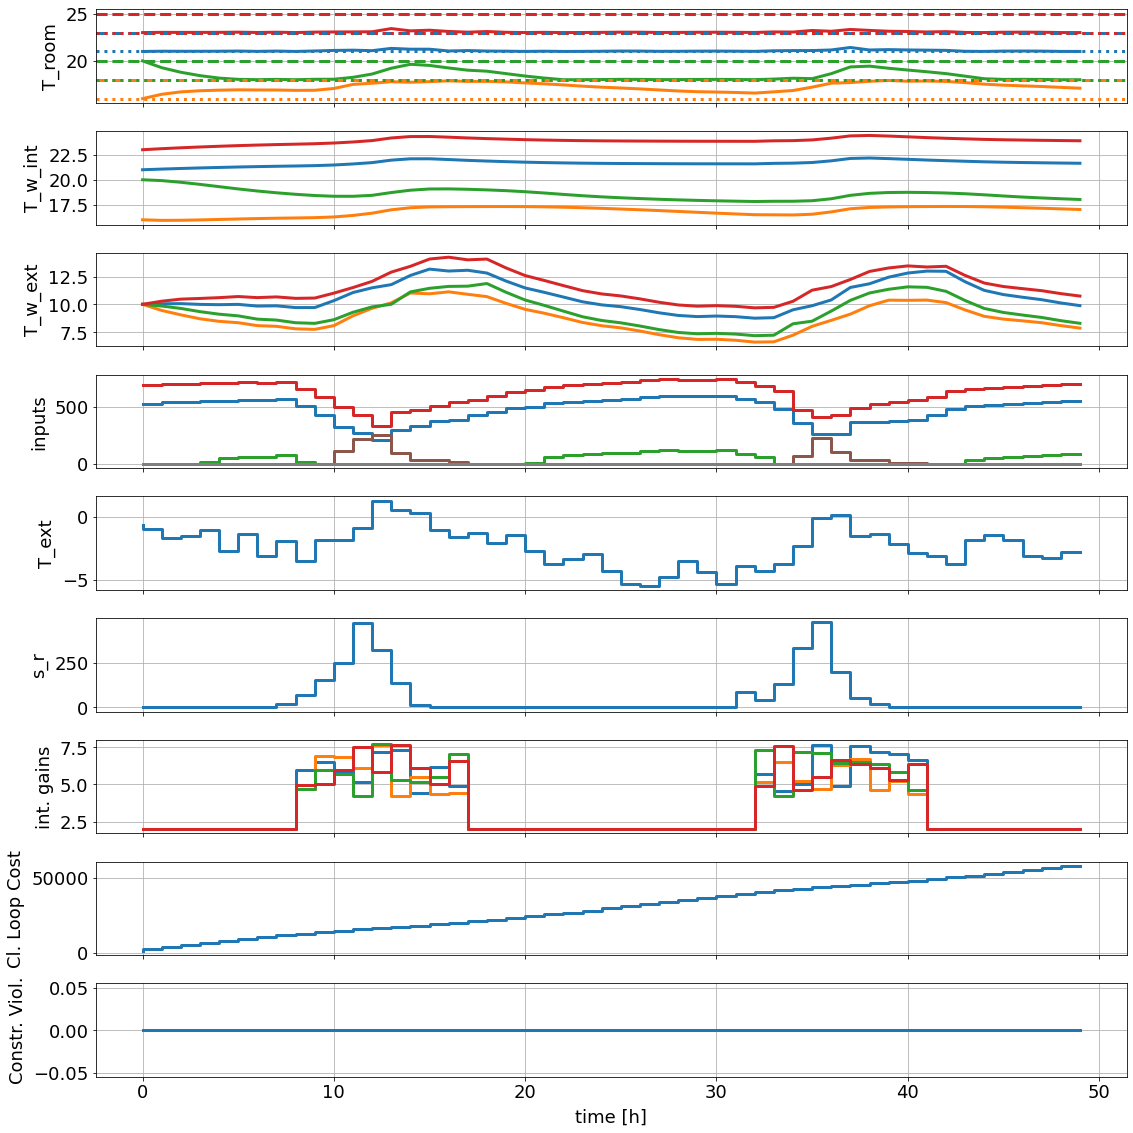

In [54]:
fig, ax = plt.subplots(9,1, sharex=True,figsize=(16,16))

# plot the states
ax[0].plot(hcb_mpc_data['_time'],hcb_mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(hcb_mpc_data['_time'],hcb_mpc_data['_x','T_w_int'])
ax[2].plot(hcb_mpc_data['_time'],hcb_mpc_data['_x','T_w_ext'])
ax[3].step(hcb_mpc_data['_time'],hcb_mpc_data['_u'])
ax[4].step(hcb_mpc_data['_time'],hcb_mpc_data['_tvp','T_ext'])
ax[5].step(hcb_mpc_data['_time'],hcb_mpc_data['_tvp','s_r'])
ax[6].step(hcb_mpc_data['_time'],hcb_mpc_data['_tvp','in_g'])
ax[7].step(hcb_mpc_data['_time'],clc_HCB)
ax[8].step(hcb_mpc_data['_time'],cv_HCB)
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[7].set_ylabel('Cl. Loop Cost')
ax[8].set_ylabel('Constr. Viol.')
ax[-1].set_xlabel('time [h]')
#fig.align_labels()
fig.tight_layout()

# Computation of a Robust invariant control set via differences

As the system has time varying parameters, this has to be taken into account for the calculation of the RCIS.
Therefore, the maximum change of the parameters in one time step during the used horizon was determined offline. The RCIS calculation was then extended to

$
\max_{x^{s\pm},u_{\text{min},\left[0:1\right]}^{s},u_{\text{max},\left[0:1\right]}^{s}} V(x^{s\pm}) \\
\begin{align}
\text{s.t}:\ &x^{s\pm}\in X,\ \forall s \in S,\label{eq:RCIS_cal:subeq:State_constr}\\
	&u_{\text{min},\left[0:1\right]}^s\in U,\ \forall s \in S,\\
    &u_{\text{max},\left[0:1\right]}^s\in U,\ \forall s \in S,\\
	&h(x_k^{\left[1:N_s\right]\pm})\preceq zero, \label{eq:RCIS_cal:subeq:dividing_RS} \\
	&x^{N_s+}\succeq f(x^{s\pm},u_{\text{min},k}^s,p_{\text{min},k}^{\pm})\succeq x^{1-},\ \forall s \in S, \forall k\in\{0,1\}.\\
    &x^{N_s+}\succeq f(x^{s\pm},u_{\text{max},k}^s,p_{\text{max},k}^{\pm})\succeq x^{1-},\ \forall s \in S, \forall k\in\{0,1\}.
\end{align}
$
Where $p_{\text{min},0}^{\pm}$ is the minimum and maximum realization of the smallest occuring prediction in the used data. 
$p_{\text{min},1}^{\pm}$ is then the minimum and maximum realizations of the smallest occuring prediction in the used data plus the maximum occuring change in the parameters in one time step...

This calculation is for the RCISs for the multistage-approach

In [55]:
# Predefine the number of partitions per Dimension for each step in the prediction horizon

cuts=[]
cuts.append(np.zeros((nx,1)))
cuts[0][0:nr]=1
#cuts[0][4]=1
ns1=1
for i in range(nx):
    ns1*=(cuts[0][i]+1)
nsl=[ns1]
for i in range(1):
    nsl.append(ns1)
    cuts.append(np.zeros((nx,1)))
    cuts[i][0:nr]=1

In [56]:
opt_x_ro = struct_symSX([
    entry('x_min', shape=nx, repeat=[ns]),
    entry('x_max', shape=nx, repeat=[ns]),
    entry('delta',shape=(nx),repeat=[int(np.max(cuts))]),
    entry('u', shape=nu, repeat=[len(nsl),ns,2])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[len(nsl),2]),
    entry('p_max',shape=nd, repeat=[len(nsl),2])
])

In [57]:
lb_opt_x_ro=opt_x_ro(-inf)
ub_opt_x_ro=opt_x_ro(inf)
lb_opt_x_ro['x_min'] = lb_x
lb_opt_x_ro['x_max'] = lb_x
ub_opt_x_ro['x_min'] = ub_x
ub_opt_x_ro['x_max'] = ub_x


lb_opt_x_ro['delta',:] = np.zeros((nx,1))
ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u

Calculating the Volume as a cost function proved itself numerically unstable for the maximization of the whole RCIS. Therefore, the volume was just calculated for the constrained states. The others were weigthed quadratically. All other states were additionally constrained to keep them in a realistic region for the initial conditions

In [58]:
lb_opt_x_ro['x_min',:,nr:2*nr] = lb_x[0:nr]-5
lb_opt_x_ro['x_max',:,nr:2*nr] = lb_x[0:nr]-5
ub_opt_x_ro['x_min',:,nr:2*nr] = ub_x[0:nr]+3
ub_opt_x_ro['x_max',:,nr:2*nr] = ub_x[0:nr]+3

lb_opt_x_ro['x_min',:,2*nr:] = lb_x[0:nr]/2-5
lb_opt_x_ro['x_max',:,2*nr:] = lb_x[0:nr]/2-5
ub_opt_x_ro['x_min',:,2*nr:] = ub_x[0:nr]/2+5
ub_opt_x_ro['x_max',:,2*nr:] = ub_x[0:nr]/2+5

In [59]:
J=0
g=[]
lb_g=[]
ub_g=[]


# This is h(x)<0: define the offsets in each dimension for the individual subsets
atled=SX.sym('atled',nx,int(np.max(cuts[0])))
for m in range(nx):
    for h in range(int(np.max(cuts[0]))):
        if cuts[0][m]<=h:
            g.append(opt_x_ro['delta',h][m])            
            lb_g.append(0)
            ub_g.append(0)
        elif cuts[0][m]-1>h:
            g.append(opt_x_ro['delta',h+1][m]-opt_x_ro['delta',h][m])
            lb_g.append(0)
            ub_g.append(inf)
        if cuts[0][m]<=h:
            atled[m,h]=0
        else:
            atled[m,h]=opt_x_ro['x_max',-1][m]-opt_x_ro['x_min',0][m]-opt_x_ro['delta',h][m]
        if cuts[0][m]>h:   
            g.append(opt_x_ro['x_max',-1][m]-opt_x_ro['x_min',0][m]-opt_x_ro['delta',h][m])
            lb_g.append(0)
            ub_g.append(inf)


# This is h(x)<0: constraint the corners of the subset to have the same offsets in specific dimensions
for s in range(ns):
    count=np.zeros((nx,1))
    remainder=ns
    rest=s
    for l in range(nx):
        if cuts[0][l]>0:
            remainder/=(cuts[0][l]+1)
            count[l]=rest//remainder
            rest-=remainder*count[l]
    for k in range(nx):
        if count[k]==0 and count[k]==cuts[0][k]:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k])
            lb_g.append(0)
            ub_g.append(0)
        elif count[k]==0 and count[k]!=cuts[0][k]:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k]-atled[k,int(count[k])])
            lb_g.append(0)
            ub_g.append(0)
        elif count[k]==cuts[0][k] and count[k]!=0:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k]-opt_x_ro['delta',int(count[k]-1)][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k])
            lb_g.append(0)
            ub_g.append(0)
        else:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k]-opt_x_ro['delta',int(count[k]-1)][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k]-atled[k,int(count[k])])
            lb_g.append(0)
            ub_g.append(0)

for i in range(len(nsl)):
    for s in range(ns):
        
        if i==len(nsl)-1:
            g.append(system(opt_x_ro['x_min',s], opt_x_ro['u',i,s,0],opt_p['p_min',i,0])-opt_x_ro['x_min',0])
            g.append(-system(opt_x_ro['x_max',s], opt_x_ro['u',i,s,0],opt_p['p_max',i,0])+opt_x_ro['x_max',-1])
            lb_g.append(np.zeros((2*nx,1)))
            ub_g.append(np.ones((2*nx,1))*inf)
        else:
            g.append(system(opt_x_ro['x_min',s], opt_x_ro['u',i,s,0],opt_p['p_min',i,0])-opt_x_ro['x_min',0])
            g.append(-system(opt_x_ro['x_max',s], opt_x_ro['u',i,s,0],opt_p['p_max',i,0])+opt_x_ro['x_max',-1])
            lb_g.append(np.zeros((2*nx,1)))
            ub_g.append(np.ones((2*nx,1))*inf)
        if i==len(nsl)-1:
            g.append(system(opt_x_ro['x_min',s], opt_x_ro['u',i,s,1],opt_p['p_min',i,1])-opt_x_ro['x_min',0])
            g.append(-system(opt_x_ro['x_max',s], opt_x_ro['u',i,s,1],opt_p['p_max',i,1])+opt_x_ro['x_max',-1])
            lb_g.append(np.zeros((2*nx,1)))
            ub_g.append(np.ones((2*nx,1))*inf)
        else:
            g.append(system(opt_x_ro['x_min',s], opt_x_ro['u',i,s,1],opt_p['p_min',i,1])-opt_x_ro['x_min',0])
            g.append(-system(opt_x_ro['x_max',s], opt_x_ro['u',i,s,1],opt_p['p_max',i,1])+opt_x_ro['x_max',-1])
            lb_g.append(np.zeros((2*nx,1)))
            ub_g.append(np.ones((2*nx,1))*inf)




    g.append(opt_x_ro['x_max',-1]-opt_x_ro['x_min',0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(inf*np.ones((nx,1)))
    #g.append(vertcat(*opt_x_ro['x_max',0,:])-vertcat(*opt_x_ro['x_max',i,:]))
    #g.append(vertcat(*opt_x_ro['x_min',0,:])-vertcat(*opt_x_ro['x_min',i,:]))
    #lb_g.append(np.zeros((2*ns*nx,1)))
    #ub_g.append(np.zeros((2*ns*nx,1)))
    
j=-1
for h in range(nr):
    j*=(opt_x_ro['x_max',-1][h]-opt_x_ro['x_min',0][h]+1e-4)
J+=j
for h in range(2*nr):
    J+=(ub_opt_x_ro['x_max',-1][h+nr]-opt_x_ro['x_max',-1][h+nr])**2
    J+=(opt_x_ro['x_min',0][h+nr]-lb_opt_x_ro['x_min',0][h+nr])**2

g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x_ro),'g':g, 'p':vertcat(opt_p)}
solver_mx_inv_set = nlpsol('solver','ipopt',prob,{'ipopt':{'max_iter':5000}})#,'hessian_approximation':'limited-memory'}})

In [60]:
delT_max=np.max(np.abs(data['T'][1:65]-data['T'][0:64]))
delsr_max=np.max(np.abs(data['sr'][1:65]-data['sr'][0:64]))
del_int_max=int_gains_max*(1+in_g_unc) -int_gains_min
print(delT_max)
print(delsr_max)
print(del_int_max)

1.6
255.55555555555557
5.800000000000001


In [61]:
p_min_0=p_fun_min(0)
p_min_0['T_ext']=np.min(data['T'][0:65])
p_min_0['s_r']=np.min(data['sr'][0:65])
p_min_0['in_g']=int_gains_min
p_min_min=p_min_0
p_min_min['T_ext']-=T_env_var
p_min_min['s_r']*=(1-sr_unc)
p_min_max=p_min_0
p_min_max['T_ext']+=T_env_var
p_min_max['s_r']*=(1+sr_unc)
p_min_1=p_min_0
p_min_1['T_ext']+=delT_max
p_min_1['s_r']+=delsr_max
p_min_1['in_g']=int_gains_max
p_min_min1=p_min_1
p_min_min1['T_ext']-=T_env_var
p_min_min1['s_r']*=(1-sr_unc)
p_min_min1['in_g']*=(1-in_g_unc)
p_min_max1=p_min_1
p_min_max1['T_ext']+=T_env_var
p_min_max1['s_r']*=(1+sr_unc)
p_min_max1['in_g']*=(1+in_g_unc)

In [62]:
p_max_0=p_fun_min(0)
p_max_0['T_ext']=np.max(data['T'][0:65])
p_max_0['s_r']=np.max(data['sr'][0:65])
p_max_0['in_g']=int_gains_max
p_max_min=p_max_0
p_max_min['T_ext']-=T_env_var
p_max_min['s_r']*=(1-sr_unc)
p_max_min['in_g']*=(1-in_g_unc)
p_max_max=p_max_0
p_max_max['T_ext']+=T_env_var
p_max_max['s_r']*=(1+sr_unc)
p_max_max['in_g']*=(1+in_g_unc)
p_max_1=p_max_0
p_max_1['T_ext']-=delT_max
p_max_1['s_r']-=delsr_max
p_max_1['in_g']=int_gains_min
p_max_min1=p_max_1
p_max_min1['T_ext']-=T_env_var
p_max_min1['s_r']*=(1-sr_unc)
p_max_max1=p_max_1
p_max_max1['T_ext']+=T_env_var
p_max_max1['s_r']*=(1+sr_unc)

In [63]:
opt_p_k=opt_p(0)
opt_p_k['p_min',0,0]=p_min_min
opt_p_k['p_min',1,0]=p_min_min1
opt_p_k['p_max',0,0]=p_min_max
opt_p_k['p_max',1,0]=p_min_max1
opt_p_k['p_min',0,1]=p_max_min
opt_p_k['p_min',1,1]=p_max_min1
opt_p_k['p_max',0,1]=p_max_max
opt_p_k['p_max',1,1]=p_max_max1

In [64]:
opt_x_initial=opt_x_ro(0)
#opt_x_initial['x_min']=x_0
#opt_x_initial['x_max']=x

opt_x_initial['u']=0.0
results=solver_mx_inv_set(p=vertcat(opt_p_k),lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro,x0=opt_x_initial)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      824
Number of nonzeros in inequality constraint Jacobian.:    10204
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:      908
                     variables with only lower bounds:       12
                variables with lower and upper bounds:      896
                     variables with only upper bounds:        0
Total number of equality constraints.................:      392
Total number of inequality constraints...............:     1564
        inequality constraints with only lower bounds:     1564
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

In [65]:
res=opt_x_ro(results['x'])

In [66]:
res['x_min',0]

DM([21, 16, 18, 23, 16.5795, 11.5795, 13.5795, 18.5795, 6.25737, 3.75737, 4.75737, 7.25737])

In [67]:
res['x_max',-1]

DM([23, 18, 20, 25, 25.4205, 20.4205, 22.4205, 27.4205, 15.7426, 13.2426, 14.2426, 16.7426])

Input is not at its bounds. Then due to linearity, this seems to be an RCIS for the used data.

In [68]:
lb_x_ro=res['x_min',0]
#print(lb_x_ro)

In [69]:
ub_x_ro=res['x_max',-1]
#print(ub_x_ro)

# Simplified Closed Loop Approach
$
\min_{x_{\left[0:N\right]}^+,x_{\left[0:N\right]}^-,u_{\left[0:N-1\right]}^+,u_{\left[0:N-1\right]}^-} \quad \sum_{k=0}^{N-1} (\ell(x_k^+,u_k^+)+\ell(x_k^-,u_k^-))+V_f(x_{N}^+)+V_f(x_{N}^-)\\
\begin{aligned}
	s.t:\quad&x_0^{\pm}=x_0,\\
	&x_{k+1}^{\pm}=f(x_k^{\pm},u_k^{\pm},p^{\pm}),\ \forall k\in\{0,...,N-1\}\\
	&x_k^{\pm}\in X_{\text{RCIS}},\ k\in\{1,...,N\}\\
	&u_k^{\pm}\in U ,\ \forall k\in\{0,...,N-1\},\\
	&u_0^+=u_0^-.
\end{aligned}
$

In [70]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1,2]),
    entry('u', shape=nu, repeat=[N,2])
])
opt_p=struct_symSX([
    entry('p_min',shape=nd, repeat=[N]),
    entry('p_max',shape=nd, repeat=[N])
])

In [71]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [72]:
lb_opt_x['x'] = lb_x_ro
ub_opt_x['x'] = ub_x_ro
#lb_opt_x['x'] = res['x_min',0]
#ub_opt_x['x'] = res['x_max',-1]

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [73]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [74]:
x_init = SX.sym('x_init', nx)
u_in = SX.sym('u_in', nu)
p_plus=SX.sym('p_plus', nd)
p_minus=SX.sym('p_minus', nd)
x0 = opt_x['x', 0, 0]
g.append(opt_x['x', 0,0]-opt_x['x', 0,1])
g.append(x0-x_init)
lb_g.append(np.zeros((2*nx,1)))
ub_g.append(np.zeros((2*nx,1)))
# 01

for i in range(N):
    # 02 - Your code here!
    # objective
    if i>0:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i,0],opt_x['u',i-1,0])
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i,1],opt_x['u',i-1,1])
    else:
        J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i,0],u_in)
        J += stage_cost_fcn(opt_x['x',i,1], opt_x['u',i,1],u_in)
    # 02

    # 03 - Your code here!
    # equality constraints (system equation)


    # 04 - Your code here!
    x_next_plus = system(opt_x['x',i,0], opt_x['u',i,0],opt_p['p_max',i])
    x_next_minus = system(opt_x['x',i,1], opt_x['u',i,1],opt_p['p_min',i])
    g.append(x_next_plus - opt_x['x', i+1, 0])
    g.append(x_next_minus - opt_x['x', i+1, 1])
    lb_g.append(np.zeros((2*nx,1)))
    ub_g.append(np.zeros((2*nx,1)))
    # 04


# 05 - Your code here!
J += terminal_cost_fcn(opt_x['x', N,0])
J += terminal_cost_fcn(opt_x['x', N,1])
# 05
g.append(opt_x['u', 0, 1] - opt_x['u', 0, 0])
lb_g.append(np.zeros((nu,1)))
ub_g.append(np.zeros((nu,1)))
# 06 - Your code here!
g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,u_in,opt_p)}
mpc_mon_solver = nlpsol('solver','ipopt',prob)

In [75]:
# Define the initial state
x_0 = 20*np.ones((nx,1))
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10

#x_0=(lb_list[0]+ub_list[0])/2

# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

In [76]:
simulator.set_tvp_fun(p_fun_min)
simulator.reset_history()
simulator.x0=x_0

In [77]:
tic=time.time()
opt_p_k=opt_p(0)
clc_MS_MPC=np.zeros((N_sim,1))
cv_MS_MPC=np.zeros((N_sim,1))

for i in range(N_sim):
    print(i)
    # 01 - Your code here!
    #lb_opt_x['x',:,:] = lb_x_ro[i:i+N+1]
    #ub_opt_x['x',:,:] = ub_x_ro[i:i+N+1]


    for k in range(N):
        opt_p_k['p_min',k]=vertcat(p_fun_min(k*dt+i*dt))
        opt_p_k['p_max',k]=vertcat(p_fun_max(k*dt+i*dt))
    # solve optimization problem
    # optionally: Warmstart the optimizer by passing the previous solution as an initial guess!
    if i>0:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,u_k,opt_p_k), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    else:
        mpc_res = mpc_mon_solver(p=vertcat(x_0,np.zeros((nu,1)),opt_p_k), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)



    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0,0]
    # 02
    if i>0:
        clc_MS_MPC[i]=clc_MS_MPC[i-1]+stage_cost_fcn(x_0,u_k,res_u_mpc[-1])
    else:
        clc_MS_MPC[i]=stage_cost_fcn(x_0,u_k,u0)
    # simulate the system
    # 03
    cv_MS_MPC[i]=np.sum([np.max([lb_x[l]-x_0[l],0]) for l in range(nx)])+np.sum([np.max([x_0[l]-ub_x[l],0]) for l in range(nx)])

    # simulate the system
    x_next = simulator.make_step(u_k)
    # 03
    
    # 04 - Your code here!
    # Update the initial state
    x_0 = x_next

    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
toc_MSMPC=time.time()-tic

0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      504
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

C:\Users\smmzhein\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  23 2.6174117e+004 6.16e-011 1.30e-004  -8.6 5.67e-002    -  9.97e-001 9.98e-001f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:  2.6174117401398791e+004   2.6174117401398791e+004
Dual infeasibility......:  1.2953701443189778e-004   1.2953701443189778e-004
Constraint violation....:  6.1625371472473489e-011   6.1625371472473489e-011
Complementarity.........:  2.9808860787828647e-005   2.9808860787828647e-005
Overall NLP error.......:  3.9165092519259068e-009   1.2953701443189778e-004


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 24
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPO

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.2881031e+004 2.57e-009 2.72e+000  -8.6 7.72e-001    -  9.71e-001 9.04e-001f  1
  21 2.2879277e+004 8.92e-010 1.10e-001  -8.6 8.35e-002    -  9.67e-001 9.83e-001f  1
In iteration 21, 6 Slacks too small, adjusting variable bounds
  22 2.2879247e+004 7.79e-012 9.55e-006  -8.6 1.78e-003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:  2.2879246866298497e+004   2.2879246866298497e+004
Dual infeasibility......:  9.5507852882560006e-006   9.5507852882560006e-006
Constraint violation....:  7.7875483839306980e-012   7.7875483839306980e-012
Complementarity.........:  9.2086072272435870e-008   9.2086072272435870e-008
Overall NLP error.......:  1.6690086849099659e-011   9.5507852882560006e-006


Number of objective function evaluations             = 23
Number of objective gradient evaluations           

Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 17
Total CPU secs in IPOPT (w/o function evaluations)   =      0.029
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        18
       nlp_g  |   1.00ms ( 55.56us)   1.00ms ( 55.56us)        18
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        19
  nlp_hess_l  |        0 (       0)        0 (       0)        17
   nlp_jac_g  |   1.00ms ( 52.63us) 981.00us ( 51.63us)        19
       total  |  33.00ms ( 33

21
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1972
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      504
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   

  17 2.9708384e+004 1.07e-014 3.24e+005  -8.6 1.41e-001    -  9.91e-001 9.91e-001f  1
  18 2.9708350e+004 1.07e-014 2.06e+002  -8.6 2.03e-003    -  1.00e+000 1.00e+000f  1
  19 2.9708350e+004 7.11e-015 1.79e-013  -8.6 1.04e-007    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  2.9708350370482101e+004   2.9708350370482101e+004
Dual infeasibility......:  1.7939592181812607e-013   1.7939592181812607e-013
Constraint violation....:  7.1054273576010019e-015   7.1054273576010019e-015
Complementarity.........:  2.5061857351441719e-009   2.5061857351441719e-009
Overall NLP error.......:  2.5061857351441719e-009   2.5061857351441719e-009


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 0
Number of equality con

  12 2.5184511e+004 1.69e-001 4.45e+001  -1.0 8.25e+001    -  9.15e-001 5.38e-001f  1
  13 2.5117363e+004 2.63e-002 6.88e+000  -1.0 3.81e+001    -  7.82e-001 8.44e-001f  1
  14 2.5105273e+004 2.63e-004 2.30e+000  -1.0 5.94e+000    -  1.00e+000 9.90e-001f  1
  15 2.5105163e+004 2.63e-006 2.31e+002  -1.0 5.95e-002    -  1.00e+000 9.90e-001h  1
  16 2.5105162e+004 2.52e-008 2.21e+004  -1.0 1.62e-003    -  1.00e+000 9.90e-001h  1
  17 2.5105162e+004 1.07e-014 8.10e-008  -1.0 1.55e-005    -  1.00e+000 1.00e+000h  1
  18 2.5087112e+004 1.07e-014 4.29e+006  -5.7 9.22e-001    -  9.73e-001 9.54e-001f  1
  19 2.5086261e+004 1.07e-014 5.83e+004  -5.7 5.46e-002    -  9.96e-001 9.92e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.5086254e+004 1.42e-014 2.57e-011  -5.7 4.36e-004    -  1.00e+000 1.00e+000f  1
  21 2.5086254e+004 1.42e-014 9.09e-012  -8.6 1.59e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 21

                            

   1 2.5888113e+004 1.18e+000 1.91e+001  -1.0 1.88e+002    -  2.07e-001 1.08e-002f  1
   2 2.5922488e+004 1.12e+000 1.62e+002  -1.0 1.51e+002    -  5.59e-001 4.54e-002h  1
   3 2.6014414e+004 1.04e+000 1.49e+002  -1.0 1.53e+002    -  6.23e-002 7.29e-002h  1
   4 2.6239867e+004 8.43e-001 1.41e+002  -1.0 1.39e+002    -  3.90e-001 1.91e-001h  1
   5 2.6262697e+004 8.24e-001 1.37e+002  -1.0 1.08e+002    -  7.94e-003 2.29e-002h  1
   6 2.6890651e+004 2.89e-001 5.87e+001  -1.0 1.06e+002    -  2.16e-001 6.49e-001h  1
   7 2.6899162e+004 2.82e-001 5.91e+001  -1.0 3.70e+001    -  1.59e-001 2.44e-002h  1
   8 2.7161476e+004 6.56e-002 1.37e+001  -1.0 3.61e+001    -  7.67e-001 7.67e-001h  1
   9 2.7239081e+004 6.56e-004 1.69e+001  -1.0 8.33e+000    -  8.04e-001 9.90e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.7238477e+004 6.56e-006 9.06e+001  -1.0 6.74e-001    -  1.00e+000 9.90e-001h  1
  11 2.7238444e+004 6.76e-008 9.34e+003  -1.0 4.39e-002    

In iteration 9, 2 Slacks too small, adjusting variable bounds
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2221192e+004 1.85e-011 1.23e+007  -8.6 1.57e-001    -  9.99e-001 8.00e-001f  1
In iteration 10, 4 Slacks too small, adjusting variable bounds
  11 3.2220499e+004 4.33e-011 5.36e-002  -8.6 3.24e-002    -  1.00e+000 9.14e-001f  1
In iteration 11, 6 Slacks too small, adjusting variable bounds
  12 3.2220434e+004 4.33e-011 5.84e-008  -8.6 2.77e-003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  3.2220434274913929e+004   3.2220434274913929e+004
Dual infeasibility......:  5.8351693296258955e-008   5.8351693296258955e-008
Constraint violation....:  4.3328896026650909e-011   4.3328896026650909e-011
Complementarity.........:  2.5826095746560623e-009   2.5826095746560623e-009
Overall NLP error.......:  4.3328896026650909e-011   5.83516932

Objective...............:  2.9413758526770842e+004   2.9413758526770842e+004
Dual infeasibility......:  2.6120276304525073e-003   2.6120276304525073e-003
Constraint violation....:  1.7195489476762305e-010   1.7195489476762305e-010
Complementarity.........:  7.4388073522866896e-006   7.4388073522866896e-006
Overall NLP error.......:  9.1866003378173177e-009   2.6120276304525073e-003


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w/o function evaluations)   =      0.029
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall  

In [78]:
ms_mpc_data=copy.copy(simulator.data)

Text(0.5, 0, 'time [h]')

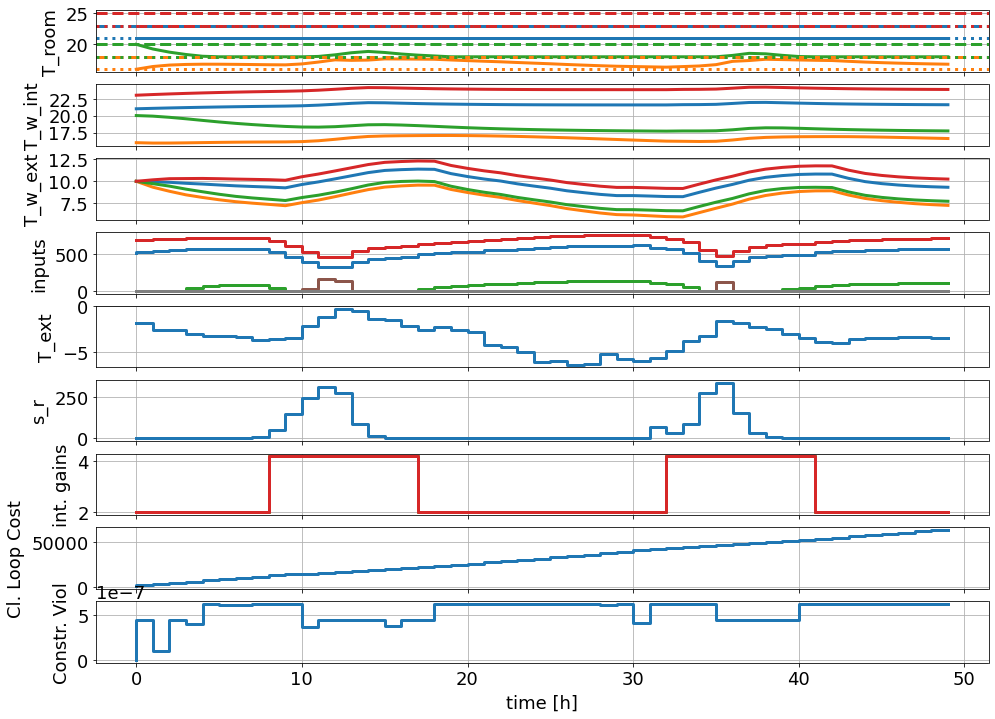

In [79]:
fig, ax = plt.subplots(9,1, sharex=True,figsize=(16,12))

# plot the states
ax[0].plot(ms_mpc_data['_time'],ms_mpc_data['_x','T_r'])
ax[0].axhline(lb_x[0],color='tab:blue',linestyle=':')
ax[0].axhline(ub_x[0],color='tab:blue',linestyle='--')
ax[0].axhline(lb_x[1],color='tab:orange',linestyle=':')
ax[0].axhline(ub_x[1],color='tab:orange',linestyle='--')
ax[0].axhline(lb_x[2],color='tab:green',linestyle=':')
ax[0].axhline(ub_x[2],color='tab:green',linestyle='--')
ax[0].axhline(lb_x[3],color='tab:red',linestyle=':')
ax[0].axhline(ub_x[3],color='tab:red',linestyle='--')
ax[1].plot(ms_mpc_data['_time'],ms_mpc_data['_x','T_w_int'])
ax[2].plot(ms_mpc_data['_time'],ms_mpc_data['_x','T_w_ext'])
ax[3].step(ms_mpc_data['_time'],ms_mpc_data['_u'])
ax[4].step(ms_mpc_data['_time'],ms_mpc_data['_tvp','T_ext'])
ax[5].step(ms_mpc_data['_time'],ms_mpc_data['_tvp','s_r'])
ax[6].step(ms_mpc_data['_time'],ms_mpc_data['_tvp','in_g'])
ax[7].step(ms_mpc_data['_time'],clc_MS_MPC)
ax[8].step(ms_mpc_data['_time'],cv_MS_MPC)
# Set labels
ax[0].set_ylabel('T_room')
ax[3].set_ylabel('inputs')
ax[1].set_ylabel('T_w_int')
ax[2].set_ylabel('T_w_ext')
ax[4].set_ylabel('T_ext')
ax[5].set_ylabel('s_r')
ax[6].set_ylabel('int. gains')
ax[7].set_ylabel('Cl. Loop Cost')
ax[8].set_ylabel('Constr. Viol')
ax[-1].set_xlabel('time [h]')

Saving the solutions for Postprocessing

In [ ]:
#data_dict={'MPC':[mpc_data,clc_MPC,cv_MPC,toc_MPC],'HCB':[hcb_mpc_data,clc_HCB,cv_HCB,toc_HCB],'MS-MPC':[ms_mpc_data,clc_MS_MPC,cv_MS_MPC,toc_MSMPC]}

In [ ]:
#np.save('4room_var.npy',data_dict,allow_pickle=True) # Needs to be renamed according to uncertainty realization

# Calculation of RCIS after Equation (12)

Can be used for systems with no time-varying parameters.

In [80]:
cuts=np.zeros((nx,1))
cuts[0:nr]=1
#cuts[4:]=1
ns=1
for i in range(nx):
    ns*=(cuts[i]+1)
ns=int(ns[0])
print(ns)

16


In [81]:
x_ref=SX.sym('x_ref',nx,1)

In [82]:
opt_x_ro = struct_symSX([
    entry('x_min', shape=nx, repeat=[ns]),
    entry('x_max', shape=nx, repeat=[ns]),
    entry('delta',shape=(nx),repeat=[int(np.max(cuts))]),
    entry('u', shape=nu, repeat=[ns])
])

In [83]:
lb_opt_x_ro = opt_x_ro(0)
ub_opt_x_ro = opt_x_ro(np.inf)
lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u
#lb_opt_x_ro['delta',:] = np.zeros((nx,1))
#ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

In [84]:
lb_opt_x_ro['x_min'] = lb_x
lb_opt_x_ro['x_max'] = lb_x
ub_opt_x_ro['x_min'] = ub_x
ub_opt_x_ro['x_max'] = ub_x


lb_opt_x_ro['delta',:] = np.zeros((nx,1))
ub_opt_x_ro['delta',:] = np.ones((nx,1))*inf

lb_opt_x_ro['u'] = lb_u
ub_opt_x_ro['u'] = ub_u

In [85]:
lb_opt_x_ro['x_min',:,nr:2*nr] = lb_x[0:nr]-5
lb_opt_x_ro['x_max',:,nr:2*nr] = lb_x[0:nr]-5
ub_opt_x_ro['x_min',:,nr:2*nr] = ub_x[0:nr]+3
ub_opt_x_ro['x_max',:,nr:2*nr] = ub_x[0:nr]+3

lb_opt_x_ro['x_min',:,2*nr:] = lb_x[0:nr]/2-5
lb_opt_x_ro['x_max',:,2*nr:] = lb_x[0:nr]/2-5
ub_opt_x_ro['x_min',:,2*nr:] = ub_x[0:nr]/2+5
ub_opt_x_ro['x_max',:,2*nr:] = ub_x[0:nr]/2+5

In [86]:
x_0=np.ones((nx,1))*20
for i in range(nx):
    if lb_x[i]<=x_0[i] and x_0[i]<=ub_x[i]:
        1
    else:
        x_0[i::nr]=lb_x[i]
x_0[-nr:]=10

In [87]:
J=0
g=[]
lb_g=[]
ub_g=[]
x_ref=SX.sym('x_ref',nx)
p_plus=SX.sym('p_plus',nd)
p_minus=SX.sym('p_minus',nd)
atled=SX.sym('atled',nx,int(np.max(cuts)))
for m in range(nx):
    for h in range(int(np.max(cuts))):
        if cuts[m]<=h:
            g.append(opt_x_ro['delta',h][m])            
            lb_g.append(0)
            ub_g.append(0)
        elif cuts[m]-1>h:
            g.append(opt_x_ro['delta',h+1][m]-opt_x_ro['delta',h][m])
            lb_g.append(0)
            ub_g.append(inf)
        if cuts[m]<=h:
            atled[m,h]=0
        else:
            atled[m,h]=opt_x_ro['x_max',-1][m]-opt_x_ro['x_min',0][m]-opt_x_ro['delta',h][m]
        if cuts[m]>h:   
            g.append(opt_x_ro['x_max',-1][m]-opt_x_ro['x_min',0][m]-opt_x_ro['delta',h][m])
            lb_g.append(0)
            ub_g.append(inf)
    


for s in range(ns):
    count=np.zeros((nx,1))
    remainder=ns
    rest=s
    for l in range(nx):
        if cuts[l]>0:
            remainder/=(cuts[l]+1)
            count[l]=rest//remainder
            rest-=remainder*count[l]
    for k in range(nx):
        if count[k]==0 and count[k]==cuts[k]:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k])
            lb_g.append(0)
            ub_g.append(0)
        elif count[k]==0 and count[k]!=cuts[k]:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k]-atled[k,int(count[k])])
            lb_g.append(0)
            ub_g.append(0)
        elif count[k]==cuts[k] and count[k]!=0:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k]-opt_x_ro['delta',int(count[k]-1)][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k])
            lb_g.append(0)
            ub_g.append(0)
        else:
            g.append(opt_x_ro['x_min',s][k]-opt_x_ro['x_min',0][k]-opt_x_ro['delta',int(count[k]-1)][k])
            lb_g.append(0)
            ub_g.append(0)
            g.append(opt_x_ro['x_max',-1][k]-opt_x_ro['x_max',s][k]-atled[k,int(count[k])])
            lb_g.append(0)
            ub_g.append(0)



    # The new states should lie in the old states -> shrinking set
    g.append(system(opt_x_ro['x_min',s], opt_x_ro['u',s],p_minus)-opt_x_ro['x_min',0])
    g.append(-system(opt_x_ro['x_max',s], opt_x_ro['u',s],p_plus)+opt_x_ro['x_max',-1])
    lb_g.append(np.zeros((2*nx,1)))
    ub_g.append(np.ones((2*nx,1))*inf)
    

        
g.append(opt_x_ro['x_max',-1]-opt_x_ro['x_min',0])
lb_g.append(np.zeros((nx,1)))
ub_g.append(inf*np.ones((nx,1)))

J=-1
for i in range(nr):
    J*=10*(opt_x_ro['x_max',-1][i]-opt_x_ro['x_min',0][i]+1e-4)
for i in range(2*nr):
    J+=(ub_opt_x_ro['x_max',-1][i+nr]-opt_x_ro['x_max',-1][i+nr])**2
    J+=(opt_x_ro['x_min',0][i+nr]-lb_opt_x_ro['x_min',0][i+nr])**2
g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x_ro),'g':g, 'p':vertcat(p_plus,p_minus)}
solver_mx_inv_set = nlpsol('solver','ipopt',prob,{'ipopt':{'max_iter':2000}})#,'hessian_approximation':'limited-memory'}})

In [88]:
t=9
pt_min=vertcat(p_min_min)
pt_max=vertcat(p_min_max)

In [89]:
opt_x_initial=opt_x_ro(0)
#opt_x_initial=res
results=solver_mx_inv_set(p=vertcat(pt_max,pt_min),lbg=lb_g,ubg=ub_g,lbx=lb_opt_x_ro,ubx=ub_opt_x_ro,x0=opt_x_initial)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      824
Number of nonzeros in inequality constraint Jacobian.:     2572
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:      524
                     variables with only lower bounds:       12
                variables with lower and upper bounds:      512
                     variables with only upper bounds:        0
Total number of equality constraints.................:      392
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

 106 -3.5032424e+004 1.74e+000 6.35e+004  -1.0 1.70e+000   4.2 1.49e-002 2.88e-004f  1
 107 -3.5025030e+004 1.74e+000 6.35e+004  -1.0 1.37e+000   4.6 2.02e-002 2.77e-004h  1
 108 -3.4737114e+004 1.74e+000 6.47e+004  -1.0 5.93e+000   4.1 2.60e-003 9.49e-004h  1
 109 -3.4702932e+004 1.74e+000 6.61e+004  -1.0 8.31e+000   3.7 2.44e-003 1.57e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 -3.4718925e+004 1.74e+000 9.97e+004  -1.0 8.38e+000   4.1 2.59e-003 3.70e-004f  1
 111 -3.4808455e+004 1.74e+000 1.15e+005  -1.0 1.49e+001   3.6 1.16e-003 2.61e-004f  1
 112 -3.4812903e+004 1.74e+000 1.22e+005  -1.0 2.71e+001   3.1 6.80e-004 8.99e-006f  1
 113 -3.4863612e+004 1.73e+000 1.27e+005  -1.0 1.31e+001   3.6 7.29e-004 3.01e-004f  1
 114 -3.5235983e+004 1.73e+000 1.27e+005  -1.0 1.66e+001   3.1 5.48e-004 5.30e-004f  1
 115 -3.5227892e+004 1.73e+000 1.43e+005  -1.0 1.87e+001   3.5 1.00e-003 2.60e-005h  1
 116 -3.4457709e+004 1.73e+000 1.43e+005  -1.0 5.

In [90]:
res=opt_x_ro(results['x'])

In [91]:
res['x_min',0]

DM([21, 16, 18, 23, 16.5795, 11.5795, 13.5795, 18.5795, 6.25737, 3.75737, 4.75737, 7.25737])

In [92]:
res['x_max',-1]

DM([23, 18, 20, 25, 25.4205, 20.4205, 22.4205, 27.4205, 15.7426, 13.2426, 14.2426, 16.7426])

In [96]:
Prev_res=res

# Plotting results

Load all results

In [93]:
plot_min=np.load('4room_min.npy',allow_pickle=True).item()
plot_max=np.load('4room_max.npy',allow_pickle=True).item()
plot_var=np.load('4room_var.npy',allow_pickle=True).item()
dat=[plot_var,plot_min,plot_max]

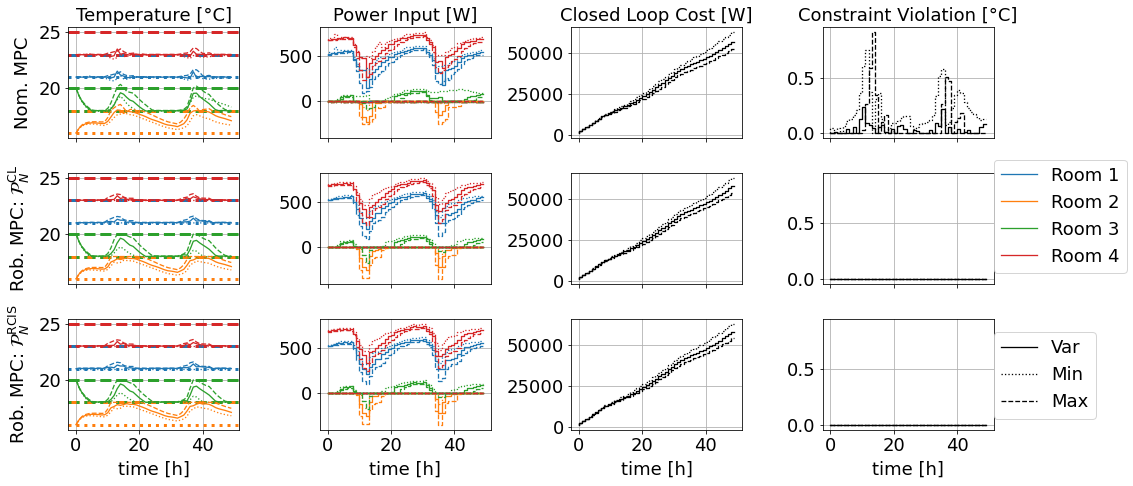

In [94]:
scale=1
fig, ax = plt.subplots(3,4, sharex=True,sharey='col',figsize=(scale*16,scale*7))
for i in range(3):
    ax[i,0].axhline(lb_x[0],color='tab:blue',linestyle=':')
    ax[i,0].axhline(ub_x[0],color='tab:blue',linestyle='--')
    ax[i,0].axhline(lb_x[1],color='tab:orange',linestyle=':')
    ax[i,0].axhline(ub_x[1],color='tab:orange',linestyle='--')
    ax[i,0].axhline(lb_x[2],color='tab:green',linestyle=':')
    ax[i,0].axhline(ub_x[2],color='tab:green',linestyle='--')
    ax[i,0].axhline(lb_x[3],color='tab:red',linestyle=':')
    ax[i,0].axhline(ub_x[3],color='tab:red',linestyle='--')

style=['-',':','--']
label_style=['Var','Min', 'Max']
label_color=['Room 1','Room 2','Room 3', 'Room 4']
widht=1.3
# plot for min
k=0
for plot in dat:
    # For nominal MPC
    ax[0,0].plot(plot['MPC'][0]['_time'],plot['MPC'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    ax[0,1].step(plot['MPC'][0]['_time'],plot['MPC'][0]['_u','u_heat'],linewidth=widht,linestyle=style[k])
    ax[0,1].set_prop_cycle(None)
    ax[0,1].step(plot['MPC'][0]['_time'],-plot['MPC'][0]['_u','u_cool'],linewidth=widht,linestyle=style[k])
    ax[0,2].step(plot['MPC'][0]['_time'],plot['MPC'][1],linewidth=widht,linestyle=style[k],color='black')
    ax[0,3].step(plot['MPC'][0]['_time'],plot['MPC'][2],linewidth=widht,linestyle=style[k],color='black')
    # For Hyperrectangle Cutting and Bonding
    if k==0:
        ax[1,0].plot(plot['HCB'][0]['_time'],plot['HCB'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    else:
        ax[1,0].plot(plot['HCB'][0]['_time'],plot['HCB'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    ax[1,1].step(plot['HCB'][0]['_time'],plot['HCB'][0]['_u','u_heat'],linewidth=widht,linestyle=style[k])
    ax[1,1].set_prop_cycle(None)
    ax[1,1].step(plot['HCB'][0]['_time'],-plot['HCB'][0]['_u','u_cool'],linewidth=widht,linestyle=style[k])
    ax[1,2].step(plot['HCB'][0]['_time'],plot['HCB'][1],linewidth=widht,linestyle=style[k],color='black')
    ax[1,3].step(plot['HCB'][0]['_time'],plot['HCB'][2],linewidth=widht,linestyle=style[k],color='black')
    # For Multi-Stage
    ax[2,0].plot(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][0]['_x','T_r'],linewidth=widht,linestyle=style[k])
    ax[2,1].step(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][0]['_u','u_heat'],linewidth=widht,linestyle=style[k])
    ax[2,1].set_prop_cycle(None)
    ax[2,1].step(plot['MS-MPC'][0]['_time'],-plot['MS-MPC'][0]['_u','u_cool'],linewidth=widht,linestyle=style[k])
    ax[2,2].step(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][1],linewidth=widht,linestyle=style[k],color='black')
    ax[2,3].step(plot['MS-MPC'][0]['_time'],plot['MS-MPC'][2],linewidth=widht,linestyle=style[k],color='black',label=label_style[k])
    for i in range(3):
        for j in range(4):
            ax[i,j].set_prop_cycle(None)
    k+=1

for i in range(4):
    ax[1,3].plot(0,0,linewidth=widht,linestyle=style[0],label=label_color[i])
# Set labels
ax[0,0].set_ylabel('Nom. MPC')
ax[1,0].set_ylabel('Rob. MPC: $\mathcal{P}_N^{\mathrm{CL}}$')
ax[2,0].set_ylabel('Rob. MPC: $\mathcal{P}_N^{\mathrm{RCIS}}$')
ax[0,0].title.set_text('Temperature [°C]')
ax[0,1].title.set_text('Power Input [W]')
ax[0,2].title.set_text('Closed Loop Cost [W]')
ax[0,3].title.set_text('Constraint Violation [°C]')

ax[-1,0].set_xlabel('time [h]')
ax[-1,1].set_xlabel('time [h]')
ax[-1,2].set_xlabel('time [h]')
ax[-1,3].set_xlabel('time [h]')
ax[2,3].legend(loc=[1,0.1])
ax[1,3].legend(loc=[1,0.1])
#fig.legend()
fig.tight_layout()
fig.align_labels()

In [349]:
fig.savefig('4rooms_34.pdf')

Compute the mean computation times per MPC iteration

In [95]:
t_mean=np.zeros((3,1))
for i in range(len(plot)):
    t_mean[0]+=dat[i]['MPC'][-1]
    t_mean[1]+=dat[i]['HCB'][-1]
    t_mean[2]+=dat[i]['MS-MPC'][-1]
t_mean/=(len(plot)*N_sim)
print(t_mean)

[[ 0.0399306 ]
 [16.32188937]
 [ 0.03918927]]
